In [1]:
import torch
from torch.autograd import Function, Variable
import torch.nn.functional as F
from torch import nn
from torch.nn.parameter import Parameter
import torch.optim as optim
from torch.nn.utils import parameters_to_vector
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import numpy.random as npr

import matplotlib
from matplotlib import pyplot as plt

from mpc import mpc
from mpc.mpc import GradMethods, QuadCost, LinDx
from mpc import casadi_control
#from mpc.dynamics import NNDynamics
#import mpc.util as eutil
from mpc.env_dx import frenet_dyn_bicycle  #changed
from mpc.track.src import simple_track_generator, track_functions

import time
import os
import shutil
import pickle as pkl
import collections

import argparse

#from tqdm import tqdm



In [2]:
class NN(nn.Module):
    #changed output dimensions
    def __init__(self, H):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(H + 5, 512)  
        self.fc2 = nn.Linear(512, 512)  
        self.output1 = nn.Linear(512, 10) 
        self.output2 = nn.Linear(512, 10) 

    def forward(self, c, x0):
        combined = torch.cat((c, x0), dim=1)
        x = F.relu(self.fc1(combined))
        x = F.relu(self.fc2(x))
        q = F.relu(self.output1(x)) + 0.0001
        p = self.output2(x)
        return q, p
    
def penalty_d(d, th, factor=100000):  
    overshoot_pos = (d - th).clamp(min=0)
    overshoot_neg = (-d - th).clamp(min=0)
    penalty_pos = torch.exp(overshoot_pos) - 1
    penalty_neg = torch.exp(overshoot_neg) - 1 
    return factor*(penalty_pos + penalty_neg)

def penalty_v(v, th, factor=100000):  
    penalty_pos = (v - th).clamp(min=0) ** 2
    return factor*penalty_pos

def penalty_ac(self, ac, factor=1000.):  
        penalty = (ac - ac_max).clamp(min=0) ** 2
        return factor*penalty

In [3]:
# Let's try to create a track 

track_density = 300
track_width = 0.5

gen = simple_track_generator.trackGenerator(track_density,track_width)
track_name = 'LONG_TRACK'

t = 0.3
init = [0,0,0]

track_function = {
    'DEMO_TRACK'    : track_functions.demo_track,
    'HARD_TRACK'    : track_functions.hard_track,
    'LONG_TRACK'    : track_functions.long_track,
    'LUCERNE_TRACK' : track_functions.lucerne_track,
    'BERN_TRACK'    : track_functions.bern_track,
    'INFINITY_TRACK': track_functions.infinity_track,
    'SNAIL_TRACK'   : track_functions.snail_track
}.get(track_name, track_functions.demo_track)
    
track_function(gen, t, init)
    
gen.populatePointsAndArcLength()
gen.centerTrack()

track_coord = torch.from_numpy(np.vstack([gen.xCoords, gen.yCoords, gen.arcLength, gen.tangentAngle, gen.curvature]))

In [4]:
device = 'cpu' #to do

mpc_T = 25
n_batch = 32
H_curve = 80

l_r = 0.2
l_f = 0.2

v_max = 2.5
a_max = 3.
delta_max = 0.4 # taken from hardware

ac_max = (0.7*v_max)**2 * delta_max / (l_r+l_f)

dt = 0.04

params = torch.tensor([l_r, l_f, track_width, v_max, ac_max, dt, a_max, delta_max])

In [5]:
true_dx = frenet_dyn_bicycle.FrenetDynBicycleDx(track_coord, params)

u_lower = torch.tensor([-a_max, -delta_max]).unsqueeze(0).unsqueeze(0).repeat(mpc_T, n_batch, 1)
u_upper = torch.tensor([a_max, delta_max]).unsqueeze(0).unsqueeze(0).repeat(mpc_T, n_batch, 1)
u_init= torch.tensor([0.1, 0.0]).unsqueeze(0).unsqueeze(0).repeat(mpc_T, n_batch, 1)

n_state = true_dx.n_state
n_ctrl = true_dx.n_ctrl

eps = 1
lqr_iter = 20
grad_method = GradMethods.AUTO_DIFF

#softplus_op = torch.nn.Softplus(10)

10


In [6]:
def sample_xinit(n_batch):
    def uniform(shape, low, high):
        r = high-low
        return torch.rand(shape)*r+low
    sigma = uniform(n_batch, 0.01, 20.)
    d = uniform(n_batch, -track_width*0.4, track_width*0.4)
    phi = uniform(n_batch, -0.4*np.pi, 0.4*np.pi)
    r = uniform(n_batch, -0.05*np.pi, 0.05*np.pi)
    v_x = uniform(n_batch, 0., v_max)
    v_y = uniform(n_batch, 0., 0.05)

    sigma_0 = sigma
    sigma_diff = sigma-sigma_0
    
    d_pen = penalty_d(d, 0.4*track_width)
    v_ub = penalty_v(v_x, v_max)
    
    k = true_dx.curv(sigma)
    #ac = v**2 * 0.01 / (l_r+l_f)
    
    #ac_ub = penalty_v(ac, ac_max)

    xinit = torch.stack((sigma, d, phi, r, v_x, v_y, sigma_0, sigma_diff, d_pen, v_ub), dim=1)
    return xinit


def get_nearest_index(point_f, ref_path):
    return ((point_f[0] - ref_path[2,:])**2).argmin()
    
def compute_x_coord(point_f, ref_path, nearest_index):
    return ref_path[0,nearest_index] - point_f[1]*torch.sin(ref_path[3,nearest_index])

def compute_y_coord(point_f, ref_path, nearest_index):
    return ref_path[1,nearest_index] + point_f[1]*torch.cos(ref_path[3,nearest_index])

def frenet_to_cartesian(point_f, ref_path):     
    nearest_index = get_nearest_index(point_f, ref_path)
    x = compute_x_coord(point_f, ref_path, nearest_index)
    y = compute_y_coord(point_f, ref_path, nearest_index)
    
    return torch.tensor([x, y])

def get_loss_progress(x_init, dx, _Q, _p, mpc_T=mpc_T):    
        
        pred_x, pred_u, pred_objs = mpc.MPC(
            dx.n_state, dx.n_ctrl, mpc_T,
            u_lower=u_lower, u_upper=u_upper, u_init=u_init,
            lqr_iter=lqr_iter,
            verbose=0,
            exit_unconverged=False,
            detach_unconverged=False,
            linesearch_decay=.8,
            max_linesearch_iter=10,
            grad_method=grad_method,
            eps=eps,
            n_batch=n_batch,
        )(x_init, QuadCost(_Q, _p), dx)
        
        progress_loss = torch.mean(-pred_x[mpc_T-1,:,0] + pred_x[0,:,0])
                    
        return progress_loss
    
    
    
def get_curve_hor_from_x(x, track_coord, mpc_T):
    idx_track_batch = ((x[:,0]-track_coord[[2],:].T)**2).argmin(0)
    idcs_track_batch = idx_track_batch[:, None] + torch.arange(mpc_T)
    curvs = track_coord[4,idcs_track_batch].float()
    return curvs

def cost_to_batch_NN(q, p, n_batch, mpc_T):
    Q_batch = torch.zeros(n_batch, q.shape[1], q.shape[1])
    rows, cols = torch.arange(q.shape[1]), torch.arange(q.shape[1])  
    Q_batch[:, rows, cols] = q 
    Q_batch = Q_batch.unsqueeze(0).repeat(
                mpc_T, 1, 1, 1)    
    p_batch = p.unsqueeze(0).repeat(mpc_T, 1, 1)
    return Q_batch, p_batch

def cost_to_batch(q, p, n_batch, mpc_T):
    Q_batch = torch.diag(q).unsqueeze(0).unsqueeze(0).repeat(
                mpc_T, n_batch, 1, 1
            )
    p_batch = p.unsqueeze(0).repeat(mpc_T, n_batch, 1)   
    return Q_batch, p_batch

def bound_params(q, p):
    q[:,0] = 0.0001
    q[:,6] = 0.0001
    p[:,0] = -0.0001
    q[:,1] = q[:,1] + 10.0
    q = q.clip(0.00001, 40.)
    p[:,0] = 0.0
    p[:,1] = 0.0
    p[:,2] = 0.0
    p[:,6] = 0.0
    p2 = p.clone()
    p2 = p.clip(-70.)
    p2[:,4] = p[:,4].clip(-70.)
    q2 = q.clone()
    return q2, p2

# -----------------NOT YET ADJUSTED------------------------------------------------------
def inference_params(x_in, track_coord, H_curve, model, q_pen, p_pen, N, mpc_T):
    curvs = get_curve_hor_from_x(x_in, track_coord, H_curve)
    q, p = model(curvs, x_in[:,1:6])
    q = torch.cat((q[:,:8], q_pen, q[:,8:]), dim=1)
    p = torch.cat((p[:,:8], p_pen, p[:,8:]), dim=1)
    q2, p2 = bound_params(q, p) 
    Q_batch, p_batch = cost_to_batch_NN(q2, p2, N, mpc_T)
    return Q_batch, p_batch
# ----------------------------------------------------------------------------------------
# From here onwards I did not adjust much - we can discuss

In [7]:
env_params = true_dx.params
track_coord = track_coord.to(device)
dx = true_dx.__class__(track_coord,env_params)

q_penalty = .0001*torch.ones(2).to(device)
p_penalty = torch.ones(2).to(device)

model = NN(H_curve)
opt = optim.Adam(model.parameters(), lr=8e-4)
q_penalty_batch = q_penalty.unsqueeze(0).repeat(n_batch,1)
p_penalty_batch = p_penalty.unsqueeze(0).repeat(n_batch,1)

10


In [8]:
for i in range(600):
    
    x_init = sample_xinit(n_batch).to(device)
    
    Q_batch, p_batch = inference_params(
        x_init, track_coord, H_curve, model, 
        q_penalty_batch, p_penalty_batch, 
        n_batch, mpc_T)
           
    loss = get_loss_progress(x_init, dx, Q_batch, p_batch)

    opt.zero_grad()
    loss.backward()
    opt.step()
    
    print('Batch:', i , ' Progression with MPC_T=',mpc_T ,': ', -round(loss.item(), 4))

/home/rahel/.local/lib/python3.10/site-packages/torch/_tensor.py:770: UserWarning: torch.lu is deprecated in favor of torch.linalg.lu_factor / torch.linalg.lu_factor_ex and will be removed in a future PyTorch release.
LU, pivots = torch.lu(A, compute_pivots)
should be replaced with
LU, pivots = torch.linalg.lu_factor(A, compute_pivots)
and
LU, pivots, info = torch.lu(A, compute_pivots, get_infos=True)
should be replaced with
LU, pivots, info = torch.linalg.lu_factor_ex(A, compute_pivots) (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1992.)
  LU, pivots, infos = torch._lu_with_info(
/home/rahel/differentiable_mpc/racingDiffMPC/mpc/pnqp.py:19: UserWarning: torch.lu_solve is deprecated in favor of torch.linalg.lu_solveand will be removed in a future PyTorch release.
Note that torch.linalg.lu_solve has its arguments reversed.
X = torch.lu_solve(B, LU, pivots)
should be replaced with
X = torch.linalg.lu_solve(LU, pivots, B) (Triggered internally at ../aten/src/ATen

[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp w

KeyboardInterrupt: 

In [9]:
N_test = 1
mpc_T_test = mpc_T

In [10]:
#x_init_test = sample_xinit(N_test)

# Below you can put any initial state you want (any that make sense)
sigma = torch.tensor(0.01)

d = torch.tensor(0.0)
d_pen = penalty_d(d, 0.5*track_width*0.75)

r = torch.tensor(0.0)

v_x = torch.tensor(0.1) #make sure this is never 0
v_ub = penalty_v(v_x, v_max*0.95)

v_y = torch.tensor(0.0)  # this can be zero

#ac = true_dx.curv(torch.tensor([sigma])) * v**2
#ac_ub = penalty_ac(ac, torch.tensor(ac_max)*0.95)

sigma_0 = sigma
sigma_diff = sigma-sigma_0

x_init_test = torch.tensor([[sigma, d, -.0, r, v_x, v_y, sigma_0, 
                             sigma_diff, d_pen, v_ub]])

In [11]:
# Added here the bounds of U
u_lower_test = torch.tensor([-a_max, -delta_max]).unsqueeze(0).unsqueeze(0).repeat(mpc_T_test, N_test, 1)
u_upper_test = torch.tensor([a_max, delta_max]).unsqueeze(0).unsqueeze(0).repeat(mpc_T_test, N_test, 1)
u_init= torch.tensor([0.1, 0.0]).unsqueeze(0).unsqueeze(0).repeat(mpc_T_test, N_test, 1)

In [12]:
N_sim_total = 300
x_simulated = torch.zeros((N_sim_total,1,10))

x_simulated[0] = x_init_test[0]

q_penalty_batch = q_penalty.unsqueeze(0).repeat(N_test,1)
p_penalty_batch = p_penalty.unsqueeze(0).repeat(N_test,1)

for i in range(1,N_sim_total):

    x_sim = x_simulated[i-1]
    print('It:', i, 'x=', x_sim.detach().numpy().round(3))

    Q_test_batch, p_test_batch = inference_params(
        x_sim, track_coord, H_curve, model, 
        q_penalty_batch, p_penalty_batch, 
        N_test, mpc_T_test)

    x_mpc_test, u_mpc_test, objs_mpc_test = mpc.MPC(
                n_state, n_ctrl, mpc_T_test,
                u_lower=u_lower_test, u_upper=u_upper_test, u_init=u_init,
                lqr_iter=30,
                verbose=0,
                exit_unconverged=False,
                detach_unconverged=True,
                linesearch_decay=.8,
                max_linesearch_iter=10,
                grad_method=grad_method,
                eps=.5,
                n_batch=N_test,
            )(x_sim, QuadCost(Q_test_batch, p_test_batch), dx)

    x_simulated[i] = x_mpc_test[1]
    x_simulated[i,0,6] = x_simulated[i,0,0]
    x_simulated[i,0,7] = 0.

It: 1 x= [[ 0.01  0.   -0.    0.    0.1   0.    0.01  0.    0.    0.  ]]
It: 2 x= [[0.014 0.004 0.      nan   nan   nan 0.014 0.    0.      nan]]
It: 3 x= [[nan nan nan nan nan nan nan  0. nan nan]]
It: 4 x= [[nan nan nan nan nan nan nan  0. nan nan]]
It: 5 x= [[nan nan nan nan nan nan nan  0. nan nan]]


KeyboardInterrupt: 

In [13]:
u_mpc_test[0]

tensor([[nan, nan]], grad_fn=<SelectBackward0>)

In [14]:
def get_nearest_index(point_f, ref_path):
    return ((point_f[0] - ref_path[2,:])**2).argmin()
    
def compute_x_coord(point_f, ref_path, nearest_index):
    return ref_path[0,nearest_index] - point_f[1]*torch.sin(ref_path[3,nearest_index])

def compute_y_coord(point_f, ref_path, nearest_index):
    return ref_path[1,nearest_index] + point_f[1]*torch.cos(ref_path[3,nearest_index])

def frenet_to_cartesian(point_f, ref_path):     
    nearest_index = get_nearest_index(point_f, ref_path)
    x = compute_x_coord(point_f, ref_path, nearest_index)
    y = compute_y_coord(point_f, ref_path, nearest_index)
    
    return torch.tensor([x, y])

In [15]:
x_list = []
y_list = []

for i in range(x_simulated.shape[0]):
    xy = frenet_to_cartesian(x_simulated[i,0,:2], track_coord)
    x_list.append(xy[0].numpy())
    y_list.append(xy[1].numpy())

In [16]:
x_plot = np.array(x_list)
y_plot = np.array(y_list)

x_init: -0.7499999999999999
y_init: 1.1999999999999995
yaw_init: 0.0
Total Arc Length: 26.8655890901819


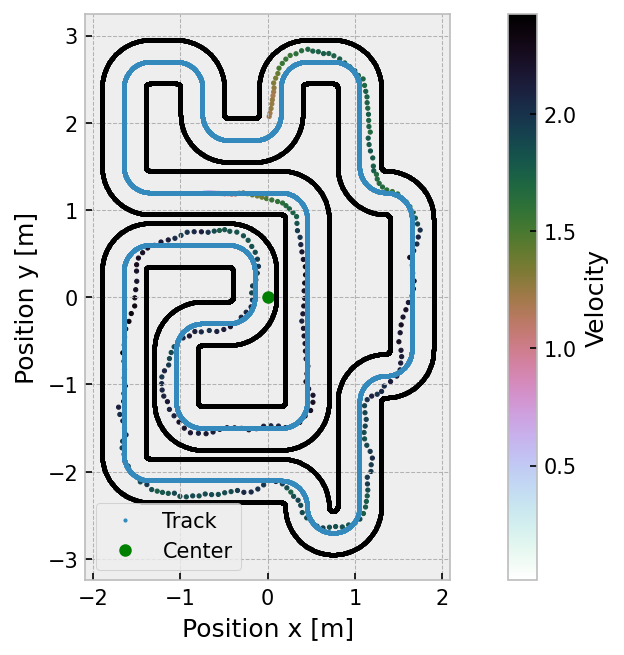

In [17]:
from matplotlib import cm


fig, ax = plt.subplots(1,1, figsize=(10,5), dpi=150)
gen.plotPoints(ax)
#gen.pointAtArcLength(0)
#gen.writePointsToYaml('../tracks/' + track_name + '.yaml', track_density)

custom_cmap = plt.get_cmap('cubehelix').reversed()
sct = ax.scatter(x_plot, y_plot, c=x_simulated[:,0,3].detach(), cmap=custom_cmap, s=4)

cbar = plt.colorbar(sct)
cbar.set_label('Velocity') 
#ax.plot(x_plot, y_plot)

#ax.scatter(x_plot[23:25], y_plot[23:25], color='red', s=4)

#ax.scatter(x_plot, y_plot, s=4, color='red')

print('x_init: ' + str(gen.xCoords[0]))
print('y_init: ' + str(gen.yCoords[0]))
print('yaw_init: ' + str(gen.tangentAngle[0]))
print('Total Arc Length: ' + str(gen.arcLength[-1]/2))
plt.show()

In [18]:
curvsp = dx.curv(x_simulated[:250,0,0]).detach()

Text(0, 0.5, '1-d*curve')

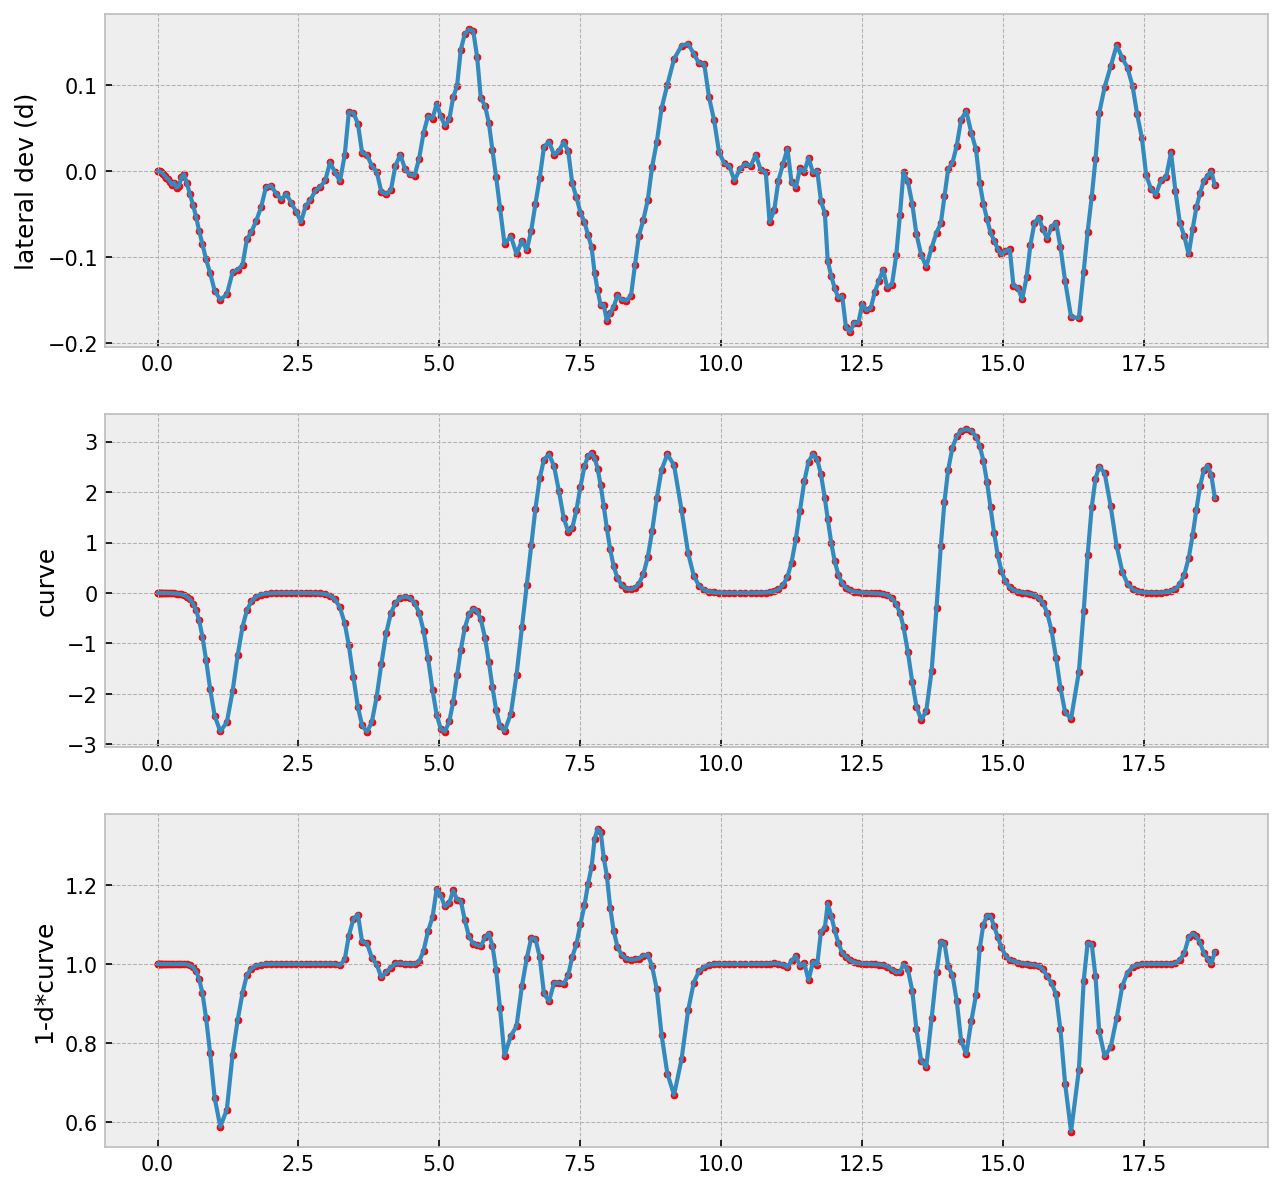

In [19]:
fig, axs = plt.subplots(3, 1, figsize=(10,10), dpi=150)
axs[0].plot(x_simulated[:250,0,0].detach(), 
         x_simulated[:250,0,1].detach())
axs[0].scatter(x_simulated[:250,0,0].detach(), 
         x_simulated[:250,0,1].detach(), s=10, color='red')
axs[0].set_ylabel('lateral dev (d)')

axs[1].plot(x_simulated[:250,0,0].detach(), 
         curvsp)
axs[1].scatter(x_simulated[:250,0,0].detach(), 
         curvsp, s=10, color='red')
axs[1].set_ylabel('curve')

axs[2].plot(x_simulated[:250,0,0].detach(), 
         1 - curvsp*x_simulated[:250,0,1].detach())
axs[2].scatter(x_simulated[:250,0,0].detach(), 
         1 - curvsp*x_simulated[:250,0,1].detach(), s=10, color='red')
axs[2].set_ylabel('1-d*curve')



In [15]:
from mpc import casadi_control
from importlib import reload
reload(casadi_control)

<module 'mpc.casadi_control' from '/home/rahel/differentiable_mpc/racingDiffMPC/mpc/casadi_control.py'>

In [16]:
control = casadi_control.CasadiControl(track_coord, params.numpy())

dc = 2 #number constraints
df = 2 #number of states we artificially added like sigma_0, sigma_diff
dx = n_state #number states taken from the dynamics (including penalties and sigma_o/sigma_diff)
du = n_ctrl #number control inputs

N_sim_total = 200
x_simulated = torch.zeros((N_sim_total,1,10))

x_simulated[0] = x_init_test[0]

q_penalty_batch = q_penalty.unsqueeze(0).repeat(N_test,1)
p_penalty_batch = p_penalty.unsqueeze(0).repeat(N_test,1)

for i in range(1,N_sim_total):

    x_sim = x_simulated[i-1]
    print('It:', i, 'x=', x_sim.detach().numpy().round(3))

    Q_test_batch, p_test_batch = inference_params(
        x_sim, track_coord, H_curve, model, 
        q_penalty_batch, p_penalty_batch, 
        N_test, mpc_T_test)
    
    test_q = torch.diag(Q_test_batch[0,0]).detach().numpy()
    test_p = p_test_batch[0,0].detach().numpy()

    sol = control.mpc_casadi_with_constraints_paj(
        test_q,test_p,x_sim.detach().numpy(),mpc_T_test,df,dc,dx,du)
    
    u_mpc_test = sol[-du*mpc_T_test:]
    x_mpc_test = sol[:-du*mpc_T_test]
    u_mpc_test = u_mpc_test.reshape(mpc_T_test,du)
    x_mpc_test = x_mpc_test.reshape(mpc_T_test+1,dx-dc-df)

    x_simulated[i,0,:6] = torch.tensor(x_mpc_test[1])
    x_simulated[i,0,6] = torch.tensor(x_simulated[i,0,0])
    x_simulated[i,0,7] = 0.

9
It: 1 x= [[ 0.01  0.   -0.    0.    0.1   0.    0.01  0.    0.    0.  ]]
curv start
curv end
curv start
curv end
curv start
curv end

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided start

CasADi - 2024-05-22 13:03:30 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:30 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:30 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
/tmp/ipykernel_106030/2092058619.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_simulated[i,0,6] = torch.tensor(x_simulated[i,0,0])
CasADi - 2024-05-22 13:03:30 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:3

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:03:30 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:30 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:30 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:31 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:31 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:31 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:03:31 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:31 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:31 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:03:31 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:31 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:31 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:31 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:31 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:31 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:03:32 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:32 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:32 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:32 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:32 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:32 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:03:32 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:32 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:32 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:32 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:32 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:32 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:03:33 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:33 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:33 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:33 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:33 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:33 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:03:33 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:33 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:33 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:34 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:34 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:34 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:03:34 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:34 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:34 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:03:34 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:34 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:34 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:34 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:34 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:34 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:03:35 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:35 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:35 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:35 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:35 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:35 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:03:35 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:35 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:35 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:03:35 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:35 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:35 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:36 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:36 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:36 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:03:36 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:36 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:36 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:36 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:36 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:36 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:03:36 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:36 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:36 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:37 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:37 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:37 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:03:37 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:37 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:37 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:03:37 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:37 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:37 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:38 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:38 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:38 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:03:38 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:38 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:38 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:38 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:38 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:38 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:03:38 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:38 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:38 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:39 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:39 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:39 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:03:39 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:39 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:39 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:39 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:39 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:39 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:03:39 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:39 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:39 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:40 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:40 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:40 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:03:40 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:40 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:40 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:03:40 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:40 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:40 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:41 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:41 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:41 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:03:41 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:41 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:41 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:03:41 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:41 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:41 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:41 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:41 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:41 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:03:42 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:42 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:42 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:42 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:42 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:42 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:03:42 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:42 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:42 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:42 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:42 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:42 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:03:43 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:43 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:43 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:03:43 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:43 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:43 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:43 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:43 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:43 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:03:43 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:43 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:43 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:03:44 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:44 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:44 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:44 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:44 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:44 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:03:44 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:44 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:44 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:45 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:45 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:45 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:03:45 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:45 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:45 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:45 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:45 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:45 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:03:45 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:45 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:45 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:46 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:46 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:46 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:03:46 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:46 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:46 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:46 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:46 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:46 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:03:46 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:46 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:46 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:47 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:47 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:47 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:03:47 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:47 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:47 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:47 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:47 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:47 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:03:47 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:47 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:47 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:48 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:48 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:48 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:03:48 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:48 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:48 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:48 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:48 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:48 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:03:48 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:48 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:48 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:03:49 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:49 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:49 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:03:49 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:49 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:49 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:49 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:49 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:49 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:03:49 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:49 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:49 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:50 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:50 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:50 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:03:50 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:50 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:50 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:50 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:50 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:50 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:03:51 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:51 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:51 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:51 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:51 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:51 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:03:51 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:51 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:51 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:03:51 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:51 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:51 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:52 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:52 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:52 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:03:52 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:52 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:52 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:03:52 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:52 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:52 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:03:52 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:52 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:52 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:53 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:53 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:53 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:03:53 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:53 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:53 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:53 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:53 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:53 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:03:53 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:53 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:53 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:54 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:54 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:54 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:03:54 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:54 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:54 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:03:54 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:54 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:54 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:54 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:54 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:54 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:03:55 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:55 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:55 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:03:55 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:55 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:55 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:03:55 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:55 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:55 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:55 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:55 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:55 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:03:56 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:56 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:56 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:56 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:56 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:56 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:03:56 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:56 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:56 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:56 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:56 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:56 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:03:57 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:57 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:57 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:57 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:57 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:57 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:03:57 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:57 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:57 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:58 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:58 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:58 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:03:58 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:58 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:58 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:58 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:58 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:58 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:03:58 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:58 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:58 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:59 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:59 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:59 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:03:59 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:59 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:59 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:59 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:59 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:59 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:03:59 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:59 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:03:59 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:04:00 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:00 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:00 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:04:00 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:00 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:00 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:04:00 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:00 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:00 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:04:01 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:01 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:01 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:04:01 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:01 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:01 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:04:01 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:01 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:01 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:04:01 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:01 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:01 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:04:02 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:02 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:02 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:02 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:02 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:02 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:04:02 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:02 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:02 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:04:02 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:02 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:02 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:04:03 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:03 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:03 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:04:03 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:03 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:03 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:03 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:03 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:03 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:04:04 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:04 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:04 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:04:04 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:04 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:04 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:04:04 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:04 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:04 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:04:04 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:04 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:04 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:05 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:05 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:05 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:04:05 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:05 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:05 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:04:05 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:05 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:05 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:05 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:05 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:05 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:04:06 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:06 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:06 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:04:06 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:06 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:06 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:04:06 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:06 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:06 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:06 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:06 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:06 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:04:07 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:07 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:07 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:04:07 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:07 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:07 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:07 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:07 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:07 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:04:07 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:07 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:07 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:08 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:08 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:08 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:04:08 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:08 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:08 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:04:08 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:08 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:08 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:08 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:08 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:08 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:04:09 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:09 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:09 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:04:09 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:09 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:09 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:09 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:09 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:09 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:04:09 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:09 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:09 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:10 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:10 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:10 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:04:10 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:10 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:10 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:04:10 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:10 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:10 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:10 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:10 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:10 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:04:11 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:11 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:11 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:11 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:11 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:11 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:04:11 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:11 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:11 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:11 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:11 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:11 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:04:12 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:12 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:12 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:04:12 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:12 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:12 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:12 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:12 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:12 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:04:13 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:13 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:13 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:13 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:13 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:13 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:04:13 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:13 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:13 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:13 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:13 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:13 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:04:14 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:14 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:14 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:04:14 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:14 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:14 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:04:14 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:14 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:14 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:14 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:14 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:14 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:04:15 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:15 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:15 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:15 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:15 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:15 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:04:15 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:15 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:15 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:04:15 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:15 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:15 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:04:16 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:16 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:16 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:16 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:16 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:16 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:04:16 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:16 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:16 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:04:16 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:16 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:16 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:04:17 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:17 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:17 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:17 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:17 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:17 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:04:17 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:17 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:17 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:18 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:18 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:18 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:04:18 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:18 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:18 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:18 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:18 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:18 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:04:18 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:18 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:18 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:19 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:19 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:19 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:04:19 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:19 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:19 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:19 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:19 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:19 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:04:19 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:19 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:19 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:04:20 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:20 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:20 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:20 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:20 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:20 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:04:20 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:20 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:20 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:04:20 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:20 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:20 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:04:21 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:21 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:21 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:04:21 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:21 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:21 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:21 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:21 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:21 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:04:22 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:22 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:22 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:22 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:22 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:22 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.c

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      831
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      575

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT  

CasADi - 2024-05-22 13:04:22 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:22 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 14 (row 79, col 3).") [.../casadi/core/oracle_function.cpp:325]
CasADi - 2024-05-22 13:04:22 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 79, col 0).") [.../casadi/core/oracle_function.cpp:325]


In [75]:
control = casadi_control.CasadiControl(track_coord, params.numpy())

dc = 3 #number constraints
df = 2 #number of states we artificially added like sigma_0, sigma_diff
dx = n_state #number states taken from the dynamics (including penalties and sigma_o/sigma_diff)
du = n_ctrl #number control inputs

N_sim_total = 200
x_simulated = torch.zeros((N_sim_total,1,9))

x_simulated[0] = x_init_test[0]

q_penalty_batch = q_penalty.unsqueeze(0).repeat(N_test,1)
p_penalty_batch = p_penalty.unsqueeze(0).repeat(N_test,1)

for i in range(1,N_sim_total):

    x_sim = x_simulated[i-1]
    print('It:', i, 'x=', x_sim.detach().numpy().round(3))

    Q_test_batch, p_test_batch = inference_params(
        x_sim, track_coord, H_curve, model, 
        q_penalty_batch, p_penalty_batch, 
        N_test, mpc_T_test)
    
    test_q = torch.diag(Q_test_batch[0,0]).detach().numpy()
    test_p = p_test_batch[0,0].detach().numpy()
    
    test_q[5] = 0.00001
    test_p[5] = -70.

    sol = control.mpc_casadi_with_constraints(
        test_q,test_p,x_sim.detach().numpy(),mpc_T_test,df,dc,dx,du)
    
    u_mpc_test = sol[-du*mpc_T_test:]
    x_mpc_test = sol[:-du*mpc_T_test]
    u_mpc_test = u_mpc_test.reshape(mpc_T_test,du)
    x_mpc_test = x_mpc_test.reshape(mpc_T_test+1,dx-dc-df)

    x_simulated[i,0,:4] = torch.tensor(x_mpc_test[1])
    x_simulated[i,0,4] = torch.tensor(x_simulated[i,0,0])
    x_simulated[i,0,5] = 0.

9
It: 1 x= [[ 0.01  0.   -0.    0.01  0.01  0.    0.    0.    0.  ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr  

/tmp/ipykernel_77055/370676835.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_simulated[i,0,4] = torch.tensor(x_simulated[i,0,0])


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.8199989e+01 1.30e-01 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.4783916e+01 3.70e-01 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0482795e+02 6.10e-01 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.9806899e+02 8.50e-01 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.2411147e+02 1.09e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.8255977e+02 1.33e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.7343193e+02 1.57e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  8.9836133e+02 1.81e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.1639727e+03 2.05e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.4909880e+03 2.29e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.9272284e+03 2.50e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.1880351e+03 2.50e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.4423211e+03 2.50e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.6741449e+03 2.50e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.8849874e+03 2.50e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.0815055e+03 2.50e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.4510496e+03 2.50e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.8077836e+03 2.50e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.1605193e+03 2.50e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.5123237e+03 2.58e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.8651158e+03 2.78e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.0427965e+03 2.88e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.2222784e+03 2.98e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.4048662e+03 3.09e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.5927077e+03 3.20e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.7892098e+03 3.31e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.9992378e+03 3.43e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.2280216e+03 3.56e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.4782955e+03 3.70e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.7405110e+03 3.85e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.9923257e+03 4.00e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.2216832e+03 4.13e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.4326888e+03 4.25e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.6330583e+03 4.36e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 118 -6.7885371e+03 4.93e-09 1.46e+10  -1.0 4.30e-09    -  1.00e+00 6.75e-02h  1
 119 -6.7885371e+03 4.93e-09 9.74e+11  -1.0 7.79e-08    -  1.00e+00 8.08e-05h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -6.7885371e+03 2.45e-09 2.36e+10  -1.0 2.76e-08    -  9.76e-01 1.00e+00f  1
 121 -6.7885371e+03 2.46e-09 1.41e+10  -1.0 8.91e-11    -  4.03e-01 1.00e+00f  1
 122 -6.7885371e+03 4.22e-09 1.40e+10  -1.0 2.00e-08    -  6.76e-03 1.00e+00f  1
 123 -6.7885371e+03 2.47e-09 8.18e+09  -1.0 4.80e-08    -  1.00e+00 4.15e-01h  1
 124 -6.7885371e+03 2.48e-09 1.34e+10  -1.0 2.81e-08    -  1.00e+00 1.17e-02h  1
 125 -6.7885371e+03 2.46e-09 8.04e+09  -1.0 2.44e-10    -  4.00e-01 1.00e+00f  1
 126 -6.7885371e+03 4.82e-09 7.99e+09  -1.0 2.68e-08    -  6.66e-03 1.00e+00f  1
 127 -6.7885371e+03 2.47e-09 4.12e+09  -1.0 5.48e-08    -  1.00e+00 4.86e-01h  1
 128 -6.7885371e+03 2.48e-09 8.00e+09  -1.0 2.80e-08    -  1.00e+00 1.16e-02h  1
 129 -6.7885371e+03 2.46e-09

It: 51 x= [[ 4.474 -0.188  0.185  2.5    4.474  0.     0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    

curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  8.0266284e+03 4.59e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  8.2306754e+03 4.70e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

It: 54 x= [[ 4.827 -0.188  0.213  2.5    4.827  0.     0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    

curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  8.6838498e+

It: 56 x= [[ 5.109 -0.188  0.4    2.5    5.109  0.     0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  9.2064551e+03 5.26e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

It: 58 x= [[ 5.405 -0.188  0.485  2.5    5.405  0.     0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  9.6911140e+03 5.54e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

It: 60 x= [[ 5.664 -0.188  0.359  2.5    5.664  0.     0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    

 142 -6.7339834e+03 2.45e-09 2.94e+09  -1.0 3.65e-08    -  1.00e+00 5.02e-02h  1
 143 -6.7339834e+03 2.57e-09 2.48e+09  -1.0 1.62e-09    -  1.56e-01 1.00e+00f  1
 144 -6.7339834e+03 2.45e-09 2.87e+09  -1.0 3.63e-08    -  1.00e+00 4.48e-02h  1
 145 -6.7339834e+03 2.55e-09 2.34e+09  -1.0 1.40e-09    -  1.84e-01 1.00e+00f  1
 146 -6.7339834e+03 2.45e-09 2.86e+09  -1.0 3.61e-08    -  1.00e+00 3.88e-02h  1
 147 -6.7339834e+03 2.53e-09 2.23e+09  -1.0 1.16e-09    -  2.20e-01 1.00e+00f  1
 148 -6.7339834e+03 2.45e-09 2.92e+09  -1.0 3.58e-08    -  1.00e+00 3.25e-02h  1
 149 -6.7339834e+03 2.53e-09 2.92e+09  -1.0 1.22e-07    -  6.59e-04 6.59e-04s 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150 -6.7339834e+03 2.47e-09 1.31e+09  -1.0 3.94e-10    -  5.51e-01 0.00e+00S 12
 151 -6.7339834e+03 2.47e-09 6.58e+09  -1.0 3.49e-08    -  1.00e+00 8.55e-04h  4
 152 -6.7339834e+03 2.69e-09 6.54e+09  -1.0 3.49e-08    -  6.15e-03 6.15e-03s 15
 153 -6.7339834e+03 2.46e-09

 121 -6.7610532e+03 2.45e-09 1.21e+11  -1.0 1.42e-09    -  1.81e-01 1.00e+00f  1
 122 -6.7610532e+03 1.85e-07 5.96e+11  -1.0 2.97e-07    -  4.50e-04 1.00e+00f  1
 123 -6.7610532e+03 1.23e-07 3.97e+11  -1.0 2.60e-07    -  1.00e+00 3.35e-01h  2
 124 -6.7610532e+03 9.16e-08 2.96e+11  -1.0 1.73e-07    -  1.00e+00 2.54e-01h  2
 125 -6.7610532e+03 8.37e-08 2.71e+11  -1.0 1.29e-07    -  1.00e+00 8.60e-02h  3
 126 -6.7610532e+03 8.07e-08 2.61e+11  -1.0 1.18e-07    -  1.00e+00 3.54e-02h  4
 127 -6.7610532e+03 8.06e-08 2.63e+11  -1.0 1.15e-07    -  1.00e+00 2.10e-03h  8
 128 -6.7610532e+03 5.64e-08 1.86e+11  -1.0 1.10e-07    -  1.00e+00 3.07e-01h  1
 129 -6.7610532e+03 2.66e-09 1.78e+11  -1.0 1.20e-07    -  4.23e-02 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 -6.7610532e+03 2.46e-09 1.65e+11  -1.0 4.05e-08    -  1.00e+00 7.69e-02h  1
 131 -6.7610532e+03 2.45e-09 1.24e+12  -1.0 1.37e-07    -  1.00e+00 7.46e-05h  5
 132 -6.7610532e+03 2.45e-09

It: 63 x= [[ 6.057 -0.188  0.365  2.5    6.057  0.     0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    

It: 64 x= [[ 6.2   -0.175  0.481  2.5    6.2    0.     0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    

curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.1078271e+

It: 66 x= [[ 6.437 -0.101  0.641  2.5    6.437  0.     0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    

It: 67 x= [[ 6.529 -0.05   0.638  2.5    6.529  0.     0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.1573284e+04 6.61e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

It: 69 x= [[6.698 0.056 0.536 2.5   6.698 0.    0.    0.    0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.1883601e+04 6.79e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

It: 71 x= [[6.897 0.146 0.283 2.5   6.897 0.    0.    0.    0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.2293144e+04 7.02e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

It: 73 x= [[ 7.172  0.188 -0.18   2.5    7.172  0.     0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    

 148 -6.9002632e+03 1.25e-08 3.14e-09  -9.0 8.49e-16    -  1.00e+00 1.00e+00   0
 149 -6.9002632e+03 1.25e-08 3.14e-09  -9.0 8.47e-16    -  1.00e+00 1.00e+00   0
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150 -6.9002632e+03 1.25e-08 3.14e-09  -9.0 8.58e-16    -  1.00e+00 1.00e+00   0
 151 -6.9002632e+03 1.25e-08 3.14e-09  -9.0 8.39e-16    -  1.00e+00 1.00e+00   0

Number of Iterations....: 151

                                   (scaled)                 (unscaled)
Objective...............:  -6.9002631978899199e+03   -6.9002631978899199e+03
Dual infeasibility......:   3.1449456372456552e-09    3.1449456372456552e-09
Constraint violation....:   1.2499997925630169e-08    1.2499997925630169e-08
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.2794514418553799e-09    1.2794514418553799e-09
Overall NLP error.......:   1.2499997925630169e-08    1.2499997925630169e-08


Number of objective function

 134 -6.8515210e+03 8.10e-03 5.89e+02  -1.0 5.64e-01    -  1.03e-01 9.90e-01f  1
 135 -6.8539851e+03 3.26e-03 1.24e+03  -1.0 1.24e-01    -  8.25e-01 6.13e-01f  1
 136 -6.8542898e+03 3.16e-03 1.79e+02  -1.0 1.30e-01    -  1.00e+00 9.89e-01f  1
 137 -6.8545704e+03 5.33e-04 1.22e+05  -1.0 4.45e-02    -  1.00e+00 9.21e-01h  1
 138 -6.8545815e+03 4.72e-04 1.46e+08  -1.0 1.89e-02    -  1.00e+00 1.16e-01h  1
 139 -6.8545817e+03 4.71e-04 8.31e+10  -1.0 1.95e-02    -  1.00e+00 2.43e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140 -6.8546563e+03 7.24e-05 6.10e+08  -1.0 1.99e-02    -  9.93e-01 1.00e+00f  1
 141 -6.8546603e+03 2.09e-07 3.14e-06  -1.0 2.82e-04    -  1.00e+00 1.00e+00f  1
In iteration 141, 1 Slack too small, adjusting variable bound
 142 -6.8547523e+03 2.04e-07 8.68e+09  -8.6 3.42e-02    -  9.82e-01 2.41e-02f  1
In iteration 142, 1 Slack too small, adjusting variable bound
 143 -6.8581267e+03 6.24e-05 1.98e+08  -8.6 3.35e-02    -  9.77e-0

 136 -6.8335652e+03 1.25e-08 3.14e-09  -9.0 8.57e-16    -  1.00e+00 1.00e+00   0
 137 -6.8335652e+03 1.25e-08 3.14e-09  -9.0 8.57e-16    -  1.00e+00 1.00e+00   0
 138 -6.8335652e+03 1.25e-08 3.14e-09  -9.0 8.57e-16    -  1.00e+00 1.00e+00   0
 139 -6.8335652e+03 1.25e-08 3.14e-09  -9.0 8.57e-16    -  1.00e+00 1.00e+00   0
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140 -6.8335652e+03 1.25e-08 3.14e-09  -9.0 8.56e-16    -  1.00e+00 1.00e+00   0
 141 -6.8335652e+03 1.25e-08 3.14e-09  -9.0 8.57e-16    -  1.00e+00 1.00e+00   0
 142 -6.8335652e+03 1.25e-08 3.14e-09  -9.0 8.57e-16    -  1.00e+00 1.00e+00   0
 143 -6.8335652e+03 1.25e-08 3.14e-09  -9.0 8.56e-16    -  1.00e+00 1.00e+00   0
 144 -6.8335652e+03 1.25e-08 3.14e-09  -9.0 8.56e-16    -  1.00e+00 1.00e+00   0
 145 -6.8335652e+03 1.25e-08 3.14e-09  -9.0 8.56e-16    -  1.00e+00 1.00e+00   0
 146 -6.8335652e+03 1.25e-08 3.14e-09  -9.0 8.56e-16    -  1.00e+00 1.00e+00   0
 147 -6.8335652e+03 1.25e-08

 134 -6.7864545e+03 2.72e-02 5.64e+02  -1.0 4.69e-01    -  5.54e-02 9.88e-01f  1
 135 -6.7889210e+03 7.32e-03 3.94e+03  -1.0 9.84e-02    -  5.02e-01 7.44e-01f  1
 136 -6.7898723e+03 4.61e-03 7.71e+02  -1.0 1.67e-01    -  1.00e+00 9.87e-01f  1
 137 -6.7898972e+03 1.17e-03 1.54e+06  -1.0 2.59e-02    -  1.00e+00 7.56e-01h  1
 138 -6.7898982e+03 1.13e-03 8.03e+08  -1.0 6.36e-03    -  1.00e+00 3.11e-02h  1
 139 -6.7899260e+03 5.32e-06 8.31e-04  -1.0 6.20e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140 -6.7900162e+03 5.20e-06 1.16e+09  -5.7 3.42e-02    -  9.67e-01 2.42e-02f  1
 141 -6.7930621e+03 4.74e-05 3.27e+07  -5.7 3.34e-02    -  9.72e-01 8.38e-01f  1
 142 -6.7935739e+03 6.59e-06 3.55e+00  -5.7 6.44e-03    -  1.00e+00 8.95e-01f  1
 143 -6.7936266e+03 9.52e-07 4.73e+00  -5.7 2.99e-03    -  1.00e+00 8.60e-01f  1
 144 -6.7936344e+03 1.98e-07 1.92e+00  -5.7 1.41e-03    -  1.00e+00 9.43e-01f  1
 145 -6.7936347e+03 1.25e-08

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 -6.4255981e+03 2.94e-01 3.01e+02  -1.0 3.00e+00    -  1.16e-02 2.10e-01f  1
 131 -6.4412586e+03 2.80e-01 2.87e+02  -1.0 2.37e+00    -  4.30e-02 4.79e-02f  1
 132 -6.6726103e+03 6.97e-02 2.94e+02  -1.0 2.26e+00    -  2.41e-01 8.00e-01f  1
 133 -6.7368699e+03 6.55e-03 2.57e+02  -1.0 4.52e-01    -  2.33e-01 9.90e-01f  1
 134 -6.7391215e+03 1.05e-03 2.71e+03  -1.0 5.52e-02    -  4.76e-01 8.41e-01f  1
 135 -6.7393565e+03 1.51e-03 5.38e+02  -1.0 9.62e-02    -  1.00e+00 9.88e-01f  1
 136 -6.7393284e+03 3.05e-04 9.06e+05  -1.0 1.14e-02    -  1.00e+00 8.06e-01h  1
 137 -6.7393285e+03 2.93e-04 5.51e+08  -1.0 2.38e-03    -  1.00e+00 4.15e-02h  1
 138 -6.7393312e+03 7.49e-07 1.42e-04  -1.0 2.28e-03    -  1.00e+00 1.00e+00f  1
 139 -6.7394573e+03 7.40e-07 7.24e+08  -5.7 3.42e-02    -  9.68e-01 3.45e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140 -6.7424341e+03 2.17e-05

In iteration 120, 1 Slack too small, adjusting variable bound
 121 -6.7074159e+03 1.25e-08 1.06e-08  -9.0 8.79e-16    -  1.00e+00 1.00e+00   0
In iteration 121, 1 Slack too small, adjusting variable bound
 122 -6.7074159e+03 1.25e-08 1.92e-08  -9.0 8.89e-16    -  1.00e+00 1.00e+00   0
In iteration 122, 1 Slack too small, adjusting variable bound
 123 -6.7074159e+03 1.25e-08 1.06e-08  -9.0 8.87e-16    -  1.00e+00 1.00e+00   0
In iteration 123, 1 Slack too small, adjusting variable bound
 124 -6.7074159e+03 1.25e-08 1.92e-08  -9.0 8.88e-16    -  1.00e+00 1.00e+00   0
In iteration 124, 1 Slack too small, adjusting variable bound
 125 -6.7074159e+03 1.25e-08 1.06e-08  -9.0 8.88e-16    -  1.00e+00 1.00e+00   0
In iteration 125, 1 Slack too small, adjusting variable bound
 126 -6.7074159e+03 1.25e-08 1.92e-08  -9.0 8.88e-16    -  1.00e+00 1.00e+00   0
In iteration 126, 1 Slack too small, adjusting variable bound
 127 -6.7074159e+03 1.25e-08 1.06e-08  -9.0 8.89e-16    -  1.00e+00 1.00e+00   0

 118 -6.5840168e+03 9.10e-02 2.87e+02  -1.0 1.82e+00    -  1.81e-01 6.11e-01f  1
 119 -6.6827677e+03 2.06e-02 1.48e+02  -1.0 7.08e-01    -  6.32e-01 9.02e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -6.6996263e+03 9.60e-04 2.64e+02  -1.0 7.61e-02    -  4.45e-01 9.90e-01f  1
 121 -6.6997418e+03 3.13e-04 5.94e+02  -1.0 4.22e-02    -  1.00e+00 9.88e-01h  1
 122 -6.6997702e+03 6.41e-05 9.70e+05  -1.0 5.97e-03    -  1.00e+00 8.00e-01h  1
 123 -6.6997707e+03 6.16e-05 5.77e+08  -1.0 1.72e-03    -  1.00e+00 4.00e-02h  1
 124 -6.6997707e+03 6.15e-05 1.12e+12  -1.0 1.67e-03    -  1.00e+00 5.60e-04h  1
 125 -6.6997822e+03 2.13e-07 1.05e+10  -1.0 1.66e-03    -  9.91e-01 1.00e+00f  1
 126 -6.6997824e+03 1.69e-07 1.43e-06  -1.0 2.93e-06    -  1.00e+00 1.00e+00f  1
 127 -6.7029263e+03 3.27e-05 1.01e+01  -8.6 3.42e-02    -  9.64e-01 9.06e-01f  1
 128 -6.7032358e+03 5.64e-06 7.12e+00  -8.6 6.65e-03    -  9.90e-01 9.50e-01f  1
 129 -6.7032527e+03 1.14e-06

  96 -4.8152589e+03 1.52e+00 4.89e+02  -1.0 1.18e+01    -  4.79e-02 2.91e-02f  1
  97 -4.8751023e+03 1.48e+00 4.77e+02  -1.0 1.14e+01    -  3.09e-02 2.54e-02f  1
  98 -5.0312095e+03 1.37e+00 4.43e+02  -1.0 1.12e+01    -  3.67e-02 7.05e-02f  1
  99 -5.0341804e+03 1.37e+00 4.43e+02  -1.0 1.04e+01    -  7.18e-02 1.44e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 -5.1636615e+03 1.28e+00 4.13e+02  -1.0 1.04e+01    -  6.02e-03 6.64e-02f  1
 101 -5.1808515e+03 1.27e+00 4.10e+02  -1.0 9.67e+00    -  1.59e-02 8.57e-03f  1
 102 -5.2089055e+03 1.25e+00 4.04e+02  -1.0 9.57e+00    -  2.09e-02 1.42e-02f  1
 103 -5.2255251e+03 1.24e+00 4.01e+02  -1.0 9.39e+00    -  7.72e-02 9.29e-03f  1
 104 -5.2976100e+03 1.19e+00 3.84e+02  -1.0 9.08e+00    -  3.12e-03 4.11e-02f  1
 105 -5.3002332e+03 1.19e+00 3.83e+02  -1.0 7.55e+00    -  3.27e-03 1.49e-03f  1
 106 -5.3303993e+03 1.17e+00 3.77e+02  -1.0 7.06e+00    -  3.00e-02 1.74e-02f  1
 107 -5.3460270e+03 1.16e+00

  91 -6.7211602e+03 1.07e-03 4.65e+07  -1.0 2.67e-02    -  1.00e+00 2.53e-01h  1
  92 -6.7216365e+03 1.18e-04 4.67e-02  -1.0 2.40e-02    -  1.00e+00 1.00e+00f  1
  93 -6.7224636e+03 8.96e-05 3.63e+07  -5.7 3.42e-02    -  9.56e-01 2.46e-01f  1
In iteration 93, 1 Slack too small, adjusting variable bound
  94 -6.7224637e+03 8.96e-05 1.39e+12  -5.7 2.59e-02    -  9.67e-01 4.55e-05f  1
  95 -6.7243262e+03 5.48e-05 2.71e+01  -5.7 2.59e-02    -  1.00e+00 7.31e-01f  1
  96 -6.7249278e+03 1.29e-05 2.57e+00  -5.7 7.33e-03    -  1.00e+00 9.24e-01f  1
  97 -6.7249748e+03 4.56e-07 5.35e-02  -5.7 2.68e-03    -  1.00e+00 9.98e-01f  1
  98 -6.7249757e+03 5.78e-08 4.45e+00  -8.6 8.77e-04    -  1.00e+00 9.75e-01h  1
  99 -6.7249759e+03 1.25e-08 1.23e-06  -8.6 1.73e-04    -  1.00e+00 1.00e+00f  1
In iteration 99, 1 Slack too small, adjusting variable bound
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 -6.7249759e+03 1.25e-08 1.92e-08  -9.0 6.15e-06    -  1.00e+00 

  91 -6.3515036e+03 1.09e-02 1.75e+05  -1.0 1.06e+00    -  1.45e-02 1.09e-01f  1
  92 -6.3578860e+03 1.08e-02 2.28e+05  -1.0 8.63e-01    -  1.70e-01 1.50e-02f  1
  93 -6.4685903e+03 1.10e-02 3.53e+05  -1.0 8.95e-01    -  1.60e-02 2.15e-01f  1
  94 -6.4723837e+03 1.09e-02 7.15e+04  -1.0 6.70e-01    -  1.29e-01 1.07e-02f  1
  95 -6.6120510e+03 1.33e-02 8.07e+05  -1.0 8.33e-01    -  1.28e-01 3.60e-01f  1
  96 -6.6142703e+03 1.31e-02 3.50e+04  -1.0 6.75e-01    -  1.27e-01 8.96e-03f  1
  97 -6.7106980e+03 1.19e-02 1.85e+06  -1.0 7.88e-01    -  2.37e-01 5.08e-01f  1
  98 -6.7116623e+03 1.18e-02 1.32e+07  -1.0 5.11e-01    -  7.26e-01 1.26e-02f  1
  99 -6.7339961e+03 1.20e-02 1.36e+07  -1.0 5.78e-01    -  7.38e-01 5.29e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 -6.7366001e+03 1.05e-02 2.16e+02  -1.0 3.16e-01    -  1.00e+00 1.66e-01f  1
 101 -6.7367686e+03 9.65e-03 1.66e+08  -2.5 1.28e-01    -  5.11e-01 7.81e-02f  1
 102 -6.7367689e+03 9.65e-03

 107 -5.4324074e+03 1.06e+00 6.35e+02  -1.0 8.94e+00    -  3.10e-03 1.33e-01f  1
 108 -5.5572137e+03 9.62e-01 5.89e+02  -1.0 7.78e+00    -  7.88e-02 9.46e-02f  1
 109 -5.6990439e+03 8.47e-01 5.26e+02  -1.0 7.04e+00    -  9.39e-02 1.20e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 -5.7349461e+03 8.17e-01 4.91e+02  -1.0 6.17e+00    -  2.62e-01 3.47e-02f  1
 111 -5.7374948e+03 8.15e-01 4.90e+02  -1.0 4.37e+00    -  3.61e-03 2.64e-03f  1
 112 -6.0503790e+03 5.21e-01 3.33e+02  -1.0 5.97e+00    -  9.89e-03 3.61e-01f  1
 113 -6.1913720e+03 4.10e-01 2.12e+02  -1.0 3.82e+00    -  1.37e-01 2.14e-01f  1
 114 -6.1938189e+03 4.08e-01 2.18e+02  -1.0 2.85e+00    -  7.93e-02 4.25e-03f  1
 115 -6.4053128e+03 2.38e-01 2.53e+03  -1.0 3.00e+00    -  5.58e-03 4.15e-01f  1
 116 -6.4851940e+03 1.82e-01 1.94e+03  -1.0 1.75e+00    -  1.69e-01 2.36e-01f  1
 117 -6.6993057e+03 9.38e-02 4.27e+02  -1.0 1.34e+00    -  3.53e-01 9.25e-01f  1
 118 -6.7322397e+03 8.88e-03

  93 -5.6856616e+03 7.36e-02 8.08e+03  -1.0 1.47e-01   2.7 2.63e-01 2.00e-01f  1
  94 -5.6892490e+03 7.14e-02 1.00e+04  -1.0 1.72e-01   3.2 3.97e-01 3.04e-02f  1
  95 -5.8141088e+03 9.19e-03 8.58e+02  -1.0 1.72e-01   2.7 7.38e-01 8.71e-01f  1
  96 -5.9116180e+03 8.11e-03 3.13e+03  -1.0 3.77e-01   2.2 8.46e-03 6.93e-01f  1
  97 -5.9643325e+03 8.90e-03 3.07e+03  -1.0 1.00e+00    -  5.29e-02 1.70e-01f  1
  98 -6.5948291e+03 7.22e-02 3.58e+03  -1.0 1.34e+00    -  1.21e-02 6.78e-01f  1
  99 -6.5985796e+03 7.07e-02 2.66e+03  -1.0 7.36e-01    -  2.41e-01 2.17e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 -6.6298195e+03 4.69e-02 2.58e+03  -1.0 5.26e-01    -  6.03e-02 3.53e-01f  1
 101 -6.6306822e+03 4.59e-02 2.20e+03  -1.0 3.82e-01    -  1.40e-01 2.08e-02f  1
 102 -6.6461234e+03 3.26e-02 2.67e+03  -1.0 4.31e-01    -  7.16e-02 2.91e-01f  1
 103 -6.6634294e+03 2.36e-02 5.24e+03  -1.0 4.24e-01    -  3.73e-02 2.73e-01f  1
 104 -6.6670754e+03 2.26e-02

 117 -5.6450682e+03 8.38e-01 3.86e+02  -1.0 4.00e+00    -  4.97e-03 1.70e-03f  1
 118 -5.7735462e+03 7.31e-01 3.18e+02  -1.0 5.96e+00    -  7.50e-03 1.27e-01f  1
 119 -6.0428571e+03 5.04e-01 2.46e+02  -1.0 5.21e+00    -  2.31e-01 3.10e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -6.1638269e+03 4.20e-01 2.12e+02  -1.0 3.60e+00    -  7.97e-02 1.67e-01f  1
 121 -6.1652635e+03 4.19e-01 2.12e+02  -1.0 2.68e+00    -  4.94e-02 2.24e-03f  1
 122 -6.2974817e+03 3.26e-01 2.63e+02  -1.0 3.00e+00    -  1.41e-02 2.22e-01f  1
 123 -6.4769953e+03 1.94e-01 1.81e+02  -1.0 2.33e+00    -  3.76e-01 4.06e-01f  1
 124 -6.6340063e+03 7.42e-02 3.15e+02  -1.0 1.39e+00    -  2.99e-01 6.17e-01f  1
 125 -6.7230732e+03 1.63e-02 3.67e+02  -1.0 5.31e-01    -  3.96e-01 9.34e-01f  1
 126 -6.7300502e+03 2.78e-03 2.37e+02  -1.0 1.51e-01    -  5.91e-01 8.31e-01f  1
 127 -6.7308756e+03 1.32e-03 1.11e+03  -1.0 9.66e-02    -  7.96e-01 9.90e-01f  1
 128 -6.7308390e+03 8.85e-05

 116 -6.7097007e+03 1.57e-04 1.12e+02  -1.0 2.98e-02    -  1.00e+00 9.89e-01h  1
 117 -6.7097928e+03 1.66e-05 6.29e+04  -1.0 7.71e-03    -  1.00e+00 9.41e-01h  1
 118 -6.7097946e+03 1.39e-05 9.42e+07  -1.0 1.30e-03    -  1.00e+00 1.59e-01h  1
 119 -6.7097946e+03 1.39e-05 6.58e+10  -1.0 1.11e-03    -  1.00e+00 2.03e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -6.7098038e+03 1.68e-07 5.07e+08  -1.0 1.10e-03    -  9.92e-01 1.00e+00f  1
 121 -6.7098040e+03 2.00e-07 2.98e-08  -1.0 3.64e-06    -  1.00e+00 1.00e+00f  1
In iteration 121, 1 Slack too small, adjusting variable bound
 122 -6.7099164e+03 1.94e-07 4.61e+09  -8.6 3.42e-02    -  9.76e-01 3.03e-02f  1
 123 -6.7125491e+03 5.15e-05 1.13e+08  -8.6 3.32e-02    -  9.75e-01 7.63e-01f  1
 124 -6.7131985e+03 9.62e-06 3.18e+06  -8.6 9.83e-03    -  9.72e-01 9.66e-01f  1
In iteration 124, 1 Slack too small, adjusting variable bound
 125 -6.7132159e+03 2.42e-07 4.86e+04  -8.6 2.62e-03    -  9.85e-0

  88 -5.0131936e+03 5.24e-01 1.89e+05  -1.0 1.02e+00   4.5 8.81e-02 1.18e-03f  1
  89 -5.0736309e+03 4.45e-01 1.61e+05  -1.0 2.98e+00   4.0 8.34e-02 1.51e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 -5.0745251e+03 4.44e-01 1.60e+05  -1.0 1.64e+00   4.5 4.19e-01 2.73e-03f  1
  91 -5.0745831e+03 4.42e-01 1.60e+05  -1.0 3.77e+00   4.0 1.91e-02 2.84e-03h  1
  92 -5.3163777e+03 2.60e-01 9.38e+04  -1.0 7.12e-01   4.4 1.80e-04 4.11e-01f  1
  93 -5.3208731e+03 2.57e-01 1.03e+05  -1.0 3.48e-01   4.8 5.92e-01 1.34e-02f  1
  94 -5.3262849e+03 2.34e-01 1.45e+05  -1.0 1.37e+00   4.4 9.45e-01 8.83e-02f  1
  95 -5.3271280e+03 2.33e-01 1.18e+05  -1.0 4.29e-01   4.8 1.00e+00 3.30e-03f  1
  96 -5.3914693e+03 1.85e-01 1.31e+05  -1.0 3.90e-01   4.3 1.00e+00 2.09e-01f  1
  97 -5.5166242e+03 8.61e-02 9.56e+04  -1.0 2.38e-01   4.7 1.00e+00 5.33e-01f  1
  98 -5.5170688e+03 8.56e-02 1.22e+05  -1.0 1.89e-01   5.2 8.28e-01 6.72e-03h  1
  99 -5.5311965e+03 7.58e-02

 108 -6.6133873e+03 1.68e-04 2.56e+08  -1.0 7.49e-03    -  1.00e+00 7.57e-02h  1
 109 -6.6134181e+03 7.81e-06 3.03e-03  -1.0 7.47e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 -6.6136463e+03 7.48e-06 2.85e+08  -5.7 3.42e-02    -  9.80e-01 6.88e-02f  1
 111 -6.6162404e+03 5.26e-05 9.04e+06  -5.7 3.19e-02    -  9.68e-01 8.56e-01f  1
 112 -6.6165208e+03 1.30e-05 6.24e+00  -5.7 6.33e-03    -  1.00e+00 8.16e-01f  1
 113 -6.6165808e+03 3.70e-07 1.09e-01  -5.7 1.61e-03    -  1.00e+00 9.97e-01f  1
 114 -6.6165809e+03 1.25e-08 3.60e-08  -5.7 2.48e-05    -  1.00e+00 1.00e+00h  1
 115 -6.6165810e+03 1.25e-08 3.14e-09  -9.0 8.21e-07    -  1.00e+00 1.00e+00h  1
 116 -6.6165810e+03 1.25e-08 4.31e-09  -9.0 1.88e-11    -  1.00e+00 1.00e+00h  1
 117 -6.6165810e+03 1.25e-08 3.14e-09  -9.0 8.70e-16    -  1.00e+00 1.00e+00   0
 118 -6.6165810e+03 1.25e-08 4.31e-09  -9.0 8.70e-16    -  1.00e+00 1.00e+00   0
 119 -6.6165810e+03 1.25e-08

  97 -6.3600960e+03 1.56e-01 8.92e+02  -1.0 1.19e+00    -  1.47e-02 1.78e-01f  1
  98 -6.4030153e+03 1.33e-01 7.81e+02  -1.0 1.05e+00    -  1.39e-01 1.48e-01f  1
  99 -6.5770312e+03 3.05e-02 2.72e+02  -1.0 8.87e-01    -  1.00e+00 8.09e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 -6.5764583e+03 1.56e-03 2.95e+00  -1.0 1.69e-01    -  1.00e+00 9.90e-01h  1
 101 -6.5755918e+03 2.25e-05 2.16e+02  -1.0 1.26e-02    -  1.00e+00 9.89e-01h  1
 102 -6.5755834e+03 2.19e-06 1.92e+05  -1.0 2.05e-04    -  1.00e+00 9.03e-01h  1
 103 -6.5755833e+03 1.99e-06 1.97e+08  -1.0 2.02e-05    -  1.00e+00 9.27e-02h  1
 104 -6.5755826e+03 6.85e-08 1.56e-08  -1.0 1.83e-05    -  1.00e+00 1.00e+00f  1
 105 -6.5758554e+03 3.12e-07 2.07e+08  -5.7 3.42e-02    -  9.76e-01 8.61e-02f  1
 106 -6.5782937e+03 4.83e-05 3.57e+06  -5.7 3.54e-02    -  9.83e-01 8.61e-01f  1
 107 -6.5785968e+03 7.54e-06 1.61e+00  -5.7 9.95e-03    -  1.00e+00 9.52e-01f  1
 108 -6.5786097e+03 3.36e-07

  91 -4.9947160e+03 4.87e-01 2.37e+05  -1.0 6.24e-01   4.0 2.55e-03 2.41e-03f  1
  92 -5.0946133e+03 4.29e-01 2.04e+05  -1.0 6.20e-01   4.4 1.55e-01 1.19e-01f  1
  93 -5.2860090e+03 3.16e-01 1.26e+05  -1.0 5.30e-01   4.0 1.08e-02 2.65e-01f  1
  94 -5.2879048e+03 3.14e-01 1.25e+05  -1.0 3.83e-01   4.4 2.40e-01 3.68e-03f  1
  95 -5.4610165e+03 2.10e-01 8.57e+04  -1.0 3.89e-01   3.9 3.70e-01 3.31e-01f  1
  96 -5.4626250e+03 2.09e-01 1.60e+05  -1.0 2.64e-01   4.3 7.33e-01 5.23e-03f  1
  97 -5.6235047e+03 1.03e-01 7.33e+04  -1.0 2.95e-01   3.9 4.32e-01 5.07e-01f  1
  98 -5.6747683e+03 7.43e-02 6.36e+04  -1.0 3.69e-01   3.4 1.52e-01 2.80e-01f  1
  99 -5.6755764e+03 7.37e-02 8.06e+04  -1.0 1.12e-01   3.8 5.26e-01 8.08e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 -5.7154764e+03 5.18e-02 4.60e+04  -1.0 1.28e-01   3.3 9.41e-03 2.97e-01f  1
 101 -5.7870740e+03 2.99e-03 4.26e+03  -1.0 8.63e-02   3.8 8.88e-01 9.90e-01f  1
 102 -5.8241483e+03 7.77e-05

 117 -4.8001636e+03 1.38e+00 8.46e+02  -1.0 9.09e+00    -  8.48e-03 2.26e-02f  1
 118 -4.8014410e+03 1.38e+00 8.45e+02  -1.0 4.25e+00    -  3.59e-03 6.18e-04f  1
 119 -4.9088599e+03 1.30e+00 7.96e+02  -1.0 8.94e+00    -  2.70e-03 5.35e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -5.0750594e+03 1.19e+00 7.24e+02  -1.0 8.49e+00    -  6.47e-02 8.86e-02f  1
 121 -5.2824876e+03 1.04e+00 6.36e+02  -1.0 7.74e+00    -  1.26e-01 1.22e-01f  1
 122 -5.2965150e+03 1.03e+00 6.22e+02  -1.0 6.79e+00    -  3.07e-02 9.01e-03f  1
 123 -5.4608053e+03 9.19e-01 5.60e+02  -1.0 6.73e+00    -  6.00e-02 1.11e-01f  1
 124 -5.4627417e+03 9.18e-01 5.60e+02  -1.0 5.07e+00    -  1.89e-02 1.47e-03f  1
 125 -5.5634042e+03 8.45e-01 5.14e+02  -1.0 5.97e+00    -  3.84e-03 8.01e-02f  1
 126 -5.6871069e+03 7.51e-01 4.57e+02  -1.0 5.51e+00    -  1.49e-01 1.11e-01f  1
 127 -5.8870942e+03 5.93e-01 3.60e+02  -1.0 4.90e+00    -  7.13e-02 2.11e-01f  1
 128 -6.0443856e+03 4.60e-01

 109 -5.6642683e+03 7.57e-01 2.35e+02  -1.0 5.30e+00    -  1.90e-02 7.80e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 -5.9639895e+03 5.00e-01 5.36e+02  -1.0 4.89e+00    -  1.68e-02 3.40e-01f  1
 111 -5.9707486e+03 4.94e-01 5.51e+02  -1.0 3.22e+00    -  2.77e-02 1.12e-02f  1
 112 -6.0098154e+03 4.63e-01 5.10e+02  -1.0 3.18e+00    -  1.37e-01 6.30e-02f  1
 113 -6.0108359e+03 4.62e-01 5.11e+02  -1.0 1.86e+00    -  1.20e-02 1.78e-03f  1
 114 -6.0397074e+03 4.38e-01 4.82e+02  -1.0 2.99e+00    -  2.66e-02 5.14e-02f  1
 115 -6.2207427e+03 2.70e-01 5.95e+02  -1.0 2.84e+00    -  6.25e-02 3.84e-01f  1
 116 -6.3280887e+03 1.80e-01 3.30e+02  -1.0 1.75e+00    -  1.33e-01 3.35e-01f  1
 117 -6.5056845e+03 7.29e-02 6.70e+02  -1.0 1.16e+00    -  2.55e-01 8.40e-01f  1
 118 -6.5282814e+03 4.18e-02 3.15e+02  -1.0 4.07e-01    -  2.01e-01 4.26e-01f  1
 119 -6.5433472e+03 2.37e-02 1.74e+02  -1.0 1.30e-01    -  5.71e-01 4.38e-01f  1
iter    objective    inf_pr 

  98 -6.2880699e+03 2.09e-02 3.08e+03  -1.0 4.96e-01    -  9.04e-02 8.39e-01f  1
  99 -6.3029906e+03 8.21e-03 2.04e+04  -1.0 3.11e-01    -  1.55e-01 9.96e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 -6.3449358e+03 7.97e-03 5.71e+04  -1.0 2.48e+00    -  1.31e-02 2.85e-02f  1
 101 -6.3496239e+03 7.93e-03 1.88e+05  -1.0 1.83e+00    -  1.07e-01 6.35e-03f  1
 102 -6.3911559e+03 8.00e-03 2.60e+05  -1.0 1.80e+00    -  9.47e-02 5.86e-02f  1
 103 -6.3951523e+03 7.91e-03 3.71e+05  -1.0 1.11e+00    -  6.59e-02 1.34e-02f  1
 104 -6.4750540e+03 1.95e-02 6.09e+04  -1.0 1.33e+00    -  3.68e-03 1.77e-01f  1
 105 -6.4762702e+03 1.94e-02 3.33e+05  -1.0 7.24e-01    -  1.80e-01 5.16e-03f  1
 106 -6.5316979e+03 2.27e-02 1.94e+05  -1.0 9.02e-01    -  9.61e-03 2.36e-01f  1
 107 -6.5326687e+03 2.25e-02 8.11e+05  -1.0 4.35e-01    -  4.81e-01 1.08e-02f  1
 108 -6.5547079e+03 1.77e-02 6.98e+05  -1.0 4.50e-01    -  3.66e-01 2.82e-01f  1
 109 -6.5604029e+03 1.41e-02

 113 -3.7415474e+03 2.13e+00 2.71e+02  -1.0 1.45e+01    -  2.03e-02 7.25e-02f  1
 114 -3.8363619e+03 2.06e+00 2.59e+02  -1.0 1.34e+01    -  1.64e-02 3.23e-02f  1
 115 -4.0508247e+03 1.90e+00 2.35e+02  -1.0 1.30e+01    -  4.30e-02 7.75e-02f  1
 116 -4.0536880e+03 1.90e+00 2.33e+02  -1.0 9.68e+00    -  1.03e-02 1.04e-03f  1
 117 -4.1208314e+03 1.85e+00 2.36e+02  -1.0 1.19e+01    -  1.98e-03 2.51e-02f  1
 118 -4.3006675e+03 1.72e+00 2.77e+02  -1.0 1.17e+01    -  2.57e-02 6.94e-02f  1
 119 -4.5342185e+03 1.56e+00 2.75e+02  -1.0 1.09e+01    -  4.29e-02 9.40e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -4.6823967e+03 1.46e+00 2.65e+02  -1.0 9.83e+00    -  4.12e-02 6.30e-02f  1
 121 -4.7405698e+03 1.42e+00 4.31e+02  -1.0 9.17e+00    -  7.94e-02 2.59e-02f  1
 122 -4.7424937e+03 1.42e+00 4.42e+02  -1.0 4.76e+00    -  3.01e-03 8.97e-04f  1
 123 -5.0249792e+03 1.22e+00 3.65e+02  -1.0 8.94e+00    -  3.01e-03 1.42e-01f  1
 124 -5.0357686e+03 1.21e+00

 115 -5.9490710e+03 4.79e-01 4.37e+02  -1.0 3.38e+00    -  5.05e-03 1.18e-01f  1
 116 -5.9502093e+03 4.78e-01 4.36e+02  -1.0 2.28e+00    -  2.51e-02 1.75e-03f  1
 117 -5.9658693e+03 4.66e-01 4.25e+02  -1.0 3.00e+00    -  2.14e-02 2.47e-02f  1
 118 -6.1284286e+03 3.34e-01 4.21e+02  -1.0 2.93e+00    -  1.16e-01 2.84e-01f  1
 119 -6.2311085e+03 2.55e-01 3.54e+02  -1.0 2.10e+00    -  4.55e-02 2.36e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -6.5370970e+03 1.87e-01 9.22e+02  -1.0 1.60e+00    -  2.90e-01 9.90e-01f  1
 121 -6.5436508e+03 1.76e-01 8.60e+02  -1.0 1.03e+00    -  8.61e-02 6.22e-02f  1
 122 -6.5548441e+03 1.49e-01 7.75e+02  -1.0 1.15e+00    -  6.44e-01 2.06e-01f  1
 123 -6.5702301e+03 7.45e-02 3.86e+02  -1.0 3.00e-01    -  1.12e-01 5.18e-01f  1
 124 -6.5795843e+03 1.81e-02 1.59e+02  -1.0 3.24e-01    -  6.27e-01 9.90e-01f  1
 125 -6.5807436e+03 9.41e-04 1.68e-01  -1.0 9.29e-02    -  1.00e+00 1.00e+00f  1
 126 -6.5835151e+03 6.93e-05

 113 -4.5251422e+03 1.56e+00 4.83e+02  -1.0 9.75e+00    -  5.82e-03 1.38e-02f  1
 114 -4.5366459e+03 1.55e+00 5.41e+02  -1.0 9.60e+00    -  5.59e-02 4.74e-03f  1
 115 -4.6800729e+03 1.45e+00 4.57e+02  -1.0 9.55e+00    -  2.23e-02 6.13e-02f  1
 116 -4.6819624e+03 1.45e+00 4.57e+02  -1.0 6.76e+00    -  9.03e-03 8.67e-04f  1
 117 -4.7363129e+03 1.42e+00 4.45e+02  -1.0 8.94e+00    -  2.45e-03 2.56e-02f  1
 118 -4.8253052e+03 1.35e+00 4.27e+02  -1.0 8.75e+00    -  2.68e-02 4.36e-02f  1
 119 -4.8516035e+03 1.34e+00 3.94e+02  -1.0 8.36e+00    -  1.14e-01 1.38e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -5.0790681e+03 1.17e+00 3.71e+02  -1.0 8.25e+00    -  5.48e-02 1.25e-01f  1
 121 -5.1746909e+03 1.09e+00 3.45e+02  -1.0 7.21e+00    -  6.93e-02 6.32e-02f  1
 122 -5.3256650e+03 9.73e-01 3.40e+02  -1.0 6.75e+00    -  1.84e-02 1.11e-01f  1
 123 -5.3312141e+03 9.68e-01 3.29e+02  -1.0 5.80e+00    -  3.26e-02 4.60e-03f  1
 124 -5.3353997e+03 9.65e-01

 111 -6.2331099e+03 2.58e-01 4.76e+02  -1.0 2.09e+00    -  1.73e-01 2.41e-01f  1
 112 -6.3838663e+03 1.50e-01 4.10e+02  -1.0 1.59e+00    -  3.06e-01 4.21e-01f  1
 113 -6.5140089e+03 5.70e-02 4.01e+02  -1.0 9.19e-01    -  2.95e-01 6.19e-01f  1
 114 -6.6007983e+03 3.55e-02 2.78e+02  -1.0 4.95e-01    -  4.92e-01 9.90e-01f  1
 115 -6.6061995e+03 1.39e-02 1.08e+02  -1.0 1.44e-01    -  5.88e-01 6.27e-01f  1
 116 -6.6073839e+03 3.84e-03 1.81e+01  -1.0 1.47e-01    -  1.00e+00 9.90e-01f  1
 117 -6.6079598e+03 2.05e-04 6.22e-02  -1.0 3.71e-02    -  1.00e+00 1.00e+00f  1
 118 -6.6108682e+03 6.49e-05 9.78e+03  -3.8 3.42e-02    -  9.84e-01 9.32e-01f  1
 119 -6.6110485e+03 5.62e-06 2.10e-03  -3.8 5.89e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -6.6110475e+03 5.15e-08 5.31e-05  -3.8 1.08e-03    -  1.00e+00 1.00e+00h  1
 121 -6.6110518e+03 3.67e-10 4.25e-07  -5.7 9.03e-05    -  1.00e+00 1.00e+00f  1
 122 -6.6110518e+03 4.20e-14

 112 -2.6435459e+03 2.81e+00 8.09e+02  -1.0 1.78e+01    -  1.19e-02 4.60e-02f  1
 113 -2.9859076e+03 2.56e+00 7.80e+02  -1.0 1.70e+01    -  2.97e-02 8.74e-02f  1
 114 -3.1166390e+03 2.47e+00 7.60e+02  -1.0 1.54e+01    -  3.94e-02 3.53e-02f  1
 115 -3.1190617e+03 2.47e+00 7.68e+02  -1.0 8.33e+00    -  3.86e-03 6.53e-04f  1
 116 -3.3237540e+03 2.33e+00 6.70e+02  -1.0 1.49e+01    -  1.96e-03 5.76e-02f  1
 117 -3.7727140e+03 2.02e+00 8.15e+02  -1.0 1.41e+01    -  2.96e-02 1.31e-01f  1
 118 -3.8503977e+03 1.98e+00 7.99e+02  -1.0 1.22e+01    -  1.25e-02 2.26e-02f  1
 119 -3.8516708e+03 1.98e+00 7.98e+02  -1.0 7.34e+00    -  4.99e-03 3.76e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -4.0460893e+03 1.86e+00 7.63e+02  -1.0 1.19e+01    -  1.99e-03 6.05e-02f  1
 121 -4.0488896e+03 1.86e+00 7.62e+02  -1.0 1.13e+01    -  3.97e-02 8.93e-04f  1
 122 -4.3293520e+03 1.67e+00 6.92e+02  -1.0 1.12e+01    -  6.44e-02 9.72e-02f  1
 123 -4.3351530e+03 1.67e+00

  96 -4.0457765e+03 1.41e+00 2.26e+05  -1.0 4.13e+00   3.9 1.72e-04 9.79e-03f  1
  97 -4.1151540e+03 1.36e+00 2.33e+05  -1.0 1.45e+00   4.3 4.10e-04 3.76e-02f  1
  98 -4.1389713e+03 1.34e+00 2.24e+05  -1.0 1.51e+00   3.9 5.80e-02 1.58e-02f  1
  99 -4.5416522e+03 9.87e-01 2.23e+05  -1.0 1.34e+00   4.3 4.94e-04 2.62e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 -4.5501860e+03 9.79e-01 8.14e+05  -1.0 1.06e+00   4.7 7.69e-01 8.54e-03f  1
 101 -4.5553228e+03 9.73e-01 6.36e+05  -1.0 1.91e+00   4.2 1.11e-01 5.85e-03f  1
 102 -4.5975515e+03 9.27e-01 8.35e+05  -1.0 1.26e+00   4.7 5.19e-03 4.76e-02f  1
 103 -4.5980398e+03 9.26e-01 7.11e+05  -1.0 1.00e+00   5.1 1.25e-02 5.61e-04f  1
 104 -4.8870962e+03 6.31e-01 9.54e+05  -1.0 1.05e+00   4.6 1.08e-03 3.19e-01f  1
 105 -4.8902077e+03 6.28e-01 9.37e+05  -1.0 8.24e-01   5.0 1.34e-01 4.89e-03f  1
 106 -4.8904774e+03 6.28e-01 9.14e+05  -1.0 9.88e-01   4.6 5.51e-02 4.44e-04h  1
 107 -4.9158685e+03 6.05e-01

 117r-2.1107859e+03 3.02e+00 9.32e+02   0.6 6.22e+01    -  3.43e-03 7.91e-03f  1
 118 -2.1163913e+03 3.02e+00 8.10e+01  -1.0 4.85e+00    -  4.15e-03 6.24e-04f  1
 119 -2.1329583e+03 3.01e+00 8.08e+01  -1.0 6.56e+00    -  7.35e-03 2.86e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -2.1677641e+03 2.99e+00 8.02e+01  -1.0 8.10e+00    -  9.16e-03 6.86e-03f  1
 121 -2.3195252e+03 2.90e+00 7.75e+01  -1.0 1.11e+01    -  1.27e-02 3.13e-02f  1
 122 -2.5727074e+03 2.73e+00 7.28e+01  -1.0 1.51e+01    -  3.98e-02 5.69e-02f  1
 123 -2.6194172e+03 2.70e+00 7.20e+01  -1.0 1.86e+01    -  6.20e-02 1.03e-02f  1
 124 -2.6472802e+03 2.69e+00 2.88e+02  -1.0 1.50e+01    -  4.16e-02 6.50e-03f  1
 125 -2.9179564e+03 2.51e+00 6.75e+01  -1.0 1.40e+01    -  7.39e-04 6.53e-02f  1
 126 -2.9224213e+03 2.51e+00 4.51e+02  -1.0 9.15e+00    -  9.34e-02 1.09e-03f  1
 127 -3.1268253e+03 2.38e+00 2.96e+02  -1.0 1.19e+01    -  2.67e-02 5.23e-02f  1
 128 -3.2319269e+03 2.31e+00

 101 -4.4145718e+03 1.52e+00 1.96e+03  -1.0 4.06e+00    -  7.14e-03 1.69e-03f  1
 102 -4.5884739e+03 1.36e+00 2.04e+03  -1.0 8.94e+00    -  9.12e-03 1.03e-01f  1
 103 -4.7324164e+03 1.24e+00 1.92e+03  -1.0 8.03e+00    -  6.87e-02 9.24e-02f  1
 104 -4.7684394e+03 1.21e+00 1.85e+03  -1.0 7.28e+00    -  3.34e-02 2.18e-02f  1
 105 -4.9346090e+03 1.09e+00 1.70e+03  -1.0 7.12e+00    -  8.64e-02 1.01e-01f  1
 106 -4.9406451e+03 1.09e+00 1.56e+03  -1.0 6.37e+00    -  5.84e-02 3.87e-03f  1
 107 -5.0426588e+03 1.01e+00 1.53e+03  -1.0 6.30e+00    -  3.18e-02 6.51e-02f  1
 108 -5.0468768e+03 1.01e+00 1.52e+03  -1.0 3.72e+00    -  6.83e-03 2.65e-03f  1
 109 -5.5067075e+03 7.00e-01 1.66e+03  -1.0 5.97e+00    -  2.86e-02 3.08e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 -5.5292158e+03 6.89e-01 1.57e+03  -1.0 4.13e+00    -  4.52e-02 1.57e-02f  1
 111 -5.6266620e+03 6.37e-01 1.43e+03  -1.0 4.06e+00    -  8.50e-02 7.54e-02f  1
 112 -5.6494900e+03 6.25e-01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 -1.0456428e+03 3.84e+00 6.48e+02  -1.0 2.24e+01    -  7.53e-05 5.89e-03f  1
 111 -1.1230943e+03 3.79e+00 6.36e+02  -1.0 2.23e+01    -  1.45e-02 1.25e-02f  1
 112 -1.1558440e+03 3.77e+00 6.53e+02  -1.0 2.20e+01    -  2.31e-04 5.44e-03f  1
 113 -1.1561713e+03 3.77e+00 8.97e+02  -1.0 2.18e+01    -  8.19e-03 5.42e-05h  1
 114 -1.1862486e+03 3.75e+00 6.24e+02  -1.0 2.18e+01    -  4.82e-05 5.03e-03f  1
 115 -1.2580645e+03 3.70e+00 6.07e+02  -1.0 2.17e+01    -  2.14e-02 1.23e-02f  1
 116 -1.2588390e+03 3.70e+00 6.06e+02  -1.0 2.11e+01    -  1.05e-03 1.34e-04f  1
 117 -1.4196424e+03 3.59e+00 6.09e+02  -1.0 2.12e+01    -  1.55e-03 2.87e-02f  1
 118 -1.4256522e+03 3.59e+00 6.12e+02  -1.0 1.22e+01    -  2.57e-03 1.10e-03f  1
 119 -1.4912841e+03 3.55e+00 5.81e+02  -1.0 2.09e+01    -  2.55e-03 1.21e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -1.6744365e+03 3.42e+00

 125 -3.4687082e+03 2.25e+00 6.17e+02  -1.0 1.30e+01    -  5.72e-02 1.67e-03f  1
 126 -3.7339585e+03 2.07e+00 5.69e+02  -1.0 1.30e+01    -  4.00e-02 7.75e-02f  1
 127 -3.7375730e+03 2.07e+00 5.69e+02  -1.0 8.78e+00    -  7.31e-03 1.15e-03f  1
 128 -3.8299016e+03 2.01e+00 5.51e+02  -1.0 1.19e+01    -  2.08e-03 3.01e-02f  1
 129 -3.8947317e+03 1.97e+00 5.39e+02  -1.0 1.16e+01    -  5.30e-02 2.22e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 -4.1506903e+03 1.78e+00 4.88e+02  -1.0 1.14e+01    -  3.26e-02 9.38e-02f  1
 131 -4.4420023e+03 1.56e+00 4.27e+02  -1.0 1.03e+01    -  5.81e-02 1.26e-01f  1
 132 -4.4452972e+03 1.55e+00 4.26e+02  -1.0 8.10e+00    -  2.33e-02 1.60e-03f  1
 133 -4.7003086e+03 1.35e+00 3.71e+02  -1.0 8.93e+00    -  2.48e-03 1.31e-01f  1
 134 -4.7040118e+03 1.35e+00 3.70e+02  -1.0 7.80e+00    -  7.25e-02 2.02e-03f  1
 135 -5.0268475e+03 1.10e+00 3.01e+02  -1.0 7.78e+00    -  2.21e-01 1.86e-01f  1
 136 -5.1161309e+03 1.04e+00

 131 -6.7239385e+03 1.17e-04 4.69e-02  -1.0 2.40e-02    -  1.00e+00 1.00e+00h  1
 132 -6.7268039e+03 6.26e-05 2.16e+05  -5.7 3.42e-02    -  9.79e-01 9.25e-01f  1
 133 -6.7270302e+03 1.93e-05 8.23e+03  -5.7 9.65e-03    -  9.93e-01 9.71e-01f  1
 134 -6.7270446e+03 3.48e-06 1.34e-03  -5.7 4.15e-03    -  1.00e+00 1.00e+00f  1
 135 -6.7270469e+03 3.63e-07 1.40e-04  -5.7 1.34e-03    -  1.00e+00 1.00e+00h  1
 136 -6.7270473e+03 7.49e-09 2.86e-06  -5.7 2.13e-04    -  1.00e+00 1.00e+00h  1
 137 -6.7270473e+03 7.00e-12 2.83e-09  -8.6 9.88e-06    -  1.00e+00 1.00e+00h  1
 138 -6.7270473e+03 1.67e-15 6.00e-13  -9.0 1.85e-08    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 138

                                   (scaled)                 (unscaled)
Objective...............:  -6.7270473298371744e+03   -6.7270473298371744e+03
Dual infeasibility......:   6.0040861171728466e-13    6.0040861171728466e-13
Constraint violation....:   1.6653345369377348e-15    1.6653345369377348e-15
Variable bound vio

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 -6.5399446e+03 1.13e-01 5.24e+02  -1.0 1.32e+00    -  3.86e-02 5.12e-01f  1
 131 -6.6561775e+03 3.63e-02 5.34e+02  -1.0 6.46e-01    -  1.84e-01 6.94e-01f  1
 132 -6.6769356e+03 2.59e-02 3.97e+02  -1.0 3.80e-01    -  1.40e-01 2.97e-01f  1
 133 -6.7210155e+03 9.40e-03 5.46e+02  -1.0 4.46e-01    -  1.58e-01 8.96e-01f  1
 134 -6.7284665e+03 4.79e-03 3.43e+02  -1.0 3.46e-01    -  3.10e-01 6.66e-01f  1
 135 -6.7367805e+03 1.48e-02 3.03e+02  -1.0 3.70e-01    -  5.06e-01 9.90e-01f  1
 136 -6.7377340e+03 8.26e-03 7.99e+03  -1.0 2.28e-01    -  8.46e-01 1.00e+00f  1
 137 -6.7369228e+03 1.44e-04 4.67e-02  -1.0 3.77e-02    -  1.00e+00 1.00e+00h  1
 138 -6.7398513e+03 5.19e-05 3.46e+04  -5.7 3.42e-02    -  9.53e-01 9.44e-01f  1
 139 -6.7400028e+03 6.74e-06 2.63e+03  -5.7 6.84e-03    -  9.90e-01 9.80e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140 -6.7400072e+03 1.13e-06

 109 -5.4932723e+03 8.42e-01 8.36e+02  -1.0 4.87e+00    -  2.00e-01 2.76e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 -5.5747036e+03 7.93e-01 7.89e+02  -1.0 4.73e+00    -  7.82e-02 5.82e-02f  1
 111 -5.6704668e+03 7.32e-01 6.88e+02  -1.0 4.45e+00    -  2.68e-03 7.61e-02f  1
 112 -5.7154042e+03 7.04e-01 6.69e+02  -1.0 4.11e+00    -  6.17e-02 3.93e-02f  1
 113 -5.7945452e+03 6.52e-01 6.25e+02  -1.0 3.95e+00    -  8.40e-02 7.31e-02f  1
 114 -5.9679558e+03 5.32e-01 5.04e+02  -1.0 3.66e+00    -  6.33e-02 1.84e-01f  1
 115 -5.9704211e+03 5.31e-01 5.09e+02  -1.0 2.24e+00    -  2.90e-02 3.01e-03f  1
 116 -6.0149767e+03 5.01e-01 4.79e+02  -1.0 3.00e+00    -  1.77e-02 5.58e-02f  1
 117 -6.1108819e+03 4.36e-01 4.46e+02  -1.0 2.83e+00    -  2.16e-01 1.30e-01f  1
 118 -6.2427741e+03 3.44e-01 3.55e+02  -1.0 2.46e+00    -  8.25e-03 2.10e-01f  1
 119 -6.3303656e+03 2.84e-01 3.44e+02  -1.0 1.94e+00    -  9.03e-02 1.74e-01f  1
iter    objective    inf_pr 

 113 -3.9840356e+03 1.86e+00 3.59e+02  -1.0 1.04e+01    -  1.27e-01 1.20e-02f  1
 114 -4.3010318e+03 1.62e+00 3.12e+02  -1.0 1.03e+01    -  7.68e-02 1.29e-01f  1
 115 -4.3055444e+03 1.61e+00 3.12e+02  -1.0 6.87e+00    -  1.23e-02 1.94e-03f  1
 116 -4.3803965e+03 1.56e+00 3.01e+02  -1.0 8.95e+00    -  3.99e-03 3.29e-02f  1
 117 -4.4617891e+03 1.50e+00 2.91e+02  -1.0 8.68e+00    -  5.79e-02 3.62e-02f  1
 118 -4.4838339e+03 1.49e+00 5.70e+02  -1.0 8.37e+00    -  8.30e-02 9.81e-03f  1
 119 -4.7532399e+03 1.30e+00 2.49e+02  -1.0 8.28e+00    -  1.91e-03 1.26e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -4.7577389e+03 1.30e+00 6.62e+02  -1.0 7.24e+00    -  1.20e-01 2.10e-03f  1
 121 -4.8573090e+03 1.24e+00 6.40e+02  -1.0 7.22e+00    -  5.03e-02 4.83e-02f  1
 122 -4.9014928e+03 1.21e+00 6.55e+02  -1.0 6.86e+00    -  2.23e-03 2.20e-02f  1
 123 -4.9616332e+03 1.17e+00 6.69e+02  -1.0 6.71e+00    -  1.48e-02 3.06e-02f  1
 124 -5.0185348e+03 1.14e+00

 206 -6.7484970e+03 1.25e-08 5.62e-10  -9.0 3.71e-11    -  1.00e+00 1.00e+00s 22

Number of Iterations....: 206

                                   (scaled)                 (unscaled)
Objective...............:  -6.7484969648273309e+03   -6.7484969648273309e+03
Dual infeasibility......:   5.6215521127001011e-10    5.6215521127001011e-10
Constraint violation....:   1.2499851820280128e-08    1.2499851820280128e-08
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.1162358773199956e-10    9.1162358773199956e-10
Overall NLP error.......:   1.2499851820280128e-08    1.2499851820280128e-08


Number of objective function evaluations             = 300
Number of objective gradient evaluations             = 182
Number of equality constraint evaluations            = 300
Number of inequality constraint evaluations          = 300
Number of equality constraint Jacobian evaluations   = 209
Number of inequality constraint Jacobian evaluations = 20

  97 -2.0754882e+03 3.11e+00 7.54e+02  -1.0 1.22e+01    -  5.87e-03 5.76e-02f  1
  98 -2.2365730e+03 3.01e+00 7.30e+02  -1.0 1.72e+01    -  2.23e-02 3.18e-02f  1
  99 -2.2530298e+03 3.00e+00 7.28e+02  -1.0 1.66e+01    -  4.49e-02 3.28e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 -2.4817594e+03 2.86e+00 6.93e+02  -1.0 1.66e+01    -  6.98e-03 4.81e-02f  1
 101 -2.4896462e+03 2.85e+00 7.92e+02  -1.0 1.57e+01    -  7.46e-02 1.70e-03f  1
 102 -2.7003078e+03 2.72e+00 6.59e+02  -1.0 1.55e+01    -  1.54e-03 4.74e-02f  1
 103 -2.7074635e+03 2.71e+00 6.58e+02  -1.0 8.64e+00    -  4.36e-03 1.73e-03f  1
 104 -2.8650877e+03 2.61e+00 6.32e+02  -1.0 1.49e+01    -  5.30e-03 3.91e-02f  1
 105 -2.9536775e+03 2.55e+00 6.17e+02  -1.0 1.44e+01    -  8.15e-02 2.33e-02f  1
 106 -3.3147197e+03 2.29e+00 5.54e+02  -1.0 1.40e+01    -  2.23e-02 1.02e-01f  1
 107 -3.4682087e+03 2.18e+00 5.28e+02  -1.0 1.25e+01    -  1.80e-02 4.83e-02f  1
 108 -3.4706919e+03 2.18e+00

  98 -1.3769725e+03 2.88e+00 8.70e+03  -1.0 3.90e+00   3.1 2.66e-04 4.65e-04f  1
  99 -1.3801593e+03 2.88e+00 7.61e+03  -1.0 1.59e+01   2.6 3.05e-02 2.04e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 -1.3822060e+03 2.88e+00 7.59e+03  -1.0 3.70e+00   3.1 3.69e-04 4.23e-04f  1
 101 -1.4620577e+03 2.83e+00 5.41e+03  -1.0 8.62e+00   2.6 2.47e-03 1.72e-02f  1
 102 -1.4637247e+03 2.82e+00 8.36e+03  -1.0 4.57e+00   3.0 8.13e-03 3.25e-04f  1
 103 -1.5216266e+03 2.80e+00 5.99e+03  -1.0 3.87e+00   2.5 7.22e-04 1.02e-02f  1
 104 -1.5263066e+03 2.79e+00 6.40e+03  -1.0 3.88e+00   3.0 1.51e-03 7.90e-04f  1
 105 -1.5596178e+03 2.77e+00 7.10e+03  -1.0 4.53e+00   3.4 1.84e-04 7.38e-03f  1
 106 -1.5600808e+03 2.77e+00 6.74e+03  -1.0 1.23e+01   2.9 8.22e-03 2.50e-04f  1
 107 -1.5604057e+03 2.77e+00 6.63e+03  -1.0 3.62e+00   3.3 1.09e-03 6.08e-05h  1
 108 -1.6057691e+03 2.75e+00 6.65e+03  -1.0 4.88e+00   2.9 6.58e-03 8.91e-03f  1
 109 -1.6307349e+03 2.73e+00

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.0404006e+04 1.17e+01 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 102 -8.6880912e+02 3.87e+00 1.17e+03  -1.0 2.08e+01    -  2.18e-03 9.49e-03f  1
 103 -8.7929520e+02 3.86e+00 1.17e+03  -1.0 2.07e+01    -  9.09e-03 1.67e-03f  1
 104 -9.1909399e+02 3.84e+00 1.16e+03  -1.0 2.07e+01    -  7.53e-03 6.39e-03f  1
 105 -9.9026441e+02 3.79e+00 1.15e+03  -1.0 2.06e+01    -  1.04e-02 1.13e-02f  1
 106 -1.1226889e+03 3.71e+00 1.12e+03  -1.0 2.03e+01    -  3.78e-02 2.18e-02f  1
 107 -1.5567238e+03 3.42e+00 1.04e+03  -1.0 1.99e+01    -  4.25e-02 7.75e-02f  1
 108 -1.5992326e+03 3.40e+00 1.03e+03  -1.0 1.82e+01    -  1.03e-02 7.19e-03f  1
 109 -1.6001998e+03 3.40e+00 1.03e+03  -1.0 1.78e+01    -  3.04e-02 1.64e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 -1.6893911e+03 3.34e+00 1.01e+03  -1.0 1.62e+01    -  2.45e-03 1.56e-02f  1
 111 -1.7244675e+03 3.32e+00 1.01e+03  -1.0 1.57e+01    -  2.73e-03 6.22e-03f  1
 112 -1.8527011e+03 3.25e+00 9.85e+02  -1.0 1.78e+01    -  1.88e-02 2.31e-02f  1
 113 -1.8573064e+03 3.24e+00

It: 111 x= [[11.809  0.188 -0.45   2.5   11.809  0.     0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective   

  82 -2.1158189e+03 2.60e+00 5.36e+03  -1.0 5.41e+00   2.3 1.33e-01 3.20e-02f  1
  83 -2.1323478e+03 2.59e+00 5.33e+03  -1.0 3.26e+00   2.7 3.49e-03 4.15e-03f  1
  84 -2.5652405e+03 2.29e+00 5.07e+03  -1.0 3.65e+00   2.2 6.64e-04 1.14e-01f  1
  85 -2.5720522e+03 2.29e+00 5.76e+03  -1.0 2.74e+00   2.6 8.81e-02 2.23e-03f  1
  86 -2.7580648e+03 2.14e+00 5.06e+03  -1.0 2.77e+00   2.2 8.73e-04 6.44e-02f  1
  87 -2.8027673e+03 2.11e+00 4.99e+03  -1.0 2.28e+00   2.6 1.89e-02 1.64e-02f  1
  88 -3.2010556e+03 1.79e+00 7.32e+03  -1.0 2.21e+00   3.0 6.09e-02 1.49e-01f  1
  89 -3.3136650e+03 1.70e+00 6.76e+03  -1.0 1.83e+00   3.4 4.78e-02 5.06e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 -3.3807784e+03 1.65e+00 6.87e+03  -1.0 1.75e+00   3.0 1.24e-01 3.22e-02f  1
  91 -3.6709456e+03 1.41e+00 1.03e+04  -1.0 1.70e+00   3.4 2.04e-01 1.45e-01f  1
  92 -3.8839470e+03 1.23e+00 1.00e+04  -1.0 1.46e+00   2.9 7.19e-02 1.22e-01f  1
  93 -4.1041800e+03 1.07e+00

It: 112 x= [[11.949  0.186 -0.456  2.5   11.949  0.     0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective   

  88 -7.0159992e+02 3.61e+00 4.62e+02  -1.0 5.74e+00    -  1.17e-04 1.05e-02f  1
  89 -7.0413871e+02 3.61e+00 4.65e+02  -1.0 5.48e+00    -  3.95e-03 4.04e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 -8.3060471e+02 3.53e+00 4.39e+02  -1.0 5.37e+00    -  1.49e-04 2.18e-02f  1
  91 -8.3326172e+02 3.53e+00 4.43e+02  -1.0 4.88e+00    -  5.93e-03 4.44e-04f  1
  92 -9.3841870e+02 3.46e+00 4.21e+02  -1.0 5.30e+00    -  2.50e-04 1.94e-02f  1
  93 -9.8448682e+02 3.43e+00 4.24e+02  -1.0 5.72e+00    -  1.81e-02 8.27e-03f  1
  94 -9.9286829e+02 3.43e+00 4.26e+02  -1.0 5.90e+00    -  4.93e-03 1.48e-03f  1
  95 -1.2061999e+03 3.29e+00 3.80e+02  -1.0 5.91e+00    -  4.02e-04 4.15e-02f  1
  96 -1.2114853e+03 3.28e+00 3.86e+02  -1.0 5.65e+00    -  1.01e-02 9.74e-04f  1
  97 -1.3240764e+03 3.21e+00 3.63e+02  -1.0 5.65e+00    -  4.38e-04 2.24e-02f  1
  98 -1.6391567e+03 3.01e+00 3.14e+02  -1.0 5.54e+00    -  2.48e-02 6.30e-02f  1
  99 -1.8083192e+03 2.90e+00

  87 -1.6212056e+03 2.79e+00 3.46e+06  -1.0 3.24e+00   4.8 5.62e-03 7.93e-04f  1
  88 -1.6228152e+03 2.79e+00 3.45e+06  -1.0 5.82e+00   4.3 1.74e-04 3.44e-04f  1
  89 -2.0311979e+03 2.55e+00 3.35e+06  -1.0 3.34e+00   4.8 1.07e-05 8.71e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 -2.0390966e+03 2.54e+00 2.69e+06  -1.0 3.01e+00   5.2 1.20e-01 2.14e-03f  1
  91 -2.8717855e+03 1.97e+00 2.26e+06  -1.0 3.03e+00   4.7 1.28e-01 2.24e-01f  1
  92 -2.8860523e+03 1.96e+00 2.19e+06  -1.0 1.98e+00   5.1 3.02e-01 5.68e-03f  1
  93 -2.8863818e+03 1.96e+00 2.33e+06  -1.0 4.42e+00   4.7 2.92e-01 1.61e-04h  1
  94 -3.2865557e+03 1.64e+00 2.39e+06  -1.0 1.96e+00   5.1 5.03e-01 1.66e-01f  1
  95 -3.5708309e+03 1.36e+00 4.59e+06  -1.0 1.64e+00   5.5 4.95e-01 1.67e-01f  1
  96 -3.5740239e+03 1.36e+00 1.66e+07  -1.0 1.37e+00   5.9 8.97e-01 2.56e-03f  1
  97 -3.5771116e+03 1.36e+00 7.42e+06  -1.0 2.51e+00   5.5 7.82e-01 3.19e-03f  1
  98 -3.6367445e+03 1.29e+00

 109 -2.1891075e+03 2.88e+00 1.40e+03  -1.0 1.49e+01    -  1.17e-01 2.62e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 -2.2138170e+03 2.86e+00 1.39e+03  -1.0 1.11e+01    -  1.88e-03 5.42e-03f  1
 111 -2.3630297e+03 2.77e+00 1.34e+03  -1.0 1.24e+01    -  1.54e-02 3.35e-02f  1
 112 -2.7528836e+03 2.51e+00 1.21e+03  -1.0 1.41e+01    -  3.76e-02 9.30e-02f  1
 113 -2.9869389e+03 2.36e+00 1.15e+03  -1.0 1.30e+01    -  3.59e-03 5.90e-02f  1
 114 -2.9958405e+03 2.36e+00 1.14e+03  -1.0 1.21e+01    -  7.28e-02 2.21e-03f  1
 115 -3.0957175e+03 2.30e+00 1.11e+03  -1.0 1.10e+01    -  8.96e-04 2.52e-02f  1
 116 -3.1087889e+03 2.29e+00 1.10e+03  -1.0 8.58e+00    -  1.58e-02 3.38e-03f  1
 117 -3.2897383e+03 2.18e+00 1.05e+03  -1.0 1.19e+01    -  1.28e-02 4.79e-02f  1
 118 -3.2969710e+03 2.17e+00 1.05e+03  -1.0 1.13e+01    -  7.81e-02 1.94e-03f  1
 119 -3.6265766e+03 1.96e+00 9.49e+02  -1.0 1.13e+01    -  6.46e-02 9.64e-02f  1
iter    objective    inf_pr 

 104 -4.6065273e+02 4.07e+00 7.34e+02  -1.0 1.97e+01    -  2.01e-03 1.18e-02f  1
 105 -8.4200867e+02 3.83e+00 6.95e+02  -1.0 2.07e+01    -  1.71e-02 5.94e-02f  1
 106 -8.6319432e+02 3.81e+00 7.00e+02  -1.0 1.94e+01    -  1.55e-03 3.38e-03f  1
 107 -8.6649840e+02 3.81e+00 6.46e+02  -1.0 1.94e+01    -  3.44e-02 5.34e-04f  1
 108 -1.1158242e+03 3.65e+00 7.46e+02  -1.0 1.94e+01    -  6.90e-04 4.26e-02f  1
 109 -1.2467162e+03 3.56e+00 7.10e+02  -1.0 1.85e+01    -  2.97e-02 2.31e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 -1.2599093e+03 3.56e+00 7.01e+02  -1.0 1.73e+01    -  5.19e-03 2.43e-03f  1
 111 -1.3041274e+03 3.53e+00 6.71e+02  -1.0 1.63e+01    -  1.83e-02 8.13e-03f  1
 112 -1.4143847e+03 3.45e+00 6.97e+02  -1.0 1.79e+01    -  2.48e-03 2.10e-02f  1
 113 -1.7249102e+03 3.24e+00 7.28e+02  -1.0 1.75e+01    -  1.89e-02 6.26e-02f  1
 114 -1.8846218e+03 3.13e+00 7.10e+02  -1.0 1.64e+01    -  2.03e-02 3.36e-02f  1
 115 -2.1537468e+03 2.94e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.1670013e+04 1.09e+01 1.59e+02  -1.0 1.14e+02    -  7.01e-03 1.08e-02f  1
  11  1.1217431e+04 1.08e+01 1.64e+02  -1.0 4.99e+01    -  2.13e-02 1.63e-02f  1
  12  1.1003934e+04 1.07e+01 1.65e+02  -1.0 2.37e+01    -  1.18e-02 9.96e-03f  1
  13  9.7065514e+03 9.98e+00 8.32e+01  -1.0 1.65e+01    -  5.13e-03 6.40e-02f  1
  14  8.9826578e+03 9.58e+00 1.02e+02  -1.0 1.64e+01    -  1.57e-02 3.98e-02f  1
  15  8.4418044e+03 9.27e+00 1.01e+02  -1.0 1.98e+01    -  7.92e-02 3.29e-02f  1
  16  8.2670081e+03 9.15e+00 1.33e+02  -1.0 2.82e+01    -  4.18e-02 1.27e-02f  1
  17  8.2567414e+03 9.14e+00 1.60e+02  -1.0 2.79e+01    -  2.32e-02 7.30e-04f  1
  18  8.1887111e+03 9.10e+00 1.81e+02  -1.0 3.09e+01    -  2.34e-02 4.77e-03f  1
  19  8.1189146e+03 9.05e+00 1.84e+02  -1.0 2.57e+01    -  8.19e-03 4.88e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  7.8792044e+03 8.90e+00

 119 -3.6969833e+03 1.97e+00 6.84e+02  -1.0 1.01e+01    -  7.57e-02 1.33e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -3.8184319e+03 1.90e+00 6.60e+02  -1.0 9.94e+00    -  1.36e-03 3.61e-02f  1
 121 -3.8818638e+03 1.86e+00 6.47e+02  -1.0 9.56e+00    -  2.08e-02 1.89e-02f  1
 122 -4.0400649e+03 1.77e+00 6.15e+02  -1.0 9.33e+00    -  8.43e-03 4.94e-02f  1
 123 -4.0441386e+03 1.77e+00 6.14e+02  -1.0 4.40e+00    -  9.27e-03 1.34e-03f  1
 124 -4.1407309e+03 1.71e+00 5.94e+02  -1.0 8.91e+00    -  6.96e-03 3.29e-02f  1
 125 -4.3322007e+03 1.59e+00 5.88e+02  -1.0 8.65e+00    -  3.78e-02 7.17e-02f  1
 126 -4.3376406e+03 1.59e+00 5.60e+02  -1.0 8.03e+00    -  1.30e-02 2.06e-03f  1
 127 -4.5473411e+03 1.45e+00 6.07e+02  -1.0 8.01e+00    -  4.95e-02 8.61e-02f  1
 128 -4.5509791e+03 1.45e+00 8.38e+02  -1.0 7.32e+00    -  1.45e-01 1.61e-03f  1
 129 -4.7876617e+03 1.28e+00 4.45e+02  -1.0 7.31e+00    -  2.29e-03 1.13e-01f  1
iter    objective    inf_pr 

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  7.3056997e+02 4.58e+00 5.21e+02  -1.0 1.49e+01   0.9 1.08e-02 8.51e-03f  1
 101  4.0878984e+02 4.38e+00 4.99e+02  -1.0 5.95e+00   1.3 1.39e-03 4.21e-02f  1
 102  4.0123577e+02 4.38e+00 4.99e+02  -1.0 3.89e+01   0.8 3.54e-04 8.15e-04f  1
 103  3.5222407e+02 4.35e+00 5.00e+02  -1.0 1.58e+01   1.2 3.86e-02 7.12e-03f  1
 104  3.3345755e+02 4.34e+00 4.99e+02  -1.0 8.54e+01   0.8 1.86e-03 1.96e-03f  1
 105  3.2503473e+02 4.34e+00 5.03e+02  -1.0 1.02e+02    -  1.12e-03 7.12e-04f  1
 106  3.0083393e+02 4.33e+00 5.45e+02  -1.0 7.55e+01    -  7.82e-03 2.62e-03f  1
 107  1.7106568e+02 4.26e+00 4.86e+02  -1.0 5.12e+01    -  6.70e-03 1.47e-02f  1
 108  8.5112799e+01 4.22e+00 4.82e+02  -1.0 3.03e+01    -  4.84e-03 8.88e-03f  1
 109 -5.8641697e+01 4.17e+00 4.76e+02  -1.0 5.34e+01    -  3.53e-04 1.20e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 -8.2589643e+01 4.16e+00

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.2028344e+04 1.26e+01 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

  89 -1.1471049e+03 3.21e+00 5.30e+04  -1.0 4.08e+00   4.6 2.30e-03 1.87e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 -1.1479846e+03 3.21e+00 6.56e+04  -1.0 4.11e+00   4.2 7.79e-02 1.60e-04f  1
  91 -1.4415754e+03 3.04e+00 6.46e+04  -1.0 4.10e+00   4.6 3.73e-04 5.45e-02f  1
  92 -1.6854933e+03 2.89e+00 4.66e+04  -1.0 3.88e+00   4.1 8.33e-04 4.83e-02f  1
  93 -1.6882786e+03 2.89e+00 1.65e+05  -1.0 3.48e+00   4.5 1.47e-01 6.50e-04f  1
  94 -2.0198760e+03 2.68e+00 1.17e+05  -1.0 4.76e+00   4.1 3.66e-03 7.23e-02f  1
  95 -2.0306588e+03 2.67e+00 1.49e+05  -1.0 2.79e+00   4.5 3.39e-02 2.96e-03f  1
  96 -2.0317735e+03 2.67e+00 1.49e+05  -1.0 2.79e+00   4.0 6.43e-04 2.91e-04f  1
  97 -2.0363217e+03 2.67e+00 1.47e+05  -1.0 2.83e+00   4.4 5.60e-05 1.23e-03f  1
  98 -2.0532387e+03 2.66e+00 1.46e+05  -1.0 3.56e+00   4.0 2.99e-04 4.44e-03f  1
  99 -2.0692243e+03 2.65e+00 1.61e+05  -1.0 2.77e+00   4.4 2.65e-02 4.36e-03f  1
iter    objective    inf_pr 

  82  8.5693027e+02 4.37e+00 3.79e+04  -1.0 2.22e+01   2.9 7.49e-03 6.62e-03f  1
  83  8.5534483e+02 4.37e+00 3.80e+04  -1.0 5.28e+00   3.3 1.49e-03 2.75e-04f  1
  84  8.5409969e+02 4.37e+00 3.81e+04  -1.0 4.89e+00   3.7 6.96e-05 1.99e-04f  1
  85  3.3547119e+02 3.99e+00 4.10e+04  -1.0 4.87e+00   3.3 9.85e-03 8.69e-02f  1
  86  3.3263575e+02 3.98e+00 4.08e+04  -1.0 5.57e+00   3.7 2.48e-03 4.15e-04f  1
  87  3.3216773e+02 3.98e+00 4.08e+04  -1.0 5.05e+00   4.1 1.65e-04 6.63e-05f  1
  88  2.7653256e+02 3.95e+00 3.97e+04  -1.0 6.06e+00   3.6 2.03e-02 8.26e-03f  1
  89  2.2869334e+02 3.92e+00 3.91e+04  -1.0 5.02e+00   4.1 9.55e-03 6.82e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  1.8690242e+02 3.89e+00 3.80e+04  -1.0 1.34e+01   3.6 2.73e-02 8.03e-03f  1
  91  1.8422422e+02 3.89e+00 3.80e+04  -1.0 5.01e+00   4.0 1.12e-04 3.75e-04f  1
  92  1.7729822e+02 3.89e+00 3.80e+04  -1.0 5.06e+00   3.5 4.42e-04 9.61e-04f  1
  93  2.6970891e+01 3.81e+00

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.2364501e+04 1.28e+01 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

  83 -1.6231989e+03 2.88e+00 7.69e+04  -1.0 3.72e+00   4.0 2.10e-01 3.35e-02f  1
  84 -1.7367963e+03 2.81e+00 7.57e+04  -1.0 3.53e+00   3.5 5.81e-03 2.25e-02f  1
  85 -1.7383548e+03 2.81e+00 1.37e+05  -1.0 2.99e+00   4.0 4.64e-01 3.81e-04f  1
  86 -2.5508935e+03 2.25e+00 1.07e+05  -1.0 3.37e+00   3.5 6.71e-02 2.01e-01f  1
  87 -2.5737368e+03 2.23e+00 1.12e+05  -1.0 2.28e+00   3.9 8.60e-02 8.12e-03f  1
  88 -2.5741085e+03 2.23e+00 1.12e+05  -1.0 2.26e+00   4.3 5.57e-04 1.33e-04h  1
  89 -2.7335676e+03 2.10e+00 1.07e+05  -1.0 2.26e+00   3.9 1.07e-01 5.67e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 -2.7360968e+03 2.10e+00 1.07e+05  -1.0 2.13e+00   4.3 6.71e-04 9.31e-04f  1
  91 -2.7526813e+03 2.09e+00 9.99e+04  -1.0 2.12e+00   3.8 3.35e-02 6.17e-03f  1
  92 -2.8757812e+03 1.99e+00 1.08e+05  -1.0 2.11e+00   4.2 5.37e-03 4.65e-02f  1
  93 -3.0782691e+03 1.83e+00 1.07e+05  -1.0 2.00e+00   3.8 4.54e-02 7.84e-02f  1
  94 -3.0800808e+03 1.83e+00

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.2533343e+04 1.29e+01 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 105 -5.6733993e+03 6.15e-01 4.47e+02  -1.0 4.01e+00    -  1.43e-02 2.55e-01f  1
 106 -5.6785026e+03 6.12e-01 4.32e+02  -1.0 2.91e+00    -  1.87e-02 4.47e-03f  1
 107 -5.7963373e+03 5.51e-01 4.68e+02  -1.0 3.37e+00    -  9.72e-03 1.00e-01f  1
 108 -5.7999129e+03 5.49e-01 4.50e+02  -1.0 3.56e+00    -  2.24e-02 3.24e-03f  1
 109 -5.8257943e+03 5.35e-01 4.07e+02  -1.0 3.68e+00    -  6.16e-02 2.48e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 -5.8281901e+03 5.34e-01 3.95e+02  -1.0 2.62e+00    -  1.67e-02 3.18e-03f  1
 111 -5.9259063e+03 4.74e-01 4.27e+02  -1.0 2.85e+00    -  1.52e-02 1.12e-01f  1
 112 -5.9377604e+03 4.67e-01 3.69e+02  -1.0 2.31e+00    -  8.18e-02 1.55e-02f  1
 113 -6.1458357e+03 2.88e-01 1.09e+03  -1.0 2.28e+00    -  3.23e-02 3.82e-01f  1
 114 -6.1479378e+03 2.87e-01 1.13e+03  -1.0 6.98e-01   2.2 7.40e-02 4.79e-03f  1
 115 -6.1948509e+03 2.59e-01 1.02e+03  -1.0 1.23e+00   1.7 3.63e-02 9.64e-02f  1
 116 -6.2074991e+03 2.54e-01

  98 -1.2512534e+02 2.86e+00 2.07e+04  -1.0 5.47e+00   3.5 1.42e-02 8.05e-04f  1
  99 -5.4476386e+02 2.61e+00 1.88e+04  -1.0 5.92e+00   3.1 2.72e-03 8.63e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 -5.4630913e+02 2.61e+00 3.05e+04  -1.0 3.06e+00   3.5 1.02e-01 4.30e-04f  1
 101 -9.4041436e+02 2.34e+00 2.93e+04  -1.0 3.24e+00   3.0 1.09e-02 1.01e-01f  1
 102 -9.4269386e+02 2.34e+00 3.32e+04  -1.0 2.55e+00   3.4 4.14e-02 8.56e-04f  1
 103 -1.0269202e+03 2.27e+00 3.28e+04  -1.0 3.78e+00   3.0 1.47e-03 3.00e-02f  1
 104 -1.0349729e+03 2.26e+00 3.27e+04  -1.0 2.28e+00   3.4 2.66e-03 2.87e-03f  1
 105 -1.0967561e+03 2.21e+00 3.15e+04  -1.0 4.24e+00   2.9 3.10e-02 2.33e-02f  1
 106 -1.0992918e+03 2.21e+00 3.06e+04  -1.0 2.22e+00   3.3 1.63e-02 9.46e-04f  1
 107 -1.5650745e+03 1.84e+00 3.13e+04  -1.0 2.29e+00   2.9 5.39e-02 1.69e-01f  1
 108 -1.5693727e+03 1.83e+00 3.03e+04  -1.0 1.99e+00   3.3 1.43e-02 1.85e-03f  1
 109 -1.5733977e+03 1.83e+00

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.2877891e+04 1.31e+01 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 116 -4.1836344e+03 1.37e+00 7.58e+02  -1.0 8.24e+00    -  2.43e-02 2.01e-01f  1
 117 -4.3503350e+03 1.25e+00 6.88e+02  -1.0 6.57e+00    -  4.51e-03 9.00e-02f  1
 118 -4.3524904e+03 1.25e+00 6.87e+02  -1.0 5.40e+00    -  3.35e-02 1.09e-03f  1
 119 -4.6478521e+03 1.06e+00 5.82e+02  -1.0 5.74e+00    -  3.16e-03 1.54e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -4.6501293e+03 1.06e+00 5.81e+02  -1.0 1.02e+01    -  4.60e-02 1.06e-03f  1
 121 -4.6620596e+03 1.05e+00 5.78e+02  -1.0 7.31e+00    -  3.59e-02 6.08e-03f  1
 122 -4.6756275e+03 1.04e+00 5.73e+02  -1.0 5.27e+00    -  1.76e-03 7.57e-03f  1
 123 -4.7652914e+03 9.93e-01 5.47e+02  -1.0 6.47e+00    -  5.65e-02 4.57e-02f  1
 124 -4.7680430e+03 9.92e-01 5.46e+02  -1.0 6.03e+00    -  2.72e-03 1.17e-03f  1
 125 -5.1444758e+03 8.18e-01 1.76e+03  -1.0 5.59e+00    -  1.31e-02 1.76e-01f  1
 126 -5.1529795e+03 8.13e-01 1.76e+03  -1.0 4.00e+00   2.0 8.91e-03 6.30e-03f  1
 127 -5.2158331e+03 7.98e-01

 113 -6.6921679e+03 6.79e-05 4.95e+02  -2.5 3.33e-02    -  9.93e-01 9.85e-01f  1
 114 -6.6922208e+03 1.33e-05 8.00e-03  -2.5 7.11e-03    -  1.00e+00 1.00e+00f  1
 115 -6.6923048e+03 3.17e-06 4.24e+02  -5.7 3.44e-03    -  9.94e-01 9.98e-01f  1
 116 -6.6923060e+03 2.28e-07 1.83e-04  -5.7 9.24e-04    -  1.00e+00 1.00e+00h  1
 117 -6.6923061e+03 2.14e-09 1.77e-06  -5.7 8.95e-05    -  1.00e+00 1.00e+00h  1
 118 -6.6923062e+03 1.65e-12 1.26e-09  -8.6 2.48e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 118

                                   (scaled)                 (unscaled)
Objective...............:  -6.6923061501594293e+03   -6.6923061501594293e+03
Dual infeasibility......:   1.2572058949444909e-09    1.2572058949444909e-09
Constraint violation....:   1.6504853039833733e-12    1.6504853039833733e-12
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.2067708340324574e-09    3.2067708340324574e-09
Overall NLP error.......: 

 111 -3.6462822e+03 1.90e+00 4.51e+02  -1.0 6.85e+00    -  2.52e-03 3.87e-03f  1
 112 -4.2262615e+03 1.27e+00 1.19e+03  -1.0 8.92e+00    -  7.10e-03 3.29e-01f  1
 113 -4.2365904e+03 1.27e+00 1.15e+03  -1.0 6.44e+00    -  2.11e-02 5.00e-03f  1
 114 -4.2392607e+03 1.27e+00 1.15e+03  -1.0 6.66e+00    -  4.90e-03 1.28e-03f  1
 115 -4.4421986e+03 1.14e+00 1.20e+03  -1.0 6.70e+00    -  8.59e-03 9.86e-02f  1
 116 -4.4433023e+03 1.14e+00 1.11e+03  -1.0 1.10e+01    -  2.25e-02 4.82e-04f  1
 117 -4.6512777e+03 1.00e+00 1.19e+03  -1.0 6.25e+00    -  2.66e-03 1.23e-01f  1
 118 -4.6523409e+03 1.00e+00 1.26e+03  -1.0 4.41e+00   2.0 9.70e-03 5.90e-04f  1
 119 -4.7406755e+03 9.60e-01 1.09e+03  -1.0 6.40e+00   1.5 2.76e-04 4.00e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -4.7417469e+03 9.59e-01 1.09e+03  -1.0 4.70e+00   1.9 3.15e-03 5.67e-04f  1
 121 -4.8113041e+03 9.30e-01 1.13e+03  -1.0 6.55e+00   1.5 8.23e-04 3.08e-02f  1
 122 -4.8120563e+03 9.30e-01

 105 -2.6303276e+03 2.69e+00 7.37e+02  -1.0 1.59e+01   0.9 2.57e-02 6.46e-04f  1
 106 -2.6379272e+03 2.69e+00 7.37e+02  -1.0 1.80e+03    -  7.00e-05 2.22e-04f  1
 107 -2.8623421e+03 2.55e+00 6.99e+02  -1.0 1.06e+01    -  4.89e-03 5.14e-02f  1
 108 -2.9316788e+03 2.50e+00 6.86e+02  -1.0 1.20e+01    -  5.59e-02 1.80e-02f  1
 109 -2.9382928e+03 2.50e+00 6.85e+02  -1.0 1.18e+01    -  2.06e-03 1.79e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 -3.1901032e+03 2.32e+00 6.36e+02  -1.0 1.17e+01    -  3.26e-02 7.21e-02f  1
 111 -3.1972643e+03 2.31e+00 6.34e+02  -1.0 1.08e+01    -  5.95e-02 2.45e-03f  1
 112 -3.4541654e+03 2.10e+00 5.75e+02  -1.0 1.08e+01    -  2.95e-03 9.28e-02f  1
 113 -3.4621222e+03 2.09e+00 5.73e+02  -1.0 9.74e+00    -  7.77e-02 3.55e-03f  1
 114 -3.5564047e+03 2.00e+00 5.48e+02  -1.0 9.69e+00    -  6.33e-03 4.35e-02f  1
 115 -3.6335675e+03 1.92e+00 5.27e+02  -1.0 9.22e+00    -  4.02e-02 3.84e-02f  1
 116 -3.6361297e+03 1.92e+00

curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.3640113e+04 1.35e+01 7.00e+01  -1.0 0.00

 107 -1.9808225e+03 3.09e+00 4.18e+02  -1.0 1.44e+01    -  4.42e-02 5.70e-04f  1
 108 -2.5026087e+03 2.78e+00 9.95e+02  -1.0 1.44e+01    -  1.94e-03 1.02e-01f  1
 109 -2.5068919e+03 2.78e+00 1.00e+03  -1.0 1.30e+01    -  3.08e-03 8.41e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 -2.6837728e+03 2.67e+00 7.62e+02  -1.0 1.29e+01    -  8.10e-03 3.76e-02f  1
 111 -2.6876791e+03 2.67e+00 7.33e+02  -1.0 1.23e+01    -  3.20e-02 8.80e-04f  1
 112 -2.8303512e+03 2.58e+00 7.19e+02  -1.0 1.22e+01    -  2.33e-03 3.39e-02f  1
 113 -2.8342722e+03 2.58e+00 7.08e+02  -1.0 6.06e+00    -  5.82e-03 1.02e-03f  1
 114 -2.8883113e+03 2.54e+00 7.19e+02  -1.0 1.19e+01    -  5.05e-03 1.42e-02f  1
 115 -2.9750949e+03 2.48e+00 7.34e+02  -1.0 1.18e+01    -  1.54e-02 2.45e-02f  1
 116 -3.0529993e+03 2.42e+00 7.09e+02  -1.0 1.15e+01    -  2.67e-02 2.40e-02f  1
 117 -3.2960311e+03 2.21e+00 8.19e+02  -1.0 1.12e+01    -  8.30e-04 8.68e-02f  1
 118 -3.5567296e+03 1.94e+00

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.3835337e+04 1.36e+01 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 115 -2.1335415e+02 4.14e+00 5.82e+02  -1.0 1.87e+01    -  2.47e-03 1.75e-03f  1
 116 -2.3010252e+02 4.13e+00 5.83e+02  -1.0 1.87e+01    -  1.24e-04 2.38e-03f  1
 117 -5.3378184e+02 3.95e+00 6.02e+02  -1.0 1.86e+01    -  4.85e-03 4.42e-02f  1
 118 -5.4011825e+02 3.95e+00 6.02e+02  -1.0 1.66e+01    -  3.88e-04 9.46e-04f  1
 119 -6.4852532e+02 3.88e+00 6.04e+02  -1.0 1.65e+01    -  6.91e-03 1.64e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -6.6743602e+02 3.87e+00 6.04e+02  -1.0 1.36e+01    -  1.24e-03 2.89e-03f  1
 121 -6.9311215e+02 3.85e+00 5.93e+02  -1.0 1.51e+01    -  9.69e-03 3.94e-03f  1
 122 -1.1079007e+03 3.60e+00 6.48e+02  -1.0 1.76e+01    -  4.82e-03 6.67e-02f  1
 123 -1.2423885e+03 3.52e+00 6.55e+02  -1.0 1.67e+01    -  4.84e-03 2.05e-02f  1
 124 -1.4871813e+03 3.39e+00 6.23e+02  -1.0 1.64e+01    -  2.63e-02 3.94e-02f  1
 125 -1.5825964e+03 3.33e+00 4.97e+02  -1.0 1.56e+01    -  1.68e-03 1.55e-02f  1
 126 -1.7331615e+03 3.25e+00

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.4013667e+04 1.37e+01 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

  95  2.6715783e+03 5.25e+00 9.98e+05  -1.0 5.52e+00   5.3 4.79e-02 1.80e-04f  1
  96  2.6645345e+03 5.25e+00 9.95e+05  -1.0 5.57e+00   4.9 1.30e-03 8.47e-04f  1
  97  2.4030103e+03 5.08e+00 1.05e+06  -1.0 5.55e+00   5.3 5.41e-06 3.20e-02f  1
  98  2.4015371e+03 5.08e+00 1.05e+06  -1.0 8.74e+00   4.8 1.73e-03 1.75e-04f  1
  99r 2.4015371e+03 5.08e+00 1.00e+03   0.7 0.00e+00   5.2 0.00e+00 3.87e-07R  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100r 2.1877467e+03 4.93e+00 1.01e+03   0.7 9.35e+01    -  1.36e-03 3.38e-03f  1
 101r 1.7399967e+03 4.63e+00 1.03e+03   0.7 8.41e+01    -  1.70e-02 8.66e-03f  1
 102r 1.6430458e+03 4.57e+00 1.14e+03   0.7 8.59e+01   0.0 4.73e-02 2.13e-03f  1
 103  1.6386592e+03 4.57e+00 8.43e+01  -1.0 3.21e+01    -  3.25e-04 2.85e-04f  1
 104  1.6100148e+03 4.56e+00 8.42e+01  -1.0 2.96e+01    -  9.06e-04 1.52e-03f  1
 105  1.3491820e+03 4.51e+00 8.32e+01  -1.0 3.45e+01    -  4.83e-04 1.20e-02f  1
 106  1.3207477e+03 4.50e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190 -6.7114396e+03 8.29e-03 5.59e+04  -1.0 3.70e-01    -  4.35e-01 1.43e-01f  1
 191 -6.7235972e+03 4.64e-03 3.43e+05  -1.0 3.27e-01    -  3.49e-01 5.86e-01f  1
 192 -6.7250995e+03 1.19e-03 8.03e+05  -1.0 1.56e-01    -  2.73e-01 1.00e+00f  1
 193 -6.7241722e+03 2.20e-05 1.48e+05  -1.0 3.72e-02    -  8.39e-01 1.00e+00h  1
 194 -6.7239668e+03 2.81e-05 2.14e-02  -1.0 1.17e-02    -  1.00e+00 1.00e+00f  1
 195 -6.7269075e+03 4.45e-05 1.03e+05  -5.7 3.42e-02    -  9.44e-01 9.69e-01f  1
 196 -6.7270216e+03 4.88e-06 4.26e+03  -5.7 5.99e-03    -  9.81e-01 1.00e+00f  1
 197 -6.7270216e+03 7.33e-07 4.01e-02  -5.7 1.59e-03    -  1.00e+00 9.78e-01h  1
 198 -6.7270214e+03 2.26e-08 2.76e-05  -5.7 2.94e-04    -  1.00e+00 1.00e+00h  1
 199 -6.7270214e+03 1.52e-11 1.88e-08  -8.6 7.63e-06    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200 -6.7270214e+03 1.89e-15

 126 -3.7277654e+03 1.81e+00 7.00e+02  -1.0 9.21e+00    -  2.20e-01 5.56e-02f  1
 127 -3.7315924e+03 1.80e+00 6.99e+02  -1.0 7.80e+00    -  1.37e-02 1.30e-03f  1
 128 -3.8702132e+03 1.72e+00 6.67e+02  -1.0 8.55e+00    -  7.66e-04 4.56e-02f  1
 129 -3.8722385e+03 1.72e+00 6.66e+02  -1.0 7.53e+00    -  1.73e-02 6.96e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 -4.1184023e+03 1.55e+00 1.11e+03  -1.0 7.37e+00    -  1.45e-04 9.77e-02f  1
 131 -4.1288161e+03 1.55e+00 1.21e+03  -1.0 5.47e+00   1.7 1.12e-02 4.71e-03f  1
 132 -4.1495329e+03 1.53e+00 1.10e+03  -1.0 4.96e+00   2.1 1.71e-04 9.38e-03f  1
 133 -4.2397558e+03 1.48e+00 1.06e+03  -1.0 6.94e+00   1.7 3.25e-02 3.33e-02f  1
 134 -4.2410772e+03 1.48e+00 1.06e+03  -1.0 3.88e+00   2.1 1.41e-02 6.45e-04f  1
 135 -4.4258474e+03 1.34e+00 1.04e+03  -1.0 4.18e+00   1.6 2.02e-04 9.66e-02f  1
 136 -4.4275640e+03 1.33e+00 1.04e+03  -1.0 2.46e+00   2.0 2.63e-02 9.92e-04f  1
 137 -4.4472169e+03 1.32e+00

 113 -6.5338738e+03 1.31e-01 1.03e+03  -1.0 1.24e+00    -  4.37e-01 3.28e-01f  1
 114 -6.6639242e+03 6.97e-02 5.43e+02  -1.0 7.27e-01    -  4.56e-01 4.70e-01f  1
 115 -6.7364977e+03 3.54e-02 2.79e+02  -1.0 3.54e-01    -  5.36e-01 4.91e-01f  1
 116 -6.8027175e+03 8.51e-03 1.42e+01  -1.0 1.70e-01    -  9.59e-01 9.90e-01f  1
 117 -6.8025624e+03 9.43e-05 1.51e+01  -1.0 2.24e-02    -  1.00e+00 9.90e-01h  1
 118 -6.8026656e+03 9.11e-07 2.37e-03  -1.0 5.72e-03    -  1.00e+00 1.00e+00h  1
 119 -6.8051440e+03 2.36e-05 2.68e+04  -3.8 3.42e-02    -  9.64e-01 7.88e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -6.8057487e+03 1.82e-05 4.03e+01  -3.8 8.27e-03    -  9.93e-01 1.00e+00f  1
 121 -6.8057493e+03 2.43e-06 3.21e-03  -3.8 3.04e-03    -  1.00e+00 1.00e+00h  1
 122 -6.8057498e+03 5.41e-07 7.60e-04  -3.8 1.43e-03    -  1.00e+00 1.00e+00h  1
 123 -6.8057544e+03 1.75e-07 2.44e-04  -5.7 8.14e-04    -  1.00e+00 1.00e+00f  1
 124 -6.8057544e+03 3.49e-08

 118 -3.2667822e+03 1.99e+00 4.49e+02  -1.0 5.07e+00    -  4.90e-03 5.06e-04f  1
 119 -3.3221491e+03 1.95e+00 4.41e+02  -1.0 8.06e+00    -  4.92e-04 1.82e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -3.3289285e+03 1.95e+00 4.39e+02  -1.0 7.47e+00    -  1.84e-02 2.27e-03f  1
 121 -3.3836347e+03 1.91e+00 4.32e+02  -1.0 8.84e+00    -  5.34e-04 1.78e-02f  1
 122 -3.3846921e+03 1.91e+00 4.31e+02  -1.0 5.45e+00    -  2.50e-03 3.67e-04f  1
 123 -3.5439832e+03 1.81e+00 4.08e+02  -1.0 8.07e+00    -  3.37e-02 5.34e-02f  1
 124 -3.5458636e+03 1.81e+00 4.08e+02  -1.0 6.00e+00    -  1.28e-02 6.58e-04f  1
 125 -3.7260290e+03 1.69e+00 3.82e+02  -1.0 7.37e+00    -  8.64e-04 6.44e-02f  1
 126 -3.7272096e+03 1.69e+00 3.82e+02  -1.0 9.54e+00    -  7.28e-02 3.94e-04f  1
 127 -4.0868802e+03 1.39e+00 1.56e+03  -1.0 5.50e+00    -  6.46e-03 1.76e-01f  1
 128 -4.1046760e+03 1.38e+00 1.49e+03  -1.0 1.54e+00   3.6 2.55e-03 1.07e-02f  1
 129 -4.1059408e+03 1.38e+00

 109 -3.6536980e+03 1.83e+00 4.91e+02  -1.0 8.21e+00    -  2.07e-03 7.65e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 -3.6636347e+03 1.83e+00 4.52e+02  -1.0 8.13e+00    -  2.53e-02 5.17e-03f  1
 111 -3.7267540e+03 1.77e+00 5.06e+02  -1.0 8.10e+00    -  2.45e-03 3.09e-02f  1
 112 -3.7361825e+03 1.76e+00 4.84e+02  -1.0 7.84e+00    -  1.82e-02 5.01e-03f  1
 113 -3.8240289e+03 1.68e+00 5.65e+02  -1.0 7.80e+00    -  6.64e-04 4.58e-02f  1
 114 -3.8296438e+03 1.67e+00 5.45e+02  -1.0 7.44e+00    -  1.56e-02 3.33e-03f  1
 115 -3.9900080e+03 1.52e+00 7.03e+02  -1.0 7.42e+00    -  7.95e-04 9.22e-02f  1
 116 -3.9977456e+03 1.51e+00 6.85e+02  -1.0 6.72e+00    -  1.61e-02 5.80e-03f  1
 117 -4.1536745e+03 1.35e+00 7.94e+02  -1.0 6.68e+00    -  8.89e-03 1.08e-01f  1
 118 -4.1561064e+03 1.35e+00 7.93e+02  -1.0 4.79e+00    -  1.14e-03 1.51e-03f  1
 119 -4.4861550e+03 1.18e+00 2.33e+03  -1.0 4.75e+00   1.3 4.81e-03 1.22e-01f  1
iter    objective    inf_pr 

curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.4879602e+04 1.42e+01 7.00e+01  -1.0 0.00e+00    -  0.00e+00 

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  1.1189580e+03 4.37e+00 1.43e+06  -1.0 4.41e+00   5.7 7.06e-03 4.81e-05h  1
  91  9.5012455e+02 4.24e+00 1.62e+06  -1.0 4.39e+00   6.1 7.08e-04 2.96e-02f  1
  92  9.4275775e+02 4.24e+00 1.43e+06  -1.0 4.29e+00   6.5 2.12e-03 1.37e-03f  1
  93  7.4834124e+02 4.08e+00 4.23e+06  -1.0 4.29e+00   6.1 6.53e-05 3.69e-02f  1
  94  7.4665293e+02 4.08e+00 4.20e+06  -1.0 4.15e+00   6.5 4.98e-04 3.46e-04f  1
  95r 7.4665293e+02 4.08e+00 1.00e+03   0.6 0.00e+00   6.0 0.00e+00 4.99e-07R  4
  96r 5.4348607e+02 3.94e+00 1.00e+03   0.6 1.02e+02    -  3.13e-04 2.08e-03f  1
  97r 3.0697892e+02 3.75e+00 1.00e+03   0.6 6.44e+01    -  1.72e-02 8.26e-03f  1
  98r-9.4823340e+01 3.47e+00 1.02e+03   0.6 9.10e+01    -  9.75e-03 3.71e-03f  1
  99 -2.2572494e+02 3.46e+00 8.28e+01  -1.0 7.73e+01    -  9.31e-04 2.50e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 -2.3490212e+02 3.46e+00

 199 -6.1094292e+03 1.67e-02 5.64e+04  -1.0 1.51e+00    -  9.53e-03 1.31e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200 -6.1457543e+03 1.56e-02 5.93e+04  -1.0 1.33e+00    -  5.70e-02 8.00e-02f  1
 201 -6.1712925e+03 1.47e-02 1.83e+04  -1.0 1.26e+00    -  1.71e-01 6.31e-02f  1
 202 -6.1787962e+03 1.43e-02 2.43e+04  -1.0 7.83e-01    -  1.19e-02 3.03e-02f  1
 203 -6.2059097e+03 1.27e-02 7.02e+04  -1.0 7.73e-01    -  3.59e-01 1.12e-01f  1
 204 -6.2742467e+03 9.09e-03 6.81e+04  -1.0 6.61e-01    -  6.78e-03 3.00e-01f  1
 205 -6.5212696e+03 3.43e-02 3.63e+05  -1.0 5.39e-01    -  7.50e-02 7.05e-01f  1
 206 -6.5531705e+03 2.81e-02 2.90e+05  -1.0 6.61e-01    -  1.92e-01 1.89e-01f  1
 207 -6.6899229e+03 2.07e-02 9.38e+05  -1.0 7.43e-01    -  9.16e-03 5.82e-01f  1
 208 -6.7463780e+03 1.60e-02 1.09e+06  -1.0 8.11e-01    -  1.22e-01 3.43e-01f  1
 209 -6.7909428e+03 1.74e-02 1.17e+06  -1.0 8.46e-01    -  1.00e-01 2.58e-01f  1
iter    objective    inf_pr 

 116 -7.1999984e+02 3.86e+00 8.60e+02  -1.0 1.71e+01    -  5.69e-03 1.04e-02f  1
 117 -1.1733179e+03 3.59e+00 8.01e+02  -1.0 1.69e+01    -  3.43e-02 6.97e-02f  1
 118 -1.3141893e+03 3.51e+00 7.83e+02  -1.0 1.56e+01    -  6.60e-04 2.15e-02f  1
 119 -1.4138737e+03 3.46e+00 7.72e+02  -1.0 1.52e+01    -  6.30e-03 1.43e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -1.4156935e+03 3.46e+00 7.72e+02  -1.0 1.46e+01    -  1.75e-02 2.47e-04f  1
 121 -1.4679684e+03 3.44e+00 7.66e+02  -1.0 1.33e+01    -  1.41e-02 7.42e-03f  1
 122 -1.5693397e+03 3.38e+00 7.54e+02  -1.0 1.49e+01    -  3.35e-03 1.53e-02f  1
 123 -1.5723222e+03 3.38e+00 7.54e+02  -1.0 1.47e+01    -  3.77e-02 4.74e-04f  1
 124 -1.7747865e+03 3.26e+00 7.28e+02  -1.0 1.47e+01    -  1.25e-02 3.46e-02f  1
 125 -1.7807858e+03 3.26e+00 7.27e+02  -1.0 1.42e+01    -  1.10e-02 1.09e-03f  1
 126 -2.0009952e+03 3.12e+00 6.96e+02  -1.0 1.42e+01    -  9.21e-03 4.23e-02f  1
 127 -2.0223641e+03 3.11e+00

 225 -6.7633872e+03 9.46e-04 1.47e+04  -1.0 6.23e-02    -  1.00e+00 9.70e-01h  1
 226 -6.7634571e+03 6.61e-04 2.97e+07  -1.0 2.66e-02    -  1.00e+00 3.20e-01h  1
 227 -6.7634583e+03 6.58e-04 1.35e+10  -1.0 2.81e-02    -  1.00e+00 4.71e-03h  1
 228 -6.7636733e+03 2.50e-04 5.73e+07  -1.0 3.16e-02    -  9.96e-01 1.00e+00f  1
 229 -6.7636733e+03 2.50e-04 9.99e+10  -1.0 1.23e-03    -  1.00e+00 1.54e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 -6.7636421e+03 4.46e-07 7.69e+08  -1.0 1.32e-03    -  9.92e-01 1.00e+00f  1
 231 -6.7636421e+03 2.27e-08 8.94e-08  -1.0 1.32e-06    -  1.00e+00 1.00e+00f  1
In iteration 231, 1 Slack too small, adjusting variable bound
 232 -6.7637031e+03 2.23e-08 1.06e+10  -8.6 3.42e-02    -  9.57e-01 2.01e-02f  1
In iteration 232, 2 Slacks too small, adjusting variable bounds
 233 -6.7656760e+03 2.29e-05 5.00e+08  -8.6 3.36e-02    -  9.53e-01 6.65e-01f  1
In iteration 233, 1 Slack too small, adjusting variable bound
 2

 113 -3.5709351e+03 1.79e+00 6.86e+01  -1.0 4.40e+00    -  4.93e-03 3.21e-03f  1
 114 -3.7707403e+03 1.67e+00 6.89e+01  -1.0 6.95e+00    -  8.87e-04 6.62e-02f  1
 115 -3.7795710e+03 1.66e+00 9.78e+01  -1.0 5.80e+00    -  2.43e-02 2.78e-03f  1
 116 -3.9030921e+03 1.59e+00 9.02e+01  -1.0 6.10e+00    -  4.43e-04 4.58e-02f  1
 117 -3.9218072e+03 1.58e+00 8.33e+01  -1.0 8.31e+00    -  1.04e-02 6.07e-03f  1
 118 -3.9513576e+03 1.56e+00 6.70e+01  -1.0 8.15e+00    -  2.29e-02 9.46e-03f  1
 119 -3.9695763e+03 1.55e+00 7.86e+01  -1.0 5.19e+00    -  1.22e-02 6.61e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -4.0618999e+03 1.50e+00 1.02e+02  -1.0 6.05e+00    -  3.75e-04 3.54e-02f  1
 121 -4.0753397e+03 1.49e+00 9.61e+01  -1.0 7.28e+00    -  8.07e-03 4.34e-03f  1
 122 -4.1996229e+03 1.43e+00 1.17e+02  -1.0 8.47e+00    -  2.35e-02 4.11e-02f  1
 123 -4.2061420e+03 1.43e+00 2.81e+02  -1.0 6.22e+00    -  5.14e-02 2.05e-03f  1
 124 -4.5401660e+03 1.20e+00

curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.5808731e+

 126 -3.8377365e+03 1.76e+00 5.30e+02  -1.0 5.39e+00   1.6 1.19e-02 2.19e-03f  1
 127 -3.8548585e+03 1.75e+00 5.27e+02  -1.0 6.09e+00    -  3.66e-03 5.64e-03f  1
 128 -3.8780535e+03 1.74e+00 5.25e+02  -1.0 2.19e+01   1.1 4.86e-04 3.27e-03f  1
 129 -3.8786212e+03 1.74e+00 6.32e+02  -1.0 1.47e+01    -  1.03e-02 1.07e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 -3.9913351e+03 1.68e+00 5.07e+02  -1.0 9.47e+00    -  1.11e-04 3.44e-02f  1
 131 -3.9920590e+03 1.68e+00 5.07e+02  -1.0 8.37e+01    -  2.41e-03 3.36e-05f  1
 132 -4.1287403e+03 1.60e+00 4.82e+02  -1.0 8.01e+00    -  1.31e-02 4.94e-02f  1
 133 -4.1299352e+03 1.60e+00 4.82e+02  -1.0 1.40e+01    -  2.02e-03 2.22e-04f  1
 134 -4.2765967e+03 1.51e+00 4.57e+02  -1.0 8.25e+00    -  9.21e-03 5.25e-02f  1
 135 -4.2773653e+03 1.51e+00 4.57e+02  -1.0 7.59e+01    -  3.68e-04 3.54e-05f  1
 136 -4.3675559e+03 1.48e+00 4.46e+02  -1.0 1.54e+01    -  9.76e-03 2.49e-02f  1
 137 -4.3681479e+03 1.48e+00

 228 -6.5384344e+03 2.45e-09 4.98e+10  -1.0 1.63e-08    -  2.05e-03 2.05e-03s 13
 229 -6.5384344e+03 2.45e-09 4.94e+10  -1.0 2.47e-10    -  8.46e-03 8.46e-03s 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 -6.5384344e+03 2.45e-09 4.93e+10  -1.0 1.63e-08    -  4.56e-04 4.56e-04s 13
 231 -6.5384344e+03 2.45e-09 4.93e+10  -1.0 3.45e-09    -  5.88e-04 5.88e-04s 13
 232 -6.5384344e+03 2.45e-09 4.93e+10  -1.0 1.63e-08    -  4.14e-04 4.14e-04s 13
 233 -6.5384344e+03 2.45e-09 4.93e+10  -1.0 4.86e-09    -  4.17e-04 4.17e-04s 13
 234 -6.5384344e+03 2.45e-09 4.92e+10  -1.0 1.63e-08    -  4.14e-04 4.14e-04s 13
 235 -6.5384344e+03 2.45e-09 4.92e+10  -1.0 4.90e-09    -  4.14e-04 4.14e-04s 13
 236 -6.5384344e+03 2.45e-09 4.92e+10  -1.0 1.63e-08    -  4.14e-04 4.14e-04s 13
 237 -6.5384344e+03 2.45e-09 4.92e+10  -1.0 4.90e-09    -  4.15e-04 4.15e-04s 13
 238 -6.5384344e+03 2.45e-09 4.92e+10  -1.0 1.63e-08    -  4.15e-04 4.15e-04s 13
 239r-6.5384344e+03 2.45e-09

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 -3.0399843e+03 2.07e+00 1.41e+03  -1.0 2.54e+00   2.3 4.34e-02 7.90e-03f  1
 131 -3.1848228e+03 1.86e+00 6.60e+02  -1.0 3.24e+00   1.8 6.73e-04 1.02e-01f  1
 132 -3.3211531e+03 1.71e+00 6.05e+02  -1.0 3.15e+00   2.3 2.06e-02 7.93e-02f  1
 133 -3.3228578e+03 1.71e+00 5.22e+03  -1.0 2.62e+00   2.7 1.47e-01 1.12e-03f  1
 134 -3.4824720e+03 1.59e+00 4.46e+03  -1.0 2.85e+00   2.2 3.69e-03 7.19e-02f  1
 135 -3.4835924e+03 1.58e+00 8.55e+03  -1.0 2.54e+00   2.6 1.81e-01 7.55e-04f  1
 136 -3.5519302e+03 1.53e+00 7.40e+03  -1.0 4.80e+00   2.2 1.20e-01 3.40e-02f  1
 137 -3.5661152e+03 1.52e+00 6.62e+03  -1.0 2.57e+00   2.6 6.16e-02 9.81e-03f  1
 138 -3.6844147e+03 1.40e+00 6.87e+03  -1.0 4.12e+00   2.1 2.42e-03 7.30e-02f  1
 139 -3.6854780e+03 1.40e+00 6.27e+03  -1.0 2.55e+00   2.5 4.96e-02 8.24e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140 -3.7244253e+03 1.37e+00

It: 139 x= [[15.019  0.156 -0.613  2.5   15.019  0.     0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective   

 129 -4.0528447e+03 1.42e+00 6.62e+02  -1.0 3.17e+01    -  3.70e-02 3.94e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 -4.1163646e+03 1.40e+00 6.55e+02  -1.0 6.84e+00    -  1.32e-02 1.06e-02f  1
 131 -4.1216481e+03 1.40e+00 6.54e+02  -1.0 6.16e+00    -  3.39e-02 9.93e-04f  1
 132 -4.4919165e+03 1.31e+00 6.12e+02  -1.0 6.06e+00    -  6.23e-04 6.42e-02f  1
 133 -4.5278800e+03 1.30e+00 6.07e+02  -1.0 5.07e+00   1.5 9.04e-04 8.44e-03f  1
 134 -4.7045207e+03 1.13e+00 1.45e+03  -1.0 3.31e+00   1.9 1.22e-02 1.27e-01f  1
 135 -4.7229162e+03 1.13e+00 1.42e+03  -1.0 5.02e+00   1.4 9.95e-03 3.69e-03f  1
 136 -4.7643991e+03 1.10e+00 1.44e+03  -1.0 2.53e+00   1.9 2.11e-02 2.87e-02f  1
 137 -4.9865247e+03 1.08e+00 1.46e+03  -1.0 1.68e+01   1.4 1.84e-03 1.33e-02f  1
 138 -4.9886677e+03 1.08e+00 1.46e+03  -1.0 2.62e+02   0.9 6.06e-04 2.36e-05f  1
 139 -5.0261709e+03 1.07e+00 1.45e+03  -1.0 2.98e+00   1.3 7.68e-03 1.59e-02f  1
iter    objective    inf_pr 

 119 -6.1715969e+03 1.46e-01 8.61e+03  -1.0 1.09e+00   3.0 1.49e-03 8.01e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -6.1765986e+03 1.40e-01 9.11e+03  -1.0 2.20e-01   3.5 1.83e-01 4.04e-02f  1
 121 -6.2518753e+03 6.40e-02 1.55e+04  -1.0 3.44e-01   3.0 2.40e-02 5.69e-01f  1
 122 -6.2893367e+03 4.11e-02 2.05e+04  -1.0 2.07e-01   2.5 3.32e-02 3.67e-01f  1
 123 -6.3297124e+03 1.25e-03 4.78e+03  -1.0 9.35e-02   2.9 8.45e-01 9.90e-01f  1
 124 -6.3650801e+03 1.17e-03 4.45e+03  -1.0 1.17e+00    -  6.97e-02 7.10e-02f  1
 125 -6.4254675e+03 1.11e-02 3.41e+03  -1.0 1.19e+00    -  2.31e-01 2.15e-01f  1
 126 -6.5045033e+03 2.79e-02 3.56e+03  -1.0 7.24e-01    -  7.61e-02 8.54e-01f  1
 127 -6.4964031e+03 8.20e-03 6.51e+03  -1.0 1.07e-01    -  4.75e-01 6.89e-01h  1
 128 -6.4900690e+03 1.14e-04 3.14e-01  -1.0 3.12e-02    -  1.00e+00 1.00e+00h  1
 129 -6.4925502e+03 1.13e-05 5.97e+02  -2.5 3.33e-02    -  9.65e-01 1.00e+00f  1
iter    objective    inf_pr 

  89 -1.0099026e+03 2.38e+00 2.74e+05  -1.0 3.25e+00   4.8 4.18e-02 9.03e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 -1.0101366e+03 2.38e+00 2.90e+05  -1.0 1.50e+01   4.3 2.16e-02 6.25e-05h  1
  91 -1.1101178e+03 2.31e+00 2.84e+05  -1.0 3.18e+00   4.7 1.36e-04 3.21e-02f  1
  92 -1.1113303e+03 2.31e+00 2.81e+05  -1.0 3.07e+00   5.1 1.37e-03 4.39e-04f  1
  93 -1.1307839e+03 2.29e+00 1.94e+05  -1.0 4.30e+00   4.7 9.61e-02 6.52e-03f  1
  94 -1.1346522e+03 2.29e+00 1.80e+05  -1.0 3.15e+00   5.1 5.65e-03 1.45e-03f  1
  95 -1.1488340e+03 2.28e+00 1.77e+05  -1.0 5.14e+00   4.6 7.40e-03 5.07e-03f  1
  96 -1.1490604e+03 2.28e+00 1.77e+05  -1.0 3.15e+00   5.0 6.22e-05 8.89e-05h  1
  97 -1.1491985e+03 2.28e+00 1.78e+05  -1.0 4.94e+00   4.5 8.79e-06 5.46e-05h  1
  98 -1.1519778e+03 2.27e+00 1.90e+05  -1.0 3.69e+00   5.0 1.40e-04 1.14e-03f  1
  99 -1.1527325e+03 2.27e+00 1.91e+05  -1.0 8.95e+00   4.5 5.99e-05 3.13e-04f  1
iter    objective    inf_pr 

  92 -1.3834138e+03 1.86e+00 1.31e+04  -1.0 1.01e+01   2.8 7.50e-02 3.11e-04h  1
  93 -1.3972503e+03 1.83e+00 1.35e+04  -1.0 3.16e+00   3.2 3.88e-03 1.26e-02f  1
  94 -1.3985658e+03 1.83e+00 1.36e+04  -1.0 3.15e+00   3.7 1.57e-04 1.08e-03f  1
  95 -1.4076597e+03 1.82e+00 1.66e+04  -1.0 3.47e+00   3.2 1.25e-01 7.90e-03f  1
  96 -1.4089982e+03 1.81e+00 1.65e+04  -1.0 2.89e+00   3.6 7.56e-04 9.97e-04f  1
  97 -1.4690888e+03 1.72e+00 1.25e+04  -1.0 3.46e+00   3.1 2.13e-02 5.16e-02f  1
  98 -1.4835461e+03 1.70e+00 1.18e+04  -1.0 2.64e+00   3.5 1.12e-02 1.31e-02f  1
  99 -1.4930457e+03 1.68e+00 1.04e+04  -1.0 7.95e+00   3.1 3.92e-04 1.13e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 -1.4956376e+03 1.68e+00 1.22e+04  -1.0 2.72e+00   3.5 1.01e-02 2.46e-03f  1
 101 -1.5073717e+03 1.65e+00 1.15e+04  -1.0 5.28e+00   3.0 5.80e-04 1.37e-02f  1
 102 -1.5093078e+03 1.65e+00 1.14e+04  -1.0 3.70e+00   3.4 7.70e-04 1.57e-03f  1
 103 -1.5563353e+03 1.59e+00

It: 143 x= [[15.418  0.024 -0.401  2.5   15.418  0.     0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective   

  88  1.5301310e+03 3.41e+00 1.64e+04  -1.0 4.04e+00   3.9 3.62e-03 2.05e-02f  1
  89  1.4771843e+03 3.37e+00 1.62e+04  -1.0 6.77e+00   3.4 1.13e-02 1.14e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  1.4736147e+03 3.37e+00 1.64e+04  -1.0 3.88e+00   3.8 2.46e-03 6.00e-04f  1
  91  1.4673578e+03 3.37e+00 1.64e+04  -1.0 3.99e+00   4.2 8.84e-04 9.94e-04f  1
  92  1.3651750e+03 3.31e+00 2.14e+04  -1.0 3.87e+00   3.8 2.35e-04 1.74e-02f  1
  93  1.3639069e+03 3.31e+00 2.70e+04  -1.0 3.82e+00   4.2 2.07e-02 2.19e-04f  1
  94  1.1842594e+03 3.21e+00 1.75e+04  -1.0 3.86e+00   3.7 7.99e-04 3.09e-02f  1
  95  1.1195628e+03 3.17e+00 7.85e+04  -1.0 3.76e+00   4.1 5.42e-02 1.15e-02f  1
  96  1.0435499e+03 3.12e+00 7.91e+04  -1.0 5.06e+00   3.7 2.05e-02 1.61e-02f  1
  97  1.0420192e+03 3.12e+00 1.94e+05  -1.0 3.65e+00   4.1 9.03e-02 2.88e-04f  1
  98  9.9793503e+02 3.09e+00 1.91e+05  -1.0 4.49e+00   3.6 1.04e-03 9.32e-03f  1
  99  9.9613339e+02 3.09e+00

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.7146901e+04 1.55e+01 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 163 -5.6927879e+03 5.06e-01 6.56e+02  -1.0 2.70e+00    -  9.51e-03 2.39e-01f  1
 164 -5.7564508e+03 4.62e-01 5.99e+02  -1.0 2.05e+00    -  1.26e-01 8.76e-02f  1
 165 -5.8406287e+03 4.07e-01 5.28e+02  -1.0 1.87e+00    -  5.30e-02 1.19e-01f  1
 166 -6.1953081e+03 1.52e-01 1.02e+03  -1.0 1.65e+00    -  5.85e-02 6.33e-01f  1
 167 -6.4457014e+03 5.62e-02 8.97e+02  -1.0 8.35e-01    -  8.07e-02 9.90e-01f  1
 168 -6.4472944e+03 5.32e-02 8.25e+02  -1.0 3.82e-01    -  1.51e-01 5.27e-02f  1
 169 -6.4636125e+03 2.23e-02 7.16e+02  -1.0 6.40e-01    -  1.31e-01 5.91e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170 -6.4811725e+03 1.49e-02 4.75e+02  -1.0 6.96e-01    -  1.17e-01 3.37e-01f  1
 171 -6.5243702e+03 1.29e-02 1.38e+03  -1.0 7.66e-01    -  1.41e-01 9.90e-01f  1
 172 -6.5328051e+03 5.27e-03 3.03e+04  -1.0 5.41e-01    -  3.16e-01 4.99e-01f  1
 173 -6.5344846e+03 1.31e-03 2.87e+05  -1.0 2.29e-01    -  6.29e-02 1.00e+00f  1
 174 -6.5525300e+03 1.11e-03

  98 -2.7207495e+03 2.56e+00 1.17e+03  -1.0 7.28e+01    -  3.41e-05 9.33e-05f  1
  99 -2.7356698e+03 2.55e+00 1.13e+03  -1.0 5.78e+01    -  1.73e-04 1.56e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 -2.7376565e+03 2.55e+00 1.13e+03  -1.0 7.28e+00    -  4.21e-04 6.44e-04f  1
 101 -2.8238387e+03 2.50e+00 1.11e+03  -1.0 1.47e+01    -  2.86e-02 1.85e-02f  1
 102 -2.8369958e+03 2.50e+00 1.06e+03  -1.0 4.33e+01    -  7.27e-03 1.27e-03f  1
 103 -2.8388878e+03 2.50e+00 1.40e+03  -1.0 1.29e+01    -  2.32e-02 4.33e-04f  1
 104 -2.8599020e+03 2.49e+00 1.36e+03  -1.0 9.84e+00    -  5.27e-04 5.65e-03f  1
 105 -3.0950248e+03 2.29e+00 1.50e+03  -1.0 1.16e+01    -  1.82e-02 7.80e-02f  1
 106 -3.0982610e+03 2.29e+00 1.50e+03  -1.0 2.15e+01    -  6.19e-04 4.65e-04f  1
 107 -3.2006925e+03 2.24e+00 1.47e+03  -1.0 1.16e+01    -  2.75e-02 2.13e-02f  1
 108 -3.2020762e+03 2.24e+00 1.56e+03  -1.0 1.62e+01    -  2.25e-02 2.12e-04f  1
 109 -3.3249065e+03 2.17e+00

  81  3.2171933e+03 5.71e+00 1.62e+06  -1.0 6.18e+00   5.0 4.30e-04 3.54e-02f  1
  82  3.2170029e+03 5.71e+00 1.89e+06  -1.0 4.60e+01   4.6 9.14e-03 1.20e-04h  1
  83  3.2160796e+03 5.71e+00 1.89e+06  -1.0 5.92e+00   5.0 3.04e-03 1.29e-04f  1
  84  3.2152028e+03 5.71e+00 1.82e+06  -1.0 5.91e+00   5.4 1.11e-02 1.16e-04f  1
  85  2.9863677e+03 5.54e+00 1.77e+06  -1.0 5.92e+00   4.9 4.60e-03 3.08e-02f  1
  86  2.9829233e+03 5.53e+00 1.73e+06  -1.0 5.71e+00   5.4 7.98e-03 4.93e-04f  1
  87  2.9783958e+03 5.53e+00 1.44e+06  -1.0 5.69e+00   4.9 7.30e-02 6.23e-04f  1
  88  2.9519670e+03 5.51e+00 1.36e+06  -1.0 6.91e+00   4.4 1.62e-01 3.56e-03f  1
  89  2.4786965e+03 5.14e+00 1.37e+06  -1.0 5.66e+00   4.8 1.15e-02 6.67e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  2.4071156e+03 5.09e+00 1.37e+06  -1.0 5.24e+00   5.3 7.19e-03 1.04e-02f  1
  91  2.2575099e+03 4.98e+00 1.40e+06  -1.0 5.17e+00   4.8 3.79e-04 2.19e-02f  1
  92  2.2560580e+03 4.98e+00

 176 -3.9013571e+03 1.72e+00 4.62e+02  -1.0 7.49e+00    -  5.14e-03 2.20e-02f  1
 177 -3.9310069e+03 1.70e+00 4.55e+02  -1.0 7.60e+00    -  1.51e-02 1.54e-02f  1
 178 -3.9876337e+03 1.64e+00 4.42e+02  -1.0 7.55e+00    -  7.12e-03 3.03e-02f  1
 179 -4.0076343e+03 1.63e+00 4.37e+02  -1.0 7.25e+00    -  3.59e-02 1.05e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180 -4.1390350e+03 1.51e+00 4.06e+02  -1.0 7.22e+00    -  3.03e-02 7.15e-02f  1
 181 -4.1674504e+03 1.49e+00 3.99e+02  -1.0 6.71e+00    -  5.30e-02 1.57e-02f  1
 182 -4.2590242e+03 1.41e+00 3.78e+02  -1.0 6.51e+00    -  8.36e-04 5.24e-02f  1
 183 -4.2722006e+03 1.40e+00 3.76e+02  -1.0 5.88e+00    -  8.51e-03 7.31e-03f  1
 184 -4.2863674e+03 1.39e+00 3.73e+02  -1.0 5.75e+00    -  1.54e-02 7.85e-03f  1
 185 -4.3242978e+03 1.36e+00 3.65e+02  -1.0 5.49e+00    -  6.70e-03 2.11e-02f  1
 186 -4.3804047e+03 1.32e+00 3.54e+02  -1.0 5.06e+00    -  8.84e-03 2.87e-02f  1
 187 -4.7016404e+03 1.09e+00

  81 -1.2870565e+03 2.13e+00 2.70e+06  -1.0 3.68e+00   5.1 1.30e-01 8.58e-04f  1
  82 -1.2878017e+03 2.13e+00 2.72e+06  -1.0 4.11e+00   4.6 1.57e-02 1.64e-04f  1
  83 -1.4092653e+03 2.07e+00 3.47e+06  -1.0 3.69e+00   5.1 1.09e-01 2.72e-02f  1
  84 -1.5789808e+03 1.98e+00 3.32e+06  -1.0 3.49e+00   4.6 6.62e-02 4.52e-02f  1
  85 -1.5806301e+03 1.98e+00 3.35e+06  -1.0 2.88e+00   5.0 5.69e-03 4.87e-04f  1
  86 -1.5819518e+03 1.98e+00 3.25e+06  -1.0 5.66e+00   4.5 2.40e-02 3.66e-04f  1
  87 -1.6368757e+03 1.95e+00 2.85e+06  -1.0 4.00e+00   5.0 5.77e-02 1.44e-02f  1
  88 -2.0234149e+03 1.70e+00 3.08e+06  -1.0 5.44e+00   4.5 2.04e-03 1.27e-01f  1
  89 -2.0312308e+03 1.70e+00 3.08e+06  -1.0 2.42e+00   4.9 2.09e-05 2.45e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 -2.0312669e+03 1.70e+00 3.10e+06  -1.0 2.12e+00   5.3 8.26e-03 1.25e-05h  1
  91 -2.5437558e+03 1.43e+00 2.67e+06  -1.0 3.19e+00   4.9 9.79e-02 1.59e-01f  1
  92 -2.7043861e+03 1.33e+00

  95 -1.0410995e+03 3.54e+00 4.89e+02  -1.0 1.01e+01   0.9 1.55e-03 6.59e-03f  1
  96 -1.2621700e+03 3.37e+00 4.76e+02  -1.0 6.11e+00   1.3 1.20e-02 4.99e-02f  1
  97 -1.2905644e+03 3.35e+00 4.72e+02  -1.0 5.51e+00   0.9 1.31e-02 4.20e-03f  1
  98 -1.3343801e+03 3.33e+00 4.55e+02  -1.0 4.81e+00   1.3 2.20e-02 6.56e-03f  1
  99 -1.3611344e+03 3.32e+00 4.49e+02  -1.0 4.47e+00   1.7 1.59e-02 4.42e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 -1.3827118e+03 3.30e+00 4.45e+02  -1.0 7.04e+00   1.2 1.79e-02 3.64e-03f  1
 101 -1.6742138e+03 3.12e+00 8.16e+02  -1.0 6.42e+00   1.7 7.34e-03 5.54e-02f  1
 102 -1.6839327e+03 3.12e+00 8.16e+02  -1.0 4.73e+00   1.2 1.01e-02 1.72e-03f  1
 103 -1.7633923e+03 3.07e+00 1.09e+03  -1.0 6.36e+00   1.6 3.98e-02 1.51e-02f  1
 104 -1.7743755e+03 3.06e+00 1.09e+03  -1.0 5.52e+00   1.1 8.69e-03 2.11e-03f  1
 105 -2.0127937e+03 2.91e+00 1.08e+03  -1.0 5.26e+00   1.6 1.17e-02 4.93e-02f  1
 106 -2.2456621e+03 2.75e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -2.9716944e+03 2.44e+00 1.02e+03  -1.0 1.11e+01    -  6.82e-03 6.62e-02f  1
 121 -2.9853542e+03 2.43e+00 1.01e+03  -1.0 2.22e+01    -  1.08e-03 3.25e-03f  1
 122 -3.0907757e+03 2.37e+00 1.02e+03  -1.0 2.24e+01    -  7.06e-02 2.57e-02f  1
 123 -3.1120681e+03 2.35e+00 1.01e+03  -1.0 1.10e+01    -  6.33e-03 6.25e-03f  1
 124 -3.1658612e+03 2.31e+00 9.91e+02  -1.0 1.01e+01   1.2 1.00e-03 1.81e-02f  1
 125 -3.1704021e+03 2.31e+00 9.61e+02  -1.0 5.38e+01   0.8 5.85e-03 2.18e-03f  1
 126 -3.1694473e+03 2.31e+00 9.60e+02  -1.0 3.23e+02   0.3 1.74e-05 1.25e-04h  4
 127 -3.1710192e+03 2.30e+00 1.00e+03  -1.0 6.06e+00   0.7 6.89e-02 4.07e-04f  1
 128 -3.1697167e+03 2.30e+00 9.73e+02  -1.0 1.31e+02    -  1.84e-03 1.10e-03h  2
 129 -3.2838336e+03 2.19e+00 9.14e+02  -1.0 9.37e+00    -  1.36e-02 4.67e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 -3.3069068e+03 2.18e+00

 114  1.9448580e+03 5.49e+00 4.91e+02  -1.0 2.04e+01    -  8.82e-03 2.10e-04f  1
 115  1.7962937e+03 5.40e+00 4.83e+02  -1.0 1.99e+01    -  5.85e-05 1.64e-02f  1
 116  1.7822387e+03 5.40e+00 4.82e+02  -1.0 1.63e+01    -  2.41e-03 1.57e-03f  1
 117  1.7246403e+03 5.36e+00 4.79e+02  -1.0 2.08e+01    -  6.06e-03 6.48e-03f  1
 118  1.7213806e+03 5.36e+00 4.79e+02  -1.0 2.06e+01    -  1.51e-03 3.97e-04f  1
 119  1.6408549e+03 5.31e+00 4.74e+02  -1.0 2.07e+01    -  3.50e-04 9.71e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  1.6379434e+03 5.30e+00 4.74e+02  -1.0 2.05e+01    -  1.81e-03 3.73e-04f  1
 121  1.5778841e+03 5.26e+00 4.70e+02  -1.0 2.05e+01    -  2.26e-04 7.81e-03f  1
 122  1.5757095e+03 5.26e+00 4.70e+02  -1.0 2.03e+01    -  1.92e-03 2.97e-04f  1
 123  1.4110750e+03 5.14e+00 4.59e+02  -1.0 2.03e+01    -  1.60e-04 2.32e-02f  1
 124  1.4088938e+03 5.14e+00 4.59e+02  -1.0 1.99e+01    -  4.27e-03 3.27e-04f  1
 125  1.0897538e+03 4.88e+00

 224 -6.5055489e+03 6.58e-02 1.68e+02  -1.0 2.82e-01    -  8.89e-01 9.45e-02f  1
 225 -6.6118374e+03 1.21e-02 1.20e+01  -1.0 2.56e-01    -  1.00e+00 9.90e-01f  1
 226 -6.6116943e+03 1.25e-04 9.57e+00  -1.0 2.05e-02    -  1.00e+00 9.90e-01h  1
 227 -6.6117231e+03 1.37e-06 2.11e-03  -1.0 5.87e-03    -  1.00e+00 1.00e+00h  1
 228 -6.6139621e+03 1.75e-05 3.04e+04  -3.8 3.41e-02    -  9.86e-01 6.59e-01f  1
 229 -6.6148273e+03 1.08e-05 3.30e+03  -3.8 1.85e-02    -  9.64e-01 8.94e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 -6.6149143e+03 1.61e-06 1.48e-03  -3.8 6.37e-03    -  1.00e+00 1.00e+00f  1
 231 -6.6149137e+03 9.98e-08 1.07e-04  -3.8 1.53e-03    -  1.00e+00 1.00e+00h  1
 232 -6.6149178e+03 6.71e-09 6.83e-06  -5.7 3.97e-04    -  1.00e+00 1.00e+00f  1
 233 -6.6149178e+03 1.16e-11 1.25e-08  -5.7 1.64e-05    -  1.00e+00 1.00e+00h  1
 234 -6.6149178e+03 1.89e-13 1.78e-10  -8.6 2.13e-06    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 2

 109  1.3944608e+03 5.15e+00 1.40e+03  -1.0 2.03e+01    -  7.91e-04 3.24e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  1.3516453e+03 5.12e+00 1.21e+03  -1.0 1.96e+01    -  3.95e-02 6.23e-03f  1
 111  1.2457408e+03 5.03e+00 1.04e+03  -1.0 1.94e+01    -  4.79e-02 1.58e-02f  1
 112  7.6546698e+02 4.64e+00 1.21e+03  -1.0 1.89e+01    -  2.36e-02 7.82e-02f  1
 113  7.3909186e+02 4.62e+00 1.20e+03  -1.0 1.21e+01    -  8.38e-03 4.27e-03f  1
 114  4.2970987e+02 4.38e+00 1.16e+03  -1.0 1.79e+01    -  1.42e-02 5.15e-02f  1
 115  1.6263566e+02 4.21e+00 1.15e+03  -1.0 1.72e+01    -  9.61e-03 3.98e-02f  1
 116  1.6121130e+02 4.21e+00 1.11e+03  -1.0 2.93e+01    -  1.22e-02 1.69e-04f  1
 117  1.0997127e+02 4.18e+00 1.10e+03  -1.0 2.16e+01    -  8.58e-03 6.39e-03f  1
 118  1.7187238e+01 4.13e+00 1.10e+03  -1.0 1.76e+01    -  1.93e-04 1.16e-02f  1
 119  1.6312497e+01 4.13e+00 1.08e+03  -1.0 1.83e+01    -  1.21e-02 1.01e-04f  1
iter    objective    inf_pr 

 201 -6.1910495e+03 4.39e-02 7.75e+03  -1.0 1.97e-01   3.3 1.00e+00 6.35e-01h  1
 202 -6.2176308e+03 1.35e-03 5.83e+02  -1.0 9.65e-02   2.8 3.04e-01 9.90e-01f  1
 203 -6.2544491e+03 1.33e-03 3.49e+02  -1.0 2.67e+01    -  3.72e-02 2.82e-02f  1
 204 -6.3149751e+03 3.79e-03 3.25e+02  -1.0 1.76e+00    -  7.78e-02 8.16e-02f  1
 205 -6.4481407e+03 3.66e-02 2.17e+03  -1.0 8.99e-01    -  1.98e-01 2.20e-01f  1
 206 -6.4770155e+03 3.49e-02 7.31e+03  -1.0 8.53e-01    -  1.51e-01 7.39e-02f  1
 207 -6.5685094e+03 2.39e-02 4.38e+04  -1.0 4.87e-01    -  3.16e-02 4.05e-01f  1
 208 -6.5903118e+03 1.80e-02 7.36e+04  -1.0 2.82e-01    -  8.46e-02 2.85e-01f  1
 209 -6.5990911e+03 1.06e-02 1.29e+05  -1.0 2.02e-01    -  1.24e-01 4.22e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 -6.5866981e+03 1.61e-03 9.62e-01  -1.0 1.60e-01    -  1.00e+00 1.00e+00h  1
 211 -6.5920204e+03 7.34e-04 1.61e+05  -2.5 3.48e-02    -  9.33e-01 5.85e-01f  1
 212 -6.5962281e+03 5.74e-05

 102 -2.2611710e+03 2.69e+00 4.94e+02  -1.0 5.03e+00   1.6 1.25e-02 1.93e-02f  1
 103 -2.7130684e+03 2.56e+00 4.69e+02  -1.0 9.03e+00   1.1 2.25e-02 5.12e-02f  1
 104 -2.7202594e+03 2.55e+00 4.68e+02  -1.0 5.96e+01    -  3.16e-03 1.87e-03f  1
 105 -2.7491675e+03 2.53e+00 4.63e+02  -1.0 2.33e+01    -  1.58e-02 1.03e-02f  1
 106 -2.8006241e+03 2.47e+00 4.54e+02  -1.0 1.31e+01    -  1.32e-02 2.01e-02f  1
 107 -3.0014288e+03 2.25e+00 4.13e+02  -1.0 9.28e+00    -  1.21e-01 9.07e-02f  1
 108 -3.1609130e+03 2.12e+00 3.89e+02  -1.0 8.64e+00    -  5.03e-02 5.83e-02f  1
 109 -3.6297015e+03 1.78e+00 3.28e+02  -1.0 8.18e+00    -  1.76e-01 1.58e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 -3.6438888e+03 1.78e+00 3.26e+02  -1.0 6.83e+00    -  1.41e-03 4.20e-03f  1
 111 -3.9540121e+03 1.60e+00 4.47e+02  -1.0 6.81e+00    -  3.67e-02 9.67e-02f  1
 112 -3.9669923e+03 1.60e+00 2.94e+02  -1.0 5.88e+00    -  5.50e-02 4.42e-03f  1
 113 -4.0511689e+03 1.55e+00

 105  1.1373691e+03 4.72e+00 7.91e+02  -1.0 3.75e+01    -  4.01e-03 1.41e-03f  1
 106  1.0555116e+03 4.64e+00 8.20e+02  -1.0 3.57e+01    -  1.79e-03 1.57e-02f  1
 107  1.0286269e+03 4.62e+00 7.80e+02  -1.0 3.50e+01    -  1.15e-02 4.96e-03f  1
 108  9.8122178e+02 4.60e+00 7.93e+02  -1.0 2.06e+01    -  2.40e-03 5.19e-03f  1
 109  9.8022269e+02 4.60e+00 7.87e+02  -1.0 1.79e+01    -  1.09e-03 1.07e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  8.4045804e+02 4.53e+00 8.74e+02  -1.0 2.03e+01    -  1.61e-04 1.43e-02f  1
 111  8.1433833e+02 4.52e+00 8.22e+02  -1.0 2.68e+01    -  9.20e-03 2.52e-03f  1
 112  5.5193639e+02 4.40e+00 9.58e+02  -1.0 2.86e+01    -  2.57e-03 2.53e-02f  1
 113  5.2616681e+02 4.39e+00 9.52e+02  -1.0 2.17e+01    -  1.03e-02 2.37e-03f  1
 114  3.3964903e+02 4.32e+00 9.47e+02  -1.0 1.94e+01    -  2.09e-04 1.75e-02f  1
 115  3.3729683e+02 4.32e+00 1.00e+03  -1.0 2.82e+01    -  1.40e-02 2.08e-04f  1
 116 -9.3889234e+01 4.09e+00

 201 -6.4332118e+03 1.23e-01 1.12e+02  -1.0 6.26e-01    -  1.25e-01 2.51e-01f  1
 202 -6.5574997e+03 3.43e-02 9.71e+01  -1.0 4.69e-01    -  1.61e-01 7.22e-01f  1
 203 -6.5978540e+03 2.04e-03 6.57e+01  -1.0 1.30e-01    -  7.94e-01 9.90e-01f  1
 204 -6.5975250e+03 3.73e-05 1.82e+01  -1.0 3.55e-02    -  1.00e+00 9.90e-01h  1
 205 -6.5975388e+03 1.46e-06 1.75e-03  -1.0 7.12e-03    -  1.00e+00 1.00e+00h  1
 206 -6.5998775e+03 7.88e-06 5.41e+04  -3.8 3.42e-02    -  9.83e-01 6.94e-01f  1
 207 -6.6006842e+03 1.10e-05 6.84e+03  -3.8 1.93e-02    -  1.00e+00 8.81e-01f  1
 208 -6.6007771e+03 2.12e-06 8.30e+02  -3.8 5.33e-03    -  1.00e+00 8.79e-01f  1
 209 -6.6007867e+03 4.15e-08 5.45e-05  -3.8 1.05e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 -6.6007909e+03 4.71e-10 5.56e-07  -5.7 1.09e-04    -  1.00e+00 1.00e+00f  1
 211 -6.6007910e+03 9.76e-14 1.21e-10  -8.6 1.59e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 2

  95  6.7902533e+03 7.57e+00 6.40e+02  -1.0 1.33e+02    -  2.70e-04 5.40e-03f  1
  96  6.7898323e+03 7.57e+00 6.40e+02  -1.0 2.87e+02    -  1.86e-03 7.58e-05h  1
  97  6.7675860e+03 7.54e+00 6.37e+02  -1.0 2.52e+02    -  8.59e-04 4.68e-03f  1
  98  6.7392181e+03 7.52e+00 6.36e+02  -1.0 6.93e+01   1.5 1.79e-04 1.63e-03f  1
  99  6.7201502e+03 7.51e+00 6.35e+02  -1.0 2.17e+01   1.9 2.08e-03 1.61e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  6.3235402e+03 7.25e+00 1.11e+03  -1.0 3.67e+01   1.4 1.39e-03 3.46e-02f  1
 101  6.3193105e+03 7.25e+00 1.12e+03  -1.0 1.45e+01   0.9 2.15e-03 3.38e-04f  1
 102  6.1502898e+03 7.13e+00 9.45e+02  -1.0 1.74e+01   0.5 2.55e-02 1.68e-02f  1
 103  6.0327704e+03 7.08e+00 8.97e+02  -1.0 4.40e+01  -0.0 3.23e-03 7.33e-03f  1
 104  6.0255225e+03 7.07e+00 8.92e+02  -1.0 9.79e+02  -0.5 3.45e-05 6.51e-05f  1
 105  6.0140058e+03 7.07e+00 8.80e+02  -1.0 6.19e+02  -1.0 1.32e-03 3.54e-04f  1
 106  5.8009433e+03 6.98e+00

 279 -6.6329107e+03 3.45e-06 9.91e+03  -5.7 8.58e-03    -  1.00e+00 9.25e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280 -6.6329196e+03 1.76e-07 7.33e+01  -5.7 1.88e-03    -  1.00e+00 9.93e-01f  1
 281 -6.6329197e+03 3.53e-10 2.46e-07  -5.7 8.36e-05    -  1.00e+00 1.00e+00f  1
 282 -6.6329198e+03 2.54e-13 2.09e-10  -8.6 2.42e-06    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 282

                                   (scaled)                 (unscaled)
Objective...............:  -6.6329198030338930e+03   -6.6329198030338930e+03
Dual infeasibility......:   2.0886226081984205e-10    2.0886226081984205e-10
Constraint violation....:   2.5403290582204363e-13    2.5403290582204363e-13
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.7537308303151735e-09    2.7537308303151735e-09
Overall NLP error.......:   2.7537308303151735e-09    2.7537308303151735e-09


Number of objective function

  98  2.1021232e+03 5.55e+00 1.25e+03  -1.0 2.02e+01    -  2.18e-04 4.33e-02f  1
  99  2.0685301e+03 5.53e+00 1.25e+03  -1.0 1.65e+01    -  4.90e-03 4.12e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.0355380e+03 5.51e+00 1.24e+03  -1.0 2.08e+01    -  1.39e-02 4.07e-03f  1
 101  1.7668948e+03 5.31e+00 1.20e+03  -1.0 2.08e+01    -  3.09e-03 3.52e-02f  1
 102  1.0639445e+03 4.77e+00 1.08e+03  -1.0 1.98e+01    -  8.72e-03 1.02e-01f  1
 103  1.0502429e+03 4.76e+00 1.08e+03  -1.0 1.34e+01    -  2.85e-04 1.50e-03f  1
 104  9.9695939e+02 4.74e+00 1.07e+03  -1.0 1.44e+01    -  3.50e-03 5.55e-03f  1
 105  3.9229188e+02 4.43e+00 1.00e+03  -1.0 1.79e+01    -  8.69e-03 6.37e-02f  1
 106  3.8958844e+02 4.43e+00 1.00e+03  -1.0 1.67e+01    -  1.37e-03 3.25e-04f  1
 107  3.2400415e+02 4.40e+00 9.94e+02  -1.0 1.65e+01    -  2.56e-02 7.96e-03f  1
 108  3.1854727e+02 4.39e+00 9.93e+02  -1.0 1.64e+01    -  2.80e-04 7.05e-04f  1
 109  2.3437438e+02 4.35e+00

 195 -5.4762133e+03 6.60e-01 2.84e+02  -1.0 2.71e+00    -  4.25e-02 7.86e-02f  1
 196 -5.4982049e+03 6.49e-01 2.79e+02  -1.0 2.50e+00    -  5.43e-02 1.74e-02f  1
 197 -5.6075446e+03 5.91e-01 2.54e+02  -1.0 2.45e+00    -  4.62e-02 8.96e-02f  1
 198 -5.6247541e+03 5.82e-01 3.10e+02  -1.0 2.23e+00    -  8.63e-02 1.52e-02f  1
 199 -5.8850871e+03 4.42e-01 5.70e+02  -1.0 2.20e+00    -  1.39e-02 2.41e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200 -5.8947489e+03 4.37e-01 5.82e+02  -1.0 1.67e+00    -  1.52e-01 1.09e-02f  1
 201 -6.0661876e+03 3.50e-01 4.39e+02  -1.0 1.65e+00    -  1.53e-01 2.00e-01f  1
 202 -6.2125770e+03 2.73e-01 2.87e+02  -1.0 1.32e+00    -  3.59e-02 2.18e-01f  1
 203 -6.2490842e+03 2.54e-01 2.42e+02  -1.0 1.03e+00    -  9.39e-02 7.14e-02f  1
 204 -6.2853099e+03 2.35e-01 2.36e+02  -1.0 9.61e-01    -  2.13e-01 7.59e-02f  1
 205 -6.4555135e+03 1.38e-01 2.74e+02  -1.0 8.88e-01    -  1.11e-01 4.12e-01f  1
 206 -6.4715537e+03 1.28e-01

 113 -4.0207709e+02 3.59e+00 1.43e+03  -1.0 2.80e+01    -  1.30e-03 8.18e-03h  2
 114 -4.1313790e+02 3.58e+00 1.42e+03  -1.0 6.90e+00   1.2 5.35e-03 4.17e-03f  1
 115 -4.0922441e+02 3.58e+00 1.42e+03  -1.0 5.88e+01    -  3.89e-04 4.77e-04h  1
 116 -3.9656110e+02 3.57e+00 1.42e+03  -1.0 6.61e+01    -  1.59e-05 1.57e-03h  1
 117 -4.4913344e+02 3.48e+00 1.38e+03  -1.0 8.67e+00    -  6.57e-03 2.52e-02f  1
 118 -4.5015416e+02 3.48e+00 1.38e+03  -1.0 1.95e+01    -  2.18e-02 2.52e-04f  1
 119 -4.5280524e+02 3.47e+00 1.38e+03  -1.0 1.79e+01    -  2.88e-04 1.41e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -5.6110603e+02 3.38e+00 1.32e+03  -1.0 1.45e+01    -  1.55e-03 2.63e-02f  1
 121 -5.6282752e+02 3.38e+00 1.35e+03  -1.0 1.66e+01    -  2.47e-02 3.43e-04f  1
 122 -5.8910075e+02 3.36e+00 1.38e+03  -1.0 1.19e+01    -  1.57e-02 5.28e-03f  1
 123 -6.6062091e+02 3.33e+00 1.35e+03  -1.0 1.22e+01    -  1.38e-04 1.08e-02f  1
 124 -7.5160879e+02 3.30e+00

 111 -7.1607215e+02 3.62e+00 3.13e+03  -1.0 4.91e+01   1.6 5.47e-03 2.37e-03f  1
 112 -7.1693298e+02 3.62e+00 3.13e+03  -1.0 1.13e+01   2.0 7.03e-03 1.11e-04f  1
 113 -7.3179877e+02 3.62e+00 3.13e+03  -1.0 2.05e+01   1.6 5.23e-03 6.50e-04f  1
 114 -8.3105378e+02 3.57e+00 3.08e+03  -1.0 1.07e+01   2.0 4.08e-03 1.31e-02f  1
 115 -8.4136280e+02 3.54e+00 3.06e+03  -1.0 1.51e+01   1.5 1.54e-02 7.67e-03f  1
 116 -8.4103089e+02 3.54e+00 3.06e+03  -1.0 1.81e+01   1.0 1.36e-02 7.02e-05h  1
 117 -8.2645816e+02 3.54e+00 3.06e+03  -1.0 6.91e+02    -  1.22e-03 1.35e-04h  1
 118 -7.6354261e+02 3.54e+00 3.06e+03  -1.0 2.43e+02    -  8.75e-05 5.29e-04h  1
 119 -7.6584935e+02 3.54e+00 3.06e+03  -1.0 1.12e+01   1.4 8.56e-04 4.47e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -7.9112539e+02 3.51e+00 3.03e+03  -1.0 1.29e+01   1.0 1.82e-03 9.68e-03f  1
 121 -7.9714735e+02 3.50e+00 3.02e+03  -1.0 8.54e+01    -  3.22e-03 1.02e-03f  1
 122 -8.2185452e+02 3.49e+00

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.9667577e+04 1.70e+01 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 106  4.7933583e+03 7.12e+00 7.58e+02  -1.0 2.67e+01    -  1.02e-04 8.23e-03f  1
 107  4.7894661e+03 7.12e+00 7.57e+02  -1.0 2.58e+01    -  2.83e-03 3.09e-04f  1
 108  4.7477758e+03 7.10e+00 7.55e+02  -1.0 2.59e+01    -  8.09e-05 3.31e-03f  1
 109  4.7348930e+03 7.09e+00 7.54e+02  -1.0 2.56e+01    -  2.40e-03 1.05e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  3.9479195e+03 6.58e+00 9.12e+02  -1.0 2.57e+01    -  4.48e-05 7.12e-02f  1
 111  3.8436531e+03 6.54e+00 9.07e+02  -1.0 2.73e+01   1.0 1.38e-03 6.01e-03f  1
 112  3.6270408e+03 6.44e+00 8.93e+02  -1.0 1.12e+01   1.4 1.01e-02 1.56e-02f  1
 113  3.5401762e+03 6.41e+00 8.88e+02  -1.0 2.31e+01    -  5.69e-03 5.20e-03f  1
 114  3.5352527e+03 6.41e+00 8.88e+02  -1.0 2.98e+01    -  2.45e-04 3.72e-04f  1
 115  3.3333698e+03 6.29e+00 8.72e+02  -1.0 3.88e+01    -  8.09e-04 1.76e-02f  1
 116  3.3070924e+03 6.28e+00 8.71e+02  -1.0 7.98e+01    -  4.07e-03 2.11e-03f  1
 117  3.3028886e+03 6.28e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 -4.4357416e+03 1.37e+00 2.29e+03  -1.0 5.09e+00    -  3.94e-02 8.24e-03f  1
 211 -4.5507575e+03 1.30e+00 2.23e+03  -1.0 5.05e+00    -  6.95e-02 4.70e-02f  1
 212 -4.9767477e+03 1.03e+00 1.72e+03  -1.0 4.81e+00    -  1.53e-02 2.06e-01f  1
 213 -5.0195427e+03 1.01e+00 1.68e+03  -1.0 3.86e+00    -  2.61e-02 2.25e-02f  1
 214 -5.0359703e+03 1.00e+00 1.66e+03  -1.0 3.76e+00    -  5.23e-02 8.51e-03f  1
 215 -5.1689275e+03 9.31e-01 1.55e+03  -1.0 3.72e+00    -  3.45e-02 7.04e-02f  1
 216 -5.1822830e+03 9.24e-01 1.54e+03  -1.0 3.45e+00    -  4.82e-02 7.17e-03f  1
 217 -5.2676636e+03 8.81e-01 1.46e+03  -1.0 3.41e+00    -  6.51e-02 4.67e-02f  1
 218 -5.3281249e+03 8.50e-01 1.41e+03  -1.0 3.22e+00    -  3.76e-02 3.49e-02f  1
 219 -5.4145981e+03 8.05e-01 1.34e+03  -1.0 3.03e+00    -  7.28e-02 5.31e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220 -5.4340475e+03 7.95e-01

  97 -2.0358333e+01 3.97e+00 1.24e+03  -1.0 1.50e+01    -  2.60e-02 1.02e-02f  1
  98 -1.0799736e+02 3.86e+00 1.35e+03  -1.0 1.55e+01    -  6.56e-03 2.73e-02f  1
  99 -1.3507314e+02 3.83e+00 1.34e+03  -1.0 1.56e+01    -  3.37e-04 7.25e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 -1.3766319e+02 3.83e+00 1.33e+03  -1.0 1.55e+01    -  1.86e-02 5.72e-04f  1
 101 -3.8696594e+02 3.61e+00 1.27e+03  -1.0 1.53e+01    -  1.87e-04 5.77e-02f  1
 102 -4.3107035e+02 3.60e+00 1.21e+03  -1.0 2.11e+01    -  3.90e-04 3.21e-03f  1
 103 -4.3355430e+02 3.60e+00 1.61e+03  -1.0 2.21e+01    -  1.01e-02 1.67e-04f  1
 104 -4.7893904e+02 3.59e+00 1.48e+03  -1.0 2.09e+01    -  9.05e-05 3.01e-03f  1
 105 -5.4845324e+02 3.58e+00 1.27e+03  -1.0 1.82e+02    -  9.20e-05 8.38e-04f  1
 106 -6.8904883e+02 3.57e+00 1.15e+03  -1.0 5.23e+01   1.2 4.74e-05 2.95e-03f  1
 107 -7.1687102e+02 3.56e+00 1.65e+03  -1.0 1.16e+01   1.6 2.53e-02 2.93e-03f  1
 108 -7.1845566e+02 3.56e+00

curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.0087905e+

 164 -1.6916121e+03 3.23e+00 2.48e+03  -1.0 1.13e+01   2.2 5.68e-03 5.15e-03f  1
 165 -1.6942488e+03 3.23e+00 2.17e+03  -1.0 1.77e+01   1.7 1.22e-02 4.79e-04f  1
 166 -1.6946255e+03 3.23e+00 2.19e+03  -1.0 2.50e+02   1.2 1.95e-03 4.61e-05h  1
 167 -1.7060777e+03 3.22e+00 2.23e+03  -1.0 2.45e+01   1.6 2.46e-05 2.56e-03f  1
 168 -1.7134691e+03 3.21e+00 2.23e+03  -1.0 1.38e+02   1.2 2.89e-03 2.86e-03f  2
 169 -1.7741809e+03 3.18e+00 2.26e+03  -1.0 4.64e+01   0.7 4.56e-03 1.09e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170r-1.7741809e+03 3.18e+00 1.00e+03   0.5 0.00e+00   0.2 0.00e+00 3.19e-07R 11
 171r-1.7326257e+03 3.13e+00 9.81e+02   0.5 1.89e+01    -  2.47e-02 2.14e-02f  1
 172r-1.7116146e+03 3.06e+00 9.69e+02   0.5 7.35e+01    -  1.04e-02 1.10e-02f  1
 173r-1.6814304e+03 3.03e+00 9.70e+02   0.5 8.79e+01    -  1.17e-02 4.50e-03f  1
 174r-1.5709902e+03 3.00e+00 9.51e+02   0.5 1.08e+02    -  1.44e-02 1.22e-02f  1
 175r-1.3865258e+03 2.95e+00

It: 161 x= [[17.304  0.188 -0.116  2.5   17.304  0.     0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective   

  83  4.2041149e+03 5.83e+00 8.04e+01  -1.0 2.71e+01    -  6.78e-04 1.03e-02f  1
  84  4.1155570e+03 5.80e+00 8.01e+01  -1.0 1.64e+01    -  2.16e-03 4.57e-03f  1
  85  3.9776751e+03 5.76e+00 7.95e+01  -1.0 1.67e+01    -  1.95e-02 7.00e-03f  1
  86  3.3890844e+03 5.58e+00 7.72e+01  -1.0 1.62e+01    -  2.20e-02 3.10e-02f  1
  87  3.2943090e+03 5.54e+00 7.66e+01  -1.0 1.53e+01    -  5.95e-03 7.23e-03f  1
  88  3.1878916e+03 5.49e+00 7.59e+01  -1.0 1.47e+01    -  8.84e-03 8.67e-03f  1
  89  3.1415510e+03 5.47e+00 8.68e+01  -1.0 1.42e+01    -  1.29e-02 4.06e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  2.8471851e+03 5.34e+00 7.96e+01  -1.0 1.74e+01    -  1.75e-02 2.32e-02f  1
  91  2.8468897e+03 5.34e+00 6.52e+03  -1.0 6.05e+00   5.0 1.09e-03 4.86e-05h  1
  92  2.8437814e+03 5.34e+00 6.21e+03  -1.0 7.68e+00   4.5 3.47e-04 4.50e-04f  1
  93  2.8165919e+03 5.32e+00 1.02e+04  -1.0 7.79e+00   4.1 7.88e-03 3.93e-03f  1
  94  2.8159413e+03 5.32e+00

 261 -6.5948147e+03 5.15e-09 4.93e+10  -1.0 1.29e-08    -  1.00e+00 2.25e-01h  2
 262 -6.5948147e+03 5.10e-09 4.59e+10  -1.0 9.97e-09    -  1.00e+00 7.38e-02h  3
 263 -6.5948147e+03 1.00e-08 4.82e-06  -1.0 8.07e-09    -  1.00e+00 1.00e+00s 22
 264 -6.5954406e+03 6.60e-07 4.70e+08  -5.7 3.42e-02    -  9.82e-01 1.98e-01f  1
 265 -6.5954999e+03 6.56e-07 5.25e+06  -5.7 2.75e-02    -  9.89e-01 2.29e-02f  1
 266 -6.5977935e+03 2.46e-05 3.09e+00  -5.7 2.80e-02    -  1.00e+00 9.26e-01f  1
 267 -6.5979220e+03 1.52e-06 1.51e-03  -5.7 6.19e-03    -  1.00e+00 1.00e+00f  1
 268 -6.5979212e+03 2.82e-07 2.05e+01  -8.6 1.76e-03    -  9.94e-01 8.78e-01h  1
In iteration 268, 1 Slack too small, adjusting variable bound
 269 -6.5979209e+03 1.25e-08 1.13e-05  -8.6 5.28e-04    -  1.00e+00 1.00e+00h  1
In iteration 269, 1 Slack too small, adjusting variable bound
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270 -6.5979209e+03 1.25e-08 2.62e-08  -9.0 2.54e-05    -  1.00e+0

 106  4.6229223e+03 6.90e+00 6.30e+02  -1.0 1.75e+01    -  5.30e-03 1.84e-02f  1
 107  4.5016859e+03 6.84e+00 7.94e+02  -1.0 2.50e+01    -  5.74e-04 8.91e-03f  1
 108  4.4716431e+03 6.83e+00 7.92e+02  -1.0 3.23e+01    -  2.04e-03 1.83e-03f  1
 109  4.4708407e+03 6.83e+00 9.84e+02  -1.0 2.41e+01    -  1.18e-02 5.77e-05f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  4.1443587e+03 6.64e+00 3.85e+02  -1.0 2.09e+01    -  8.15e-05 2.67e-02f  1
 111  4.0907282e+03 6.62e+00 3.83e+02  -1.0 1.39e+01    -  2.16e-02 4.27e-03f  1
 112  4.0285419e+03 6.58e+00 3.81e+02  -1.0 1.01e+01    -  5.37e-04 5.37e-03f  1
 113  3.9214206e+03 6.52e+00 3.78e+02  -1.0 9.68e+00    -  1.04e-02 9.53e-03f  1
 114  3.8846832e+03 6.50e+00 3.77e+02  -1.0 1.06e+01    -  1.12e-03 3.37e-03f  1
 115  3.7255717e+03 6.40e+00 3.71e+02  -1.0 1.10e+01    -  1.82e-03 1.48e-02f  1
 116  3.7098303e+03 6.39e+00 3.70e+02  -1.0 1.23e+01    -  7.23e-03 1.48e-03f  1
 117  3.6148848e+03 6.33e+00

 199 -1.4632669e+02 4.00e+00 3.99e+03  -1.0 2.05e+01    -  6.06e-04 1.56e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200 -2.2937870e+02 3.94e+00 4.53e+03  -1.0 2.57e+01    -  6.83e-03 1.44e-02f  1
 201 -2.4621771e+02 3.93e+00 4.68e+03  -1.0 1.40e+01    -  8.18e-05 2.72e-03f  1
 202 -2.8899018e+02 3.93e+00 4.70e+03  -1.0 1.04e+03   0.4 7.54e-06 1.37e-04f  1
 203 -2.8919452e+02 3.93e+00 4.79e+03  -1.0 9.52e+02   0.9 1.71e-04 6.66e-07f  2
 204 -2.9120767e+02 3.93e+00 6.51e+03  -1.0 2.82e+01    -  1.67e-02 1.81e-04f  1
 205 -2.9175506e+02 3.93e+00 6.52e+03  -1.0 2.36e+01    -  1.50e-04 1.21e-04f  1
 206 -3.5380772e+02 3.90e+00 5.61e+03  -1.0 2.44e+01    -  1.53e-06 7.55e-03f  1
 207 -3.6601046e+02 3.90e+00 5.61e+03  -1.0 3.51e+02    -  2.11e-04 1.71e-04f  1
 208 -3.6620883e+02 3.90e+00 5.61e+03  -1.0 3.86e+01    -  6.72e-04 1.52e-05h  1
 209 -3.6816827e+02 3.90e+00 5.61e+03  -1.0 2.70e+01    -  4.81e-05 4.40e-04f  1
iter    objective    inf_pr 

 304 -6.5863752e+03 2.87e-02 5.83e+02  -1.0 2.19e-01    -  1.57e-01 5.62e-01h  1
 305 -6.5888231e+03 9.12e-03 5.97e+02  -1.0 4.12e-01    -  1.70e-01 9.90e-01f  1
 306 -6.5933955e+03 3.82e-03 1.09e+04  -1.0 2.13e-01    -  4.30e-01 5.77e-01f  1
 307 -6.5946440e+03 3.71e-03 3.80e+04  -1.0 2.44e-01    -  7.68e-01 9.97e-01f  1
 308 -6.5932834e+03 7.98e-04 8.65e+05  -1.0 1.30e-01    -  7.58e-01 1.00e+00h  1
 309 -6.5932681e+03 2.03e-04 1.98e-01  -1.0 8.12e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 310 -6.5954080e+03 8.22e-05 1.48e+06  -3.8 3.42e-02    -  9.84e-01 6.13e-01f  1
 311 -6.5966444e+03 1.34e-05 1.13e-02  -3.8 2.22e-02    -  1.00e+00 1.00e+00f  1
 312 -6.5966438e+03 1.59e-06 7.60e-02  -3.8 6.13e-03    -  1.00e+00 9.94e-01h  1
 313 -6.5966432e+03 8.00e-07 2.82e+00  -3.8 1.43e-03    -  1.00e+00 5.00e-01f  2
 314 -6.5966425e+03 1.49e-08 3.87e-05  -3.8 8.99e-04    -  1.00e+00 1.00e+00h  1
 315 -6.5966466e+03 6.22e-10

 102  1.4237007e+03 4.83e+00 1.15e+03  -1.0 1.81e+01    -  1.20e-02 2.18e-02f  1
 103  1.4223676e+03 4.83e+00 1.15e+03  -1.0 1.76e+01    -  4.05e-04 2.55e-04f  1
 104  1.3808053e+03 4.78e+00 1.17e+03  -1.0 1.76e+01    -  7.94e-03 1.01e-02f  1
 105  1.2215226e+03 4.67e+00 1.60e+03  -1.0 1.74e+01    -  2.82e-03 2.27e-02f  1
 106  1.2138034e+03 4.67e+00 1.57e+03  -1.0 1.68e+01    -  2.43e-02 1.18e-03f  1
 107  1.0312812e+03 4.53e+00 1.61e+03  -1.0 1.67e+01    -  3.69e-04 2.88e-02f  1
 108  6.4013062e+02 4.19e+00 1.49e+03  -1.0 1.62e+01    -  8.42e-02 7.63e-02f  1
 109  6.3239413e+02 4.18e+00 1.50e+03  -1.0 9.19e+00    -  4.07e-03 1.34e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  5.9285016e+02 4.15e+00 1.47e+03  -1.0 1.25e+01    -  3.27e-03 6.87e-03f  1
 111  5.9214401e+02 4.15e+00 1.51e+03  -1.0 1.47e+01    -  4.02e-03 1.14e-04f  1
 112  5.8157151e+02 4.15e+00 1.51e+03  -1.0 1.48e+01    -  6.94e-05 1.46e-03f  1
 113  5.7598541e+02 4.14e+00

curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.0833941e+

It: 165 x= [[17.722  0.186 -0.044  2.5   17.722  0.     0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective   

 106r 1.2224327e+04 1.05e+01 1.00e+03   1.0 0.00e+00  -0.9 0.00e+00 4.03e-07R  5
 107r 1.1228326e+04 9.70e+00 1.03e+03   1.0 7.41e+01    -  5.10e-04 3.31e-02f  1
 108r 1.0733002e+04 9.46e+00 1.03e+03   1.0 2.68e+02    -  1.05e-03 3.86e-03f  1
 109r 1.0691491e+04 9.35e+00 1.02e+03   1.0 6.41e+01    -  7.06e-03 1.61e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  1.0678331e+04 9.35e+00 8.08e+01  -1.0 3.56e+01    -  8.26e-04 4.37e-04f  1
 111  1.0614105e+04 9.33e+00 8.06e+01  -1.0 3.75e+01    -  5.46e-03 2.44e-03f  1
 112  1.0213525e+04 9.18e+00 7.91e+01  -1.0 3.71e+01    -  3.63e-03 1.55e-02f  1
 113  9.8005540e+03 9.03e+00 7.75e+01  -1.0 3.46e+01    -  1.33e-02 1.69e-02f  1
 114  9.3040632e+03 8.85e+00 7.56e+01  -1.0 3.40e+01    -  1.92e-02 1.96e-02f  1
 115  9.2638660e+03 8.84e+00 8.98e+01  -1.0 1.78e+01    -  4.61e-02 1.62e-03f  1
 116  7.9771687e+03 8.35e+00 7.92e+01  -1.0 1.66e+01    -  5.27e-02 5.46e-02f  1
 117  7.5180888e+03 8.24e+00

 209 -1.2762304e+03 3.32e+00 1.23e+03  -1.0 8.44e+01    -  3.72e-05 1.34e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 -1.3263844e+03 3.28e+00 1.96e+03  -1.0 9.22e+00    -  9.52e-04 1.30e-02f  1
 211 -1.3411172e+03 3.27e+00 1.58e+03  -1.0 3.35e+01    -  1.49e-02 4.50e-03f  1
 212 -1.3412914e+03 3.27e+00 1.59e+03  -1.0 1.23e+01    -  1.40e-04 4.70e-05h  1
 213 -1.3413352e+03 3.27e+00 1.58e+03  -1.0 1.01e+02   1.3 2.34e-06 3.05e-06f  2
 214r-1.3413352e+03 3.27e+00 1.00e+03   0.5 0.00e+00   1.7 0.00e+00 3.67e-07R  5
 215r-1.3476639e+03 3.25e+00 1.03e+03   0.5 1.47e+03    -  1.61e-04 1.02e-03f  1
 216r-1.3700995e+03 3.25e+00 9.93e+02   0.5 9.48e+01   0.0 1.97e-02 4.77e-03f  1
 217r-1.4390516e+03 3.16e+00 1.02e+03   0.5 1.96e+01    -  1.52e-02 3.93e-02f  1
 218r-1.4877350e+03 2.95e+00 1.14e+03   0.5 1.11e+02    -  5.87e-03 1.49e-02f  1
 219r-1.5623473e+03 2.87e+00 1.04e+03   0.5 4.57e+01   0.4 2.22e-02 3.66e-03f  1
iter    objective    inf_pr 

 108  4.2962949e+03 6.81e+00 8.93e+02  -1.0 2.14e+01    -  1.14e-04 2.00e-02f  1
 109  4.2314230e+03 6.77e+00 8.88e+02  -1.0 2.15e+01    -  1.99e-03 5.94e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  4.2221545e+03 6.77e+00 8.87e+02  -1.0 2.32e+01    -  2.37e-03 8.79e-04f  1
 111  4.0933138e+03 6.68e+00 8.77e+02  -1.0 2.34e+01    -  7.18e-04 1.22e-02f  1
 112  4.0873484e+03 6.68e+00 8.76e+02  -1.0 2.32e+01    -  7.81e-03 5.36e-04f  1
 113  3.7644755e+03 6.49e+00 8.51e+02  -1.0 2.33e+01    -  7.02e-03 2.89e-02f  1
 114  3.7486015e+03 6.48e+00 8.50e+02  -1.0 2.27e+01    -  5.50e-03 1.44e-03f  1
 115  3.5132291e+03 6.34e+00 8.32e+02  -1.0 2.27e+01    -  6.68e-04 2.08e-02f  1
 116  3.3726511e+03 6.26e+00 8.21e+02  -1.0 2.22e+01    -  9.64e-03 1.34e-02f  1
 117  2.9312626e+03 5.97e+00 1.27e+03  -1.0 2.18e+01    -  4.38e-03 4.60e-02f  1
 118  2.9241721e+03 5.97e+00 1.27e+03  -1.0 2.21e+01    -  5.72e-03 7.80e-04f  1
 119  2.8234966e+03 5.90e+00

 205 -4.1067254e+03 1.51e+00 4.12e+02  -1.0 5.51e+00    -  1.87e-02 6.29e-02f  1
 206 -4.2169341e+03 1.46e+00 4.39e+02  -1.0 3.08e+00    -  2.72e-02 3.40e-02f  1
 207 -4.2569463e+03 1.44e+00 4.37e+02  -1.0 2.78e+00    -  3.81e-03 1.30e-02f  1
 208 -4.3026731e+03 1.42e+00 5.39e+02  -1.0 2.51e+00    -  5.78e-02 1.56e-02f  1
 209 -4.3614846e+03 1.39e+00 6.51e+02  -1.0 2.18e+00    -  4.72e-02 2.08e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 -4.5446351e+03 1.29e+00 6.09e+02  -1.0 2.64e+00    -  2.71e-03 6.93e-02f  1
 211 -4.5609001e+03 1.28e+00 5.47e+02  -1.0 2.44e+00    -  4.57e-02 7.01e-03f  1
 212 -4.7742187e+03 1.16e+00 6.77e+02  -1.0 2.06e+00    -  2.88e-02 9.53e-02f  1
 213 -4.7834156e+03 1.16e+00 5.69e+02  -1.0 1.70e+00    -  7.90e-02 4.83e-03f  1
 214 -4.8984925e+03 1.09e+00 5.88e+02  -1.0 1.62e+00    -  5.05e-03 6.14e-02f  1
 215 -5.0461710e+03 9.91e-01 5.27e+02  -1.0 1.52e+00    -  1.24e-01 8.66e-02f  1
 216 -5.0568084e+03 9.84e-01

  91r 2.2611346e+03 3.95e+00 9.41e+02   0.6 3.83e+01    -  1.37e-01 3.51e-02f  1
  92r 2.3560479e+03 3.95e+00 8.61e+02   0.6 7.22e+00    -  4.15e-01 8.48e-02f  1
  93r 2.3142856e+03 3.87e+00 4.89e+02   0.6 3.54e-01   2.0 6.45e-01 4.42e-01f  1
  94r 2.2007111e+03 3.78e+00 2.50e+02   0.6 1.33e-01   2.4 6.17e-01 8.56e-01f  1
  95  2.1337666e+03 3.78e+00 7.80e+01  -1.0 3.14e+01    -  1.48e-02 8.75e-04f  1
  96  1.9407131e+03 3.74e+00 7.72e+01  -1.0 2.27e+01    -  1.57e-02 9.88e-03f  1
  97  1.8596803e+03 3.72e+00 8.45e+01  -1.0 1.19e+01    -  3.42e-02 5.32e-03f  1
  98  1.5182538e+03 3.63e+00 1.30e+02  -1.0 7.79e+00    -  5.33e-02 2.60e-02f  1
  99  9.1774999e+02 3.44e+00 9.11e+01  -1.0 6.73e+00    -  3.05e-02 5.09e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  7.9168553e+02 3.40e+00 8.00e+01  -1.0 6.13e+00    -  5.89e-03 1.26e-02f  1
 101  4.9154502e+02 3.31e+00 1.14e+02  -1.0 9.07e+00    -  1.36e-02 2.62e-02f  1
 102  3.6095301e+02 3.30e+00

It: 168 x= [[18.032  0.187 -0.035  2.5   18.032  0.     0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective   

 103  3.8459376e+03 5.18e+00 4.85e+02  -1.0 8.24e+02    -  4.06e-03 3.39e-03h  1
 104  3.8523886e+03 5.16e+00 5.27e+02  -1.0 1.26e+02    -  1.83e-02 4.53e-03h  1
 105  3.8493807e+03 5.13e+00 5.07e+02  -1.0 8.35e+01    -  5.47e-04 5.09e-03f  1
 106  3.8241651e+03 5.05e+00 5.04e+02  -1.0 6.45e+01    -  1.68e-02 1.51e-02f  1
 107  3.7932037e+03 5.02e+00 5.83e+02  -1.0 1.74e+01   1.5 2.78e-02 6.34e-03f  1
 108  3.7887851e+03 5.02e+00 6.24e+02  -1.0 2.40e+01   1.0 9.36e-03 8.29e-04f  1
 109  3.7414524e+03 4.97e+00 6.22e+02  -1.0 3.69e+01   0.5 5.77e-04 9.63e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  3.7275255e+03 4.96e+00 6.21e+02  -1.0 5.48e+01   1.0 2.16e-03 2.21e-03f  1
 111  3.7046608e+03 4.94e+00 5.85e+02  -1.0 3.56e+01   0.5 7.21e-03 3.07e-03f  1
 112  3.6648030e+03 4.91e+00 6.21e+02  -1.0 2.93e+01   0.9 1.17e-04 6.48e-03f  1
 113  3.6583249e+03 4.90e+00 7.30e+02  -1.0 1.34e+01   2.2 5.85e-03 1.29e-03f  1
 114  3.6473607e+03 4.89e+00

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.1742114e+04 1.81e+01 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 107  3.5592757e+01 3.17e+00 1.10e+02  -1.0 2.40e+02    -  3.31e-03 4.45e-03f  1
 108  3.2240380e+01 3.17e+00 3.43e+02  -1.0 4.37e+00   3.3 2.32e-03 7.71e-04f  1
 109  1.3791504e+01 3.15e+00 3.56e+02  -1.0 4.60e+00   2.9 4.39e-03 3.83e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  4.1792096e+00 3.15e+00 9.88e+02  -1.0 4.48e+00   2.4 1.98e-02 1.92e-03f  1
 111 -1.6523314e+02 3.04e+00 3.12e+02  -1.0 4.68e+00   1.9 4.74e-04 3.28e-02f  1
 112 -3.4427467e+02 2.94e+00 3.96e+02  -1.0 4.06e+00   1.4 7.60e-03 3.40e-02f  1
 113 -3.5153064e+02 2.94e+00 3.74e+02  -1.0 8.47e+00   1.0 2.69e-03 9.61e-04f  1
 114 -5.6484654e+02 2.89e+00 4.35e+02  -1.0 2.55e+01   0.5 1.19e-02 1.57e-02f  1
 115 -6.7232846e+02 2.88e+00 5.62e+02  -1.0 1.30e+02  -0.0 1.15e-04 2.51e-03f  1
 116 -8.4327247e+02 2.84e+00 4.67e+02  -1.0 2.43e+01   0.4 1.72e-02 1.37e-02f  1
 117 -1.0494793e+03 2.83e+00 6.61e+02  -1.0 1.59e+02  -0.1 1.65e-04 3.81e-03f  1
 118 -1.0945083e+03 2.82e+00

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.1935457e+04 1.82e+01 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

  98  2.1512941e+03 4.49e+00 7.81e+03  -1.0 1.07e+01   3.0 5.04e-02 1.52e-04f  1
  99  2.0982003e+03 4.45e+00 7.76e+03  -1.0 1.71e+01   2.5 4.20e-03 8.95e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.0967670e+03 4.45e+00 9.10e+03  -1.0 1.44e+01   3.0 1.51e-02 2.23e-04f  1
 101  2.0785162e+03 4.44e+00 8.59e+03  -1.0 1.74e+01   3.4 1.68e-03 2.71e-03f  1
 102  2.0484864e+03 4.41e+00 1.06e+04  -1.0 2.19e+01   2.9 4.07e-02 5.60e-03f  1
 103  2.0475793e+03 4.41e+00 1.33e+04  -1.0 1.04e+01   3.3 6.63e-03 1.20e-04f  1
 104  1.9383348e+03 4.37e+00 1.45e+04  -1.0 1.73e+01   2.9 1.94e-02 9.70e-03f  1
 105  1.8608542e+03 4.34e+00 2.01e+04  -1.0 1.87e+01   3.3 2.25e-02 7.51e-03f  1
 106  1.8560876e+03 4.34e+00 2.36e+04  -1.0 2.20e+01   3.7 5.59e-03 4.79e-04f  1
 107  1.6841255e+03 4.24e+00 2.02e+04  -1.0 2.65e+01   3.2 4.06e-04 2.21e-02f  1
 108  1.6829143e+03 4.24e+00 2.89e+04  -1.0 1.76e+01   3.7 8.66e-03 3.31e-04f  1
 109  1.6795126e+03 4.24e+00

In iteration 192, 1 Slack too small, adjusting variable bound
 193 -6.6246500e+03 1.25e-08 1.06e-08  -9.0 2.19e-08    -  1.00e+00 1.00e+00h  1
In iteration 193, 1 Slack too small, adjusting variable bound
 194 -6.6246500e+03 1.25e-08 1.06e-08  -9.0 1.09e-13    -  1.00e+00 1.00e+00h  1
In iteration 194, 1 Slack too small, adjusting variable bound
 195 -6.6246500e+03 1.25e-08 1.06e-08  -9.0 1.63e-15    -  1.00e+00 1.00e+00   0
In iteration 195, 1 Slack too small, adjusting variable bound
 196 -6.6246500e+03 1.25e-08 1.06e-08  -9.0 1.63e-15    -  1.00e+00 1.00e+00   0
In iteration 196, 1 Slack too small, adjusting variable bound
 197 -6.6246500e+03 1.25e-08 1.06e-08  -9.0 1.63e-15    -  1.00e+00 1.00e+00   0
In iteration 197, 1 Slack too small, adjusting variable bound
 198 -6.6246500e+03 1.25e-08 1.06e-08  -9.0 1.63e-15    -  1.00e+00 1.00e+00   0
In iteration 198, 1 Slack too small, adjusting variable bound
 199 -6.6246500e+03 1.25e-08 1.06e-08  -9.0 1.63e-15    -  1.00e+00 1.00e+00   0

  86  1.0605228e+04 8.85e+00 2.50e+03  -1.0 6.17e+01    -  2.80e-02 3.49e-03f  1
  87  1.0569878e+04 8.84e+00 2.50e+03  -1.0 3.41e+02    -  1.05e-03 1.11e-03f  1
  88  1.0444354e+04 8.81e+00 2.50e+03  -1.0 4.83e+02    -  5.80e-03 3.39e-03f  1
  89  1.0439866e+04 8.81e+00 2.50e+03  -1.0 1.19e+02    -  6.89e-05 1.65e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  1.0437037e+04 8.81e+00 2.49e+03  -1.0 9.63e+00   2.1 2.60e-03 2.09e-04f  1
  91  1.0233708e+04 8.73e+00 2.49e+03  -1.0 7.32e+01    -  1.29e-03 8.85e-03f  1
  92  1.0223353e+04 8.72e+00 2.48e+03  -1.0 9.57e+00   1.6 1.88e-03 7.39e-04f  1
  93  1.0163493e+04 8.70e+00 2.48e+03  -1.0 9.56e+01    -  1.74e-03 2.66e-03f  1
  94  1.0159636e+04 8.70e+00 2.45e+03  -1.0 9.44e+00   2.1 3.73e-03 2.78e-04f  1
  95  1.0101690e+04 8.68e+00 2.45e+03  -1.0 1.61e+02    -  1.25e-03 2.21e-03f  1
  96  1.0098565e+04 8.68e+00 2.43e+03  -1.0 9.56e+00   1.6 4.86e-03 2.18e-04f  1
  97  9.9766765e+03 8.65e+00

curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.2354087e+04 1.85e+01 7.00e+01  -1.0 0.00e+00    -  0.00e+00 

  97  7.0177676e+03 7.85e+00 1.47e+03  -1.0 1.37e+01   1.4 1.08e-02 2.49e-02f  1
  98  6.9308744e+03 7.80e+00 1.53e+03  -1.0 1.08e+01   1.8 6.07e-04 6.71e-03f  1
  99  6.9143747e+03 7.79e+00 1.54e+03  -1.0 1.35e+01   2.2 1.20e-04 1.23e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  6.8672862e+03 7.77e+00 1.54e+03  -1.0 1.43e+01   1.8 2.51e-03 3.45e-03f  1
 101  6.8151870e+03 7.74e+00 1.53e+03  -1.0 1.03e+01   2.2 4.53e-03 3.90e-03f  1
 102  6.8120962e+03 7.73e+00 1.56e+03  -1.0 1.02e+01   1.7 4.87e-03 2.19e-04f  1
 103  6.7014267e+03 7.67e+00 1.35e+03  -1.0 1.05e+01   2.1 7.17e-05 7.96e-03f  1
 104  6.1661550e+03 7.35e+00 1.13e+03  -1.0 1.02e+01   1.7 2.66e-02 4.16e-02f  1
 105  5.4878956e+03 6.89e+00 1.59e+03  -1.0 8.97e+00   2.1 6.31e-04 6.23e-02f  1
 106  5.4248675e+03 6.86e+00 1.57e+03  -1.0 7.01e+00   2.5 1.87e-03 5.71e-03f  1
 107  5.3062110e+03 6.78e+00 1.64e+03  -1.0 6.91e+00   2.9 1.32e-03 1.13e-02f  1
 108  5.1061803e+03 6.65e+00

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.2578332e+04 1.86e+01 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  8.8822633e+01 4.06e+00 1.51e+03  -1.0 9.99e+00    -  1.19e-03 1.79e-03f  1
 111 -2.2118761e+02 3.89e+00 1.34e+03  -1.0 9.96e+00    -  5.09e-02 4.16e-02f  1
 112 -2.2778612e+02 3.89e+00 1.11e+03  -1.0 9.13e+00    -  2.10e-02 8.84e-04f  1
 113 -4.3901956e+02 3.77e+00 1.05e+03  -1.0 9.21e+00    -  3.13e-02 2.87e-02f  1
 114 -5.1868809e+02 3.73e+00 9.40e+02  -1.0 8.88e+00    -  2.61e-02 1.19e-02f  1
 115 -5.5649555e+02 3.71e+00 9.36e+02  -1.0 8.95e+00    -  3.00e-03 5.60e-03f  1
 116 -6.5264234e+02 3.65e+00 9.28e+02  -1.0 8.91e+00    -  7.27e-02 1.48e-02f  1
 117 -7.6052228e+02 3.59e+00 9.12e+02  -1.0 7.88e+00    -  2.70e-02 1.76e-02f  1
 118 -8.3074630e+02 3.55e+00 9.02e+02  -1.0 9.52e+00    -  1.40e-02 1.21e-02f  1
 119 -9.4997775e+02 3.47e+00 8.82e+02  -1.0 9.60e+00    -  2.27e-02 2.21e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -1.1077811e+03 3.35e+00

  83  1.1527091e+04 1.01e+01 1.11e+03  -1.0 8.29e+01    -  1.02e-03 1.39e-03f  1
  84  1.1095681e+04 9.93e+00 1.09e+03  -1.0 8.90e+01    -  4.94e-03 2.09e-02f  1
  85  1.1091617e+04 9.93e+00 1.08e+03  -1.0 1.53e+01   2.3 1.74e-03 2.49e-04f  1
  86  1.1045384e+04 9.91e+00 1.08e+03  -1.0 1.47e+01   1.8 3.15e-03 2.70e-03f  1
  87  1.0949505e+04 9.85e+00 1.08e+03  -1.0 1.65e+01   2.2 1.22e-03 5.81e-03f  1
  88  1.0866867e+04 9.80e+00 1.07e+03  -1.0 1.18e+01   1.7 7.23e-05 4.91e-03f  1
  89  1.0865825e+04 9.80e+00 1.07e+03  -1.0 1.17e+01   2.2 7.69e-04 6.40e-05f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  1.0637327e+04 9.68e+00 1.06e+03  -1.0 1.91e+01   1.7 9.11e-05 1.25e-02f  1
  91  1.0628097e+04 9.67e+00 1.06e+03  -1.0 1.12e+01   2.1 2.84e-03 5.53e-04f  1
  92  1.0334467e+04 9.52e+00 1.04e+03  -1.0 1.34e+01   1.6 1.96e-04 1.57e-02f  1
  93  9.2381055e+03 8.82e+00 9.69e+02  -1.0 1.05e+01   2.1 2.25e-03 7.32e-02f  1
  94  9.2326239e+03 8.82e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250 -5.3483819e+03 7.54e-02 7.70e+04  -1.0 1.37e+00   3.7 4.53e-03 1.10e-02h  1
 251 -5.3540293e+03 7.08e-02 1.10e+05  -1.0 1.80e-01   4.1 3.81e-04 6.06e-02f  1
 252 -5.4345030e+03 3.26e-02 5.00e+04  -1.0 3.55e-01   3.7 5.73e-01 5.37e-01f  1
 253 -5.5463556e+03 7.44e-03 3.12e+04  -1.0 1.79e-01   3.2 4.96e-02 7.71e-01f  1
 254 -5.5492895e+03 7.34e-03 1.12e+04  -1.0 1.93e-01   2.7 6.62e-01 1.30e-02f  1
 255 -5.6268123e+03 2.10e-04 1.34e+04  -1.0 3.79e-02   3.1 9.09e-02 9.90e-01f  1
 256 -5.7276542e+03 2.10e-04 1.33e+04  -1.0 7.60e+02    -  4.12e-03 1.27e-03f  1
 257 -5.7435529e+03 2.45e-04 1.25e+04  -1.0 1.96e+01    -  5.71e-02 4.48e-03f  1
 258 -5.8496327e+03 1.84e-03 1.11e+04  -1.0 1.10e+01    -  1.15e-01 4.92e-02f  1
 259 -5.8924604e+03 1.85e-03 9.69e+03  -1.0 5.80e+00    -  1.23e-01 8.32e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260 -5.9585422e+03 6.18e-03

  99  8.6147721e+03 8.44e+00 2.29e+03  -1.0 1.16e+02    -  1.46e-03 1.83e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  8.6051539e+03 8.44e+00 2.34e+03  -1.0 8.39e+01    -  1.44e-02 4.81e-04f  1
 101  8.5516347e+03 8.41e+00 2.26e+03  -1.0 1.48e+02    -  2.92e-04 2.61e-03f  1
 102  8.5412961e+03 8.41e+00 3.43e+03  -1.0 2.48e+02    -  1.50e-02 4.59e-04f  1
 103  8.1340304e+03 8.27e+00 2.66e+03  -1.0 2.59e+02    -  3.53e-04 1.63e-02f  1
 104  8.0991356e+03 8.26e+00 2.71e+03  -1.0 1.63e+02    -  1.15e-02 2.06e-03f  1
 105  7.7693148e+03 8.11e+00 2.52e+03  -1.0 1.91e+02    -  1.22e-04 1.78e-02f  1
 106  7.7025738e+03 8.09e+00 2.56e+03  -1.0 5.54e+02    -  4.85e-03 2.82e-03f  1
 107  7.5716529e+03 8.04e+00 2.47e+03  -1.0 1.68e+02    -  2.17e-03 5.99e-03f  1
 108  7.5376787e+03 8.01e+00 2.44e+03  -1.0 3.83e+02    -  2.74e-03 3.97e-03f  1
 109  7.5352667e+03 8.00e+00 2.53e+03  -1.0 1.94e+02    -  5.48e-03 1.49e-04f  1
iter    objective    inf_pr 

 201  1.2072060e+03 4.77e+00 1.38e+03  -1.0 2.02e+02    -  1.21e-03 7.58e-04f  1
 202  1.0831801e+03 4.73e+00 1.37e+03  -1.0 3.01e+01    -  1.74e-02 9.14e-03f  1
 203  1.0021398e+03 4.71e+00 1.36e+03  -1.0 3.73e+01    -  1.28e-04 4.90e-03f  1
 204  9.4541609e+02 4.69e+00 1.35e+03  -1.0 4.41e+01    -  3.73e-03 4.40e-03f  1
 205  9.1512146e+02 4.67e+00 1.35e+03  -1.0 1.56e+02    -  1.83e-04 2.67e-03f  1
 206  8.9316278e+02 4.66e+00 1.35e+03  -1.0 2.16e+02    -  3.93e-03 2.30e-03f  1
 207  8.3297833e+02 4.64e+00 1.34e+03  -1.0 3.36e+01   1.1 1.34e-04 4.59e-03f  1
 208  8.1320043e+02 4.64e+00 1.34e+03  -1.0 1.83e+03    -  7.90e-04 8.91e-04f  1
 209  8.0527994e+02 4.63e+00 1.34e+03  -1.0 2.08e+01    -  9.72e-03 7.84e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210  7.1029994e+02 4.59e+00 1.33e+03  -1.0 1.34e+01    -  2.17e-04 9.25e-03f  1
 211  5.2250499e+02 4.49e+00 1.30e+03  -1.0 1.13e+01    -  1.65e-02 2.15e-02f  1
 212  4.6554229e+02 4.46e+00

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.3146029e+04 1.89e+01 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 119  3.3469480e+03 6.35e+00 5.21e+02  -1.0 4.71e+01    -  4.29e-03 1.72e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  3.3411468e+03 6.34e+00 5.24e+02  -1.0 1.98e+01    -  4.37e-03 5.74e-04f  1
 121  3.1738544e+03 6.23e+00 5.07e+02  -1.0 2.02e+01    -  8.83e-03 1.76e-02f  1
 122  3.1300876e+03 6.21e+00 5.01e+02  -1.0 2.22e+01    -  1.33e-04 4.25e-03f  1
 123  3.1061694e+03 6.20e+00 5.01e+02  -1.0 4.31e+01    -  2.76e-03 1.67e-03f  1
 124  3.1037151e+03 6.19e+00 5.39e+02  -1.0 2.17e+01    -  1.50e-02 2.55e-04f  1
 125  2.9224511e+03 6.07e+00 4.86e+02  -1.0 2.24e+01    -  1.46e-04 2.05e-02f  1
 126  2.8834318e+03 6.05e+00 4.84e+02  -1.0 5.58e+01    -  8.18e-04 2.28e-03f  1
 127  2.8824375e+03 6.05e+00 6.14e+02  -1.0 2.54e+01    -  1.86e-02 8.89e-05f  1
 128  2.7424591e+03 5.96e+00 4.78e+02  -1.0 2.28e+01    -  1.40e-04 1.60e-02f  1
 129  2.7142515e+03 5.95e+00 4.76e+02  -1.0 5.26e+01    -  3.51e-04 1.69e-03f  1
iter    objective    inf_pr 

 226 -4.8257832e+03 1.13e+00 7.04e+02  -1.0 4.31e+00    -  2.12e-02 1.84e-03f  1
 227 -4.8639747e+03 1.11e+00 6.88e+02  -1.0 4.29e+00    -  9.84e-03 2.26e-02f  1
 228 -4.8775841e+03 1.10e+00 6.83e+02  -1.0 4.20e+00    -  2.74e-02 7.67e-03f  1
 229 -4.9625503e+03 1.04e+00 6.50e+02  -1.0 4.19e+00    -  5.73e-03 5.02e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 -4.9675675e+03 1.04e+00 6.48e+02  -1.0 3.94e+00    -  1.23e-02 3.34e-03f  1
 231 -5.0594604e+03 9.78e-01 6.11e+02  -1.0 3.96e+00    -  2.07e-02 5.86e-02f  1
 232 -5.0677008e+03 9.73e-01 6.08e+02  -1.0 3.70e+00    -  8.02e-04 5.23e-03f  1
 233 -5.3520979e+03 7.95e-01 7.39e+02  -1.0 3.66e+00    -  1.18e-02 1.82e-01f  1
 234 -5.3569452e+03 7.92e-01 7.08e+02  -1.0 1.83e+00    -  3.29e-02 3.65e-03f  1
 235 -5.4102565e+03 7.62e-01 6.93e+02  -1.0 2.98e+00    -  1.56e-02 3.81e-02f  1
 236 -5.6317472e+03 6.37e-01 4.05e+02  -1.0 2.85e+00    -  4.20e-02 1.64e-01f  1
 237 -5.6407932e+03 6.32e-01

 108  4.9863392e+03 6.73e+00 2.05e+03  -1.0 1.70e+02  -0.0 5.40e-05 1.02e-03f  1
 109  4.9682872e+03 6.73e+00 2.01e+03  -1.0 6.30e+01   1.3 2.45e-04 8.71e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  4.9661851e+03 6.73e+00 2.11e+03  -1.0 1.61e+02   0.8 1.14e-03 5.99e-05f  1
 111  4.9337513e+03 6.73e+00 2.07e+03  -1.0 9.19e+02   0.4 1.09e-04 2.16e-04f  1
 112  4.9036558e+03 6.72e+00 2.17e+03  -1.0 6.13e+02  -0.1 7.74e-04 4.55e-04f  1
 113  4.8644958e+03 6.72e+00 2.02e+03  -1.0 2.23e+03  -0.6 5.46e-06 2.66e-04f  1
 114  4.8636136e+03 6.72e+00 2.08e+03  -1.0 1.30e+03    -  1.28e-03 1.28e-05f  1
 115  4.7651058e+03 6.70e+00 2.10e+03  -1.0 1.51e+02    -  8.39e-03 3.77e-03f  1
 116  4.4312976e+03 6.52e+00 1.87e+03  -1.0 8.58e+01    -  1.16e-04 2.62e-02f  1
 117  4.3435125e+03 6.46e+00 1.85e+03  -1.0 3.05e+01   1.6 6.45e-04 9.92e-03f  1
 118  4.2969937e+03 6.42e+00 1.84e+03  -1.0 2.07e+01   2.1 4.32e-03 6.03e-03f  1
 119  4.2842601e+03 6.41e+00

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.3462670e+04 1.91e+01 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 116  4.2269411e+03 6.69e+00 6.08e+02  -1.0 8.96e+01    -  4.22e-03 4.80e-03f  1
 117  4.0879154e+03 6.60e+00 6.82e+02  -1.0 7.64e+01    -  5.38e-03 1.24e-02f  1
 118  3.8912101e+03 6.48e+00 7.57e+02  -1.0 7.53e+01    -  2.10e-03 1.93e-02f  1
 119  3.8801003e+03 6.47e+00 8.51e+02  -1.0 2.61e+02    -  4.47e-03 8.01e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  3.8693669e+03 6.47e+00 9.10e+02  -1.0 3.17e+02    -  2.95e-03 7.13e-04f  1
 121  3.8690350e+03 6.47e+00 7.55e+02  -1.0 7.32e+02    -  1.54e-03 5.65e-05h  1
 122  3.8668602e+03 6.46e+00 6.75e+02  -1.0 9.43e+02    -  1.53e-03 6.22e-04f  1
 123  3.8637871e+03 6.46e+00 6.74e+02  -1.0 2.82e+02    -  2.19e-05 2.64e-04f  1
 124  3.8290609e+03 6.44e+00 6.67e+02  -1.0 9.83e+01    -  5.48e-04 2.52e-03f  1
 125  3.8094187e+03 6.44e+00 6.88e+02  -1.0 3.12e+02    -  4.15e-03 1.12e-03f  1
 126  3.7489528e+03 6.42e+00 6.60e+02  -1.0 2.91e+02    -  1.34e-03 3.40e-03f  1
 127  3.7436966e+03 6.41e+00

 225 -6.4739630e+03 1.11e-01 7.66e+02  -1.0 5.63e-01    -  6.64e-01 3.42e-02f  1
 226 -6.5793131e+03 5.02e-02 4.04e+02  -1.0 5.87e-01    -  6.76e-01 5.48e-01f  1
 227 -6.6717475e+03 1.71e-02 8.66e+00  -1.0 3.04e-01    -  1.00e+00 9.90e-01f  1
 228 -6.6785262e+03 6.78e-04 1.67e+01  -1.0 5.88e-02    -  1.00e+00 9.90e-01f  1
 229 -6.6790356e+03 1.02e-04 1.67e-02  -1.0 2.25e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 -6.6818324e+03 2.75e-05 6.53e+03  -3.8 3.42e-02    -  9.69e-01 9.30e-01f  1
 231 -6.6820381e+03 5.00e-06 3.10e-03  -3.8 6.79e-03    -  1.00e+00 1.00e+00f  1
 232 -6.6820398e+03 1.02e-06 6.21e-04  -3.8 3.19e-03    -  1.00e+00 1.00e+00h  1
 233 -6.6820400e+03 1.83e-07 1.12e-04  -3.8 1.35e-03    -  1.00e+00 1.00e+00h  1
 234 -6.6820444e+03 3.24e-08 2.03e-05  -5.7 5.68e-04    -  1.00e+00 1.00e+00f  1
 235 -6.6820444e+03 7.92e-10 4.85e-07  -5.7 8.93e-05    -  1.00e+00 1.00e+00h  1
 236 -6.6820444e+03 3.02e-12

 104  8.8041320e+03 9.27e+00 8.96e+02  -1.0 1.79e+01    -  5.41e-03 1.02e-01f  1
 105  8.7355684e+03 9.24e+00 8.92e+02  -1.0 1.84e+01   0.8 1.23e-03 3.18e-03f  1
 106  8.7340992e+03 9.24e+00 9.19e+02  -1.0 6.35e+01   0.3 1.85e-03 5.78e-05f  1
 107  8.5977393e+03 9.22e+00 8.90e+02  -1.0 4.90e+02  -0.2 3.60e-05 2.10e-03f  1
 108  8.5827370e+03 9.22e+00 8.90e+02  -1.0 1.27e+03  -0.6 1.22e-04 1.34e-04f  1
 109  8.4910534e+03 9.20e+00 8.88e+02  -1.0 1.45e+02   0.7 2.38e-06 2.02e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  8.4893972e+03 9.20e+00 8.88e+02  -1.0 6.23e+03    -  3.27e-04 3.78e-06f  1
 111  8.3714909e+03 9.17e+00 8.86e+02  -1.0 4.53e+02    -  5.84e-03 2.82e-03f  1
 112  8.2496423e+03 9.12e+00 8.82e+02  -1.0 7.80e+01    -  4.09e-02 6.08e-03f  1
 113  8.2480144e+03 9.11e+00 8.79e+02  -1.0 6.97e+01    -  3.21e-02 1.34e-04f  1
 114  8.0001634e+03 8.86e+00 8.55e+02  -1.0 1.30e+02    -  2.56e-02 2.77e-02f  1
 115  7.9664759e+03 8.83e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  2.5472440e+03 4.79e+00 1.31e+03  -1.0 9.79e+00   2.3 6.98e-03 7.17e-04f  1
 201  2.5442723e+03 4.79e+00 1.31e+03  -1.0 2.56e+01   1.8 2.26e-03 2.45e-04f  1
 202  2.3396685e+03 4.69e+00 1.29e+03  -1.0 1.00e+01   2.3 1.16e-03 1.88e-02f  1
 203  2.2987746e+03 4.68e+00 1.28e+03  -1.0 7.36e+00   2.7 3.88e-04 3.89e-03f  1
 204  1.7738018e+03 4.43e+00 1.21e+03  -1.0 7.37e+00   2.2 4.74e-03 5.23e-02f  1
 205  1.7541791e+03 4.42e+00 1.21e+03  -1.0 8.37e+00   2.6 4.54e-04 2.29e-03f  1
 206  8.5853224e+02 4.00e+00 1.11e+03  -1.0 9.83e+00   2.2 2.09e-02 9.52e-02f  1
 207 -1.0128914e+03 2.93e+00 3.20e+03  -1.0 5.34e+00   1.7 1.99e-04 2.69e-01f  1
 208 -1.1934697e+03 2.83e+00 3.11e+03  -1.0 3.41e+00   2.1 1.32e-01 3.18e-02f  1
 209 -1.7272480e+03 2.55e+00 2.76e+03  -1.0 3.81e+00   1.6 1.53e-03 9.89e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 -1.9869015e+03 2.40e+00

 109  1.8790855e+03 4.78e+00 7.30e+02  -1.0 9.82e+00    -  7.31e-04 4.84e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  1.3859741e+03 4.58e+00 5.89e+02  -1.0 1.34e+01    -  4.36e-03 4.04e-02f  1
 111  1.1370768e+03 4.46e+00 5.73e+02  -1.0 1.08e+01    -  3.11e-03 2.67e-02f  1
 112  8.9321920e+02 4.34e+00 6.18e+02  -1.0 9.75e+00    -  2.98e-03 2.82e-02f  1
 113  8.9035947e+02 4.34e+00 6.15e+02  -1.0 1.43e+01    -  2.13e-03 3.20e-04f  1
 114  6.3474812e+02 4.20e+00 6.07e+02  -1.0 1.49e+01    -  2.45e-02 3.06e-02f  1
 115  6.3288254e+02 4.20e+00 6.00e+02  -1.0 9.94e+00    -  3.41e-03 2.33e-04f  1
 116  6.0680984e+02 4.19e+00 6.63e+02  -1.0 9.86e+00    -  3.40e-02 3.33e-03f  1
 117  5.5804754e+02 4.16e+00 6.57e+02  -1.0 9.20e+00    -  5.09e-04 6.23e-03f  1
 118  2.8978826e+01 3.83e+00 7.78e+02  -1.0 1.33e+01    -  7.13e-03 7.98e-02f  1
 119 -3.2223153e+01 3.80e+00 5.58e+02  -1.0 7.38e+00    -  4.54e-02 8.83e-03f  1
iter    objective    inf_pr 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.3992745e+04 1.94e+01 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 104  4.6060410e+03 6.82e+00 9.76e+02  -1.0 2.13e+01    -  5.89e-05 2.66e-02f  1
 105  4.5587850e+03 6.81e+00 9.74e+02  -1.0 4.34e+01   0.7 3.06e-03 2.17e-03f  1
 106  4.5563628e+03 6.81e+00 9.74e+02  -1.0 2.45e+01   1.1 5.57e-03 1.50e-04f  1
 107  4.4924897e+03 6.78e+00 9.69e+02  -1.0 2.00e+01   1.6 4.55e-05 4.63e-03f  1
 108  4.4732130e+03 6.77e+00 9.68e+02  -1.0 3.41e+01   1.1 7.96e-03 9.19e-04f  1
 109  4.4624161e+03 6.77e+00 9.68e+02  -1.0 4.88e+01   0.6 1.35e-03 6.26e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  4.3945158e+03 6.74e+00 9.64e+02  -1.0 4.56e+01    -  1.76e-05 3.64e-03f  1
 111  4.3184067e+03 6.72e+00 9.61e+02  -1.0 3.90e+01    -  1.47e-03 3.47e-03f  1
 112  4.3159791e+03 6.72e+00 9.61e+02  -1.0 4.12e+01    -  8.94e-04 1.94e-04f  1
 113  4.3001651e+03 6.71e+00 9.59e+02  -1.0 4.17e+01    -  8.66e-06 1.31e-03f  1
 114  4.2853178e+03 6.70e+00 9.58e+02  -1.0 2.74e+01    -  9.66e-03 8.92e-04f  1
 115  4.2700097e+03 6.69e+00

 204 -4.0326461e+03 1.57e+00 8.03e+02  -1.0 5.48e+00    -  1.36e-02 1.18e-03f  1
 205 -4.2855246e+03 1.41e+00 7.21e+02  -1.0 5.48e+00    -  1.07e-02 1.01e-01f  1
 206 -4.2880432e+03 1.41e+00 7.20e+02  -1.0 4.92e+00    -  6.13e-02 1.13e-03f  1
 207 -4.6053007e+03 1.20e+00 6.57e+02  -1.0 4.92e+00    -  1.38e-03 1.52e-01f  1
 208 -4.6073136e+03 1.20e+00 7.09e+02  -1.0 4.17e+00    -  3.92e-02 9.57e-04f  1
 209 -4.8114879e+03 1.07e+00 5.45e+02  -1.0 4.16e+00    -  1.32e-02 1.05e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 -4.8135942e+03 1.07e+00 5.44e+02  -1.0 3.74e+00    -  7.90e-03 9.85e-04f  1
 211 -4.8540012e+03 1.05e+00 5.37e+02  -1.0 3.73e+00    -  2.49e-02 1.96e-02f  1
 212 -4.8921281e+03 1.03e+00 5.24e+02  -1.0 3.66e+00    -  1.92e-03 1.84e-02f  1
 213 -4.9278638e+03 1.01e+00 5.15e+02  -1.0 3.59e+00    -  3.37e-02 1.75e-02f  1
 214 -5.0893945e+03 9.28e-01 4.70e+02  -1.0 3.53e+00    -  1.93e-02 8.29e-02f  1
 215 -5.2246955e+03 8.59e-01

 107  9.4234684e+03 9.25e+00 5.73e+02  -1.0 5.47e+01    -  1.30e-04 1.09e-02f  1
 108  8.4826249e+03 8.62e+00 5.32e+02  -1.0 9.61e+00    -  1.82e-04 6.81e-02f  1
 109  8.2441779e+03 8.53e+00 5.45e+02  -1.0 1.88e+01    -  4.31e-04 1.06e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  7.8650899e+03 8.33e+00 8.03e+02  -1.0 1.39e+01    -  5.88e-03 2.33e-02f  1
 111  7.4620777e+03 8.10e+00 1.05e+03  -1.0 2.28e+01    -  7.46e-04 2.75e-02f  1
 112  7.4584520e+03 8.10e+00 9.57e+02  -1.0 1.79e+01    -  2.28e-02 2.78e-04f  1
 113  7.3656472e+03 8.04e+00 9.28e+02  -1.0 7.51e+01    -  2.19e-02 7.90e-03f  1
 114  7.1059497e+03 7.87e+00 9.36e+02  -1.0 4.70e+01    -  7.10e-04 2.13e-02f  1
 115  7.0157812e+03 7.82e+00 9.37e+02  -1.0 1.53e+01    -  5.31e-03 6.35e-03f  1
 116  6.8821283e+03 7.77e+00 9.25e+02  -1.0 1.58e+02    -  8.63e-03 6.00e-03f  1
 117  6.8806779e+03 7.77e+00 9.32e+02  -1.0 2.78e+02    -  9.35e-04 4.50e-05f  1
 118  6.8032813e+03 7.74e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210  1.2315467e+03 4.86e+00 8.56e+02  -1.0 4.50e+01    -  1.83e-02 1.26e-03f  1
 211  9.3238574e+02 4.66e+00 8.19e+02  -1.0 4.09e+01    -  2.04e-04 4.06e-02f  1
 212  6.8452097e+02 4.47e+00 7.78e+02  -1.0 8.44e+00    -  1.27e-02 3.98e-02f  1
 213  6.6182297e+02 4.46e+00 7.78e+02  -1.0 1.65e+01    -  1.19e-02 3.48e-03f  1
 214  5.6979161e+02 4.40e+00 7.70e+02  -1.0 2.60e+01    -  1.77e-02 1.39e-02f  1
 215  5.1786844e+02 4.36e+00 6.97e+02  -1.0 5.66e+01    -  4.10e-04 7.36e-03f  1
 216  2.7452950e+02 4.22e+00 5.26e+02  -1.0 5.36e+01    -  4.60e-03 3.38e-02f  1
 217  2.3024212e+02 4.19e+00 6.05e+02  -1.0 1.32e+01    -  2.97e-02 6.88e-03f  1
 218  4.7660288e+01 4.07e+00 5.06e+02  -1.0 1.33e+01    -  7.87e-04 2.78e-02f  1
 219  2.5808643e+01 4.06e+00 5.90e+02  -1.0 1.30e+01    -  4.01e-02 3.19e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220 -2.4541545e+02 3.89e+00

It: 183 x= [[ 1.9629e+01 -1.8000e-02  2.5600e-01  2.5000e+00  1.9629e+01  0.0000e+00
   0.0000e+00  0.0000e+00  0.0000e+00]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with on

  95  1.0180844e+04 9.32e+00 1.73e+04  -1.0 9.57e+00   3.7 1.01e-04 9.11e-04f  1
  96  1.0175783e+04 9.31e+00 1.73e+04  -1.0 9.57e+00   3.3 2.85e-03 3.51e-04f  1
  97  1.0175086e+04 9.31e+00 3.47e+04  -1.0 9.55e+00   3.7 3.94e-02 4.95e-05f  1
  98  9.6871600e+03 9.01e+00 2.71e+04  -1.0 1.25e+01   3.2 5.59e-04 3.27e-02f  1
  99  9.6818257e+03 9.00e+00 3.20e+04  -1.0 9.09e+00   3.6 7.29e-03 4.20e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  9.6342261e+03 8.97e+00 3.17e+04  -1.0 1.04e+01   3.2 2.93e-03 3.72e-03f  1
 101  9.6167314e+03 8.96e+00 3.09e+04  -1.0 9.08e+00   3.6 1.26e-02 1.32e-03f  1
 102  9.5291253e+03 8.90e+00 3.22e+04  -1.0 9.07e+00   4.0 1.58e-04 6.70e-03f  1
 103  9.3697531e+03 8.79e+00 3.19e+04  -1.0 8.97e+00   3.5 1.16e-02 1.27e-02f  1
 104  9.3687957e+03 8.79e+00 3.19e+04  -1.0 8.86e+00   4.0 1.11e-04 7.88e-05f  1
 105  9.1185950e+03 8.59e+00 3.53e+04  -1.0 9.46e+00   3.5 9.36e-03 2.19e-02f  1
 106  9.1148564e+03 8.59e+00

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.4522136e+04 1.97e+01 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 112  9.6508648e+03 9.53e+00 1.79e+03  -1.0 1.28e+02    -  1.92e-04 2.50e-03f  1
 113  9.6164902e+03 9.50e+00 1.81e+03  -1.0 4.79e+01   1.3 4.88e-03 2.63e-03f  1
 114  9.5543869e+03 9.46e+00 1.73e+03  -1.0 2.63e+01   1.7 3.84e-04 4.56e-03f  1
 115  9.5540591e+03 9.46e+00 1.98e+03  -1.0 4.20e+01   1.2 8.78e-03 2.86e-05h  1
 116  9.5521549e+03 9.46e+00 2.05e+03  -1.0 1.26e+02    -  1.77e-03 3.98e-04f  1
 117  9.5045412e+03 9.41e+00 2.22e+03  -1.0 5.67e+01   0.8 9.72e-03 4.88e-03f  1
 118  9.5006914e+03 9.41e+00 2.52e+03  -1.0 4.52e+01    -  2.00e-02 3.61e-04f  1
 119  9.5436731e+03 9.37e+00 2.46e+03  -1.0 5.61e+02    -  8.58e-04 4.49e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  9.6368858e+03 9.32e+00 2.45e+03  -1.0 6.07e+02    -  3.83e-03 4.59e-03h  1
 121  9.6220664e+03 9.31e+00 2.56e+03  -1.0 1.31e+02    -  1.21e-02 1.81e-03f  1
 122  9.6012558e+03 9.20e+00 2.49e+03  -1.0 2.05e+02    -  2.91e-03 1.15e-02f  1
 123  9.4056005e+03 9.09e+00

curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.4689066e+04 1.98e+01 7.00e+01  -1.0 0.00

  98  1.5214570e+04 1.24e+01 1.22e+03  -1.0 7.58e+01   0.2 1.91e-04 5.72e-03f  1
  99  1.5212399e+04 1.24e+01 1.22e+03  -1.0 9.69e+01  -0.3 8.73e-03 8.71e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.5242637e+04 1.24e+01 1.25e+03  -1.0 2.54e+02  -0.8 5.23e-05 1.53e-03h  1
 101  1.5137986e+04 1.23e+01 1.17e+03  -1.0 1.29e+01   1.5 4.18e-04 4.99e-03f  1
 102  1.5037421e+04 1.23e+01 1.17e+03  -1.0 2.31e+01   1.0 1.32e-02 4.83e-03f  1
 103  1.4923194e+04 1.22e+01 1.14e+03  -1.0 2.18e+01   0.5 1.65e-03 6.18e-03f  1
 104  1.4934547e+04 1.22e+01 1.12e+03  -1.0 7.38e+02    -  4.42e-04 1.57e-04h  1
 105  1.5011715e+04 1.22e+01 1.16e+03  -1.0 7.93e+02    -  4.01e-04 1.11e-03h  1
 106  1.5025470e+04 1.22e+01 1.16e+03  -1.0 4.82e+02    -  3.82e-04 3.48e-04h  1
 107  1.5136682e+04 1.21e+01 1.12e+03  -1.0 4.63e+02    -  4.34e-03 3.02e-03h  1
 108  1.5142814e+04 1.21e+01 1.04e+03  -1.0 3.56e+02    -  6.45e-03 5.04e-04h  1
 109  1.5123946e+04 1.21e+01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210  4.9381732e+03 7.15e+00 9.43e+02  -1.0 2.06e+01    -  2.55e-03 1.94e-03f  1
 211  4.7226622e+03 6.99e+00 6.50e+02  -1.0 2.07e+01    -  3.81e-05 2.24e-02f  1
 212  4.5531852e+03 6.85e+00 6.37e+02  -1.0 2.05e+01    -  6.88e-04 1.96e-02f  1
 213  4.5283031e+03 6.83e+00 6.36e+02  -1.0 2.04e+01    -  1.70e-04 2.91e-03f  1
 214  4.5277285e+03 6.83e+00 6.35e+02  -1.0 2.08e+01    -  2.39e-03 6.16e-05f  1
 215  4.4531756e+03 6.78e+00 6.31e+02  -1.0 5.32e+01    -  3.71e-04 7.12e-03f  1
 216  4.4197999e+03 6.76e+00 6.29e+02  -1.0 2.05e+01    -  8.29e-03 3.68e-03f  1
 217  4.2723901e+03 6.65e+00 6.18e+02  -1.0 2.04e+01    -  4.84e-05 1.60e-02f  1
 218  4.2660458e+03 6.65e+00 6.18e+02  -1.0 1.21e+02    -  2.59e-03 2.40e-04f  1
 219  4.2036663e+03 6.63e+00 6.16e+02  -1.0 9.80e+01    -  2.87e-04 2.87e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220  4.1950649e+03 6.63e+00

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.4855323e+04 1.99e+01 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 117  7.0071697e+03 6.68e+00 2.87e+03  -1.0 4.18e+01    -  6.90e-02 1.70e-02f  1
 118  6.9838790e+03 6.65e+00 2.95e+03  -1.0 9.16e+01   1.5 9.61e-03 4.41e-03f  1
 119  6.9835701e+03 6.65e+00 2.95e+03  -1.0 7.37e+01   1.9 7.74e-04 5.48e-05h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  6.9586377e+03 6.63e+00 2.96e+03  -1.0 6.59e+01    -  4.79e-03 3.22e-03f  1
 121  6.9216947e+03 6.60e+00 2.84e+03  -1.0 6.01e+01   1.4 4.39e-04 5.43e-03f  1
 122  6.9117564e+03 6.59e+00 2.83e+03  -1.0 7.20e+01   1.9 6.94e-03 1.60e-03f  1
 123  6.9112531e+03 6.58e+00 3.13e+03  -1.0 2.73e+01   2.3 3.35e-03 5.59e-05f  1
 124  6.8803326e+03 6.56e+00 3.20e+03  -1.0 5.55e+01   1.8 6.46e-03 3.79e-03f  1
 125  6.8786674e+03 6.56e+00 2.43e+03  -1.0 4.23e+01   2.2 2.34e-03 1.73e-04f  1
 126  6.8612489e+03 6.54e+00 2.47e+03  -1.0 6.96e+01   1.8 2.29e-04 2.14e-03f  1
 127  6.8528652e+03 6.54e+00 2.42e+03  -1.0 5.85e+01   2.2 2.79e-03 8.90e-04f  1
 128  6.8544220e+03 6.54e+00

 226 -6.8277115e+03 4.52e-02 3.82e+02  -1.0 4.29e-01    -  2.82e-01 2.79e-01f  1
 227 -6.8362157e+03 1.03e-02 2.46e+03  -1.0 3.13e-01    -  1.00e+00 8.10e-01f  1
 228 -6.8361972e+03 2.24e-04 1.83e-01  -1.0 7.54e-02    -  1.00e+00 1.00e+00h  1
 229 -6.8393143e+03 2.06e-05 2.23e+03  -2.5 3.33e-02    -  1.00e+00 9.26e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 -6.8395584e+03 3.33e-06 1.65e-03  -2.5 3.50e-03    -  1.00e+00 1.00e+00f  1
 231 -6.8396531e+03 5.03e-07 1.57e+02  -5.7 1.34e-03    -  9.98e-01 9.97e-01f  1
 232 -6.8396536e+03 2.74e-09 1.42e-06  -5.7 9.98e-05    -  1.00e+00 1.00e+00h  1
 233 -6.8396537e+03 3.91e-13 2.02e-10  -8.6 1.19e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 233

                                   (scaled)                 (unscaled)
Objective...............:  -6.8396536809369736e+03   -6.8396536809369736e+03
Dual infeasibility......:   2.0207879813938234e-10    2.0207879813938234e-10
Constraint vio

  97  1.5914112e+04 1.27e+01 3.61e+02  -1.0 1.65e+02    -  6.97e-03 1.43e-03f  1
  98  1.5901056e+04 1.26e+01 3.60e+02  -1.0 1.16e+02    -  4.17e-04 2.61e-03f  1
  99  1.5870755e+04 1.26e+01 3.59e+02  -1.0 9.81e+01    -  8.70e-03 3.34e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.5794495e+04 1.25e+01 3.56e+02  -1.0 4.99e+01    -  1.34e-03 6.18e-03f  1
 101  1.5787483e+04 1.25e+01 3.56e+02  -1.0 4.71e+01    -  6.12e-03 5.09e-04f  1
 102  1.5476472e+04 1.22e+01 3.68e+02  -1.0 4.37e+01    -  2.30e-03 2.21e-02f  1
 103  1.5410329e+04 1.22e+01 3.47e+02  -1.0 4.11e+01    -  1.11e-02 3.69e-03f  1
 104  1.5332964e+04 1.22e+01 3.46e+02  -1.0 3.53e+01    -  1.70e-04 3.83e-03f  1
 105  1.5330376e+04 1.22e+01 3.46e+02  -1.0 4.38e+01    -  1.28e-02 1.19e-04f  1
 106  1.4957795e+04 1.19e+01 3.40e+02  -1.0 6.83e+01    -  1.61e-04 1.67e-02f  1
 107  1.4951237e+04 1.19e+01 3.40e+02  -1.0 1.94e+03    -  9.39e-04 6.58e-05f  1
 108  1.4886699e+04 1.19e+01

 192  6.2874802e+03 7.03e+00 1.14e+03  -1.0 9.33e+01   0.0 5.87e-03 1.92e-04f  1
 193  6.2049780e+03 7.01e+00 1.13e+03  -1.0 3.21e+02  -0.5 1.04e-04 3.76e-03f  1
 194  6.2044411e+03 7.01e+00 1.13e+03  -1.0 5.13e+01   0.9 2.72e-03 6.92e-05f  1
 195  6.1239367e+03 6.95e+00 1.12e+03  -1.0 2.83e+01   0.4 4.28e-03 7.31e-03f  1
 196  6.1051791e+03 6.94e+00 1.12e+03  -1.0 1.22e+02   0.8 1.39e-03 2.63e-03f  1
 197  6.1041894e+03 6.94e+00 1.12e+03  -1.0 2.38e+01   1.2 1.66e-02 1.34e-04f  1
 198  6.0130682e+03 6.86e+00 1.11e+03  -1.0 3.52e+01   0.8 3.01e-04 1.03e-02f  1
 199  6.0121538e+03 6.86e+00 1.11e+03  -1.0 2.86e+01   1.2 1.42e-02 1.27e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  5.9839083e+03 6.84e+00 1.10e+03  -1.0 2.43e+01   0.7 4.09e-04 2.64e-03f  1
 201  5.8166994e+03 6.72e+00 1.08e+03  -1.0 2.16e+01   1.1 1.87e-03 1.88e-02f  1
 202  5.8140492e+03 6.71e+00 1.08e+03  -1.0 1.73e+01   1.6 1.25e-02 2.43e-04f  1
 203  5.7965878e+03 6.71e+00

curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.5200817e+04 2.01e+01 7.00e+01  -1.0 0.00

 101  6.4441057e+03 7.84e+00 1.03e+02  -1.0 2.89e+01    -  4.57e-02 2.34e-02f  1
 102  6.4418386e+03 7.84e+00 1.05e+02  -1.0 3.90e+01    -  1.27e-03 1.77e-04f  1
 103  6.4383972e+03 7.83e+00 1.06e+02  -1.0 4.50e+01    -  1.31e-03 3.92e-04f  1
 104  6.4174685e+03 7.82e+00 1.03e+02  -1.0 3.47e+01    -  4.76e-05 1.60e-03f  1
 105  6.4152048e+03 7.82e+00 1.03e+02  -1.0 4.21e+01    -  1.51e-04 1.41e-04f  1
 106  6.1043372e+03 7.67e+00 1.89e+02  -1.0 4.35e+01    -  2.25e-03 1.90e-02f  1
 107  6.0841650e+03 7.66e+00 1.50e+02  -1.0 2.66e+01    -  4.15e-03 1.77e-03f  1
 108  6.0197710e+03 7.61e+00 2.25e+02  -1.0 2.76e+01    -  5.06e-05 6.03e-03f  1
 109  6.0165355e+03 7.61e+00 2.23e+02  -1.0 2.94e+01    -  5.63e-04 2.52e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  5.8501356e+03 7.52e+00 1.70e+02  -1.0 4.72e+01    -  5.50e-04 1.11e-02f  1
 111  5.8472502e+03 7.52e+00 1.57e+02  -1.0 3.38e+01    -  2.12e-02 2.16e-04f  1
 112  5.8224133e+03 7.51e+00

 211 -2.3714467e+03 2.66e+00 9.43e+02  -1.0 1.60e+01    -  5.82e-03 7.63e-03f  1
 212 -2.3789092e+03 2.66e+00 9.42e+02  -1.0 9.28e+00    -  1.80e-02 1.42e-03f  1
 213 -2.4087654e+03 2.64e+00 9.36e+02  -1.0 8.96e+00    -  2.83e-02 5.83e-03f  1
 214 -2.4400265e+03 2.62e+00 9.30e+02  -1.0 8.86e+00    -  3.24e-02 6.71e-03f  1
 215 -2.5142231e+03 2.58e+00 9.14e+02  -1.0 8.80e+00    -  4.94e-04 1.67e-02f  1
 216 -2.5211404e+03 2.58e+00 9.13e+02  -1.0 8.63e+00    -  4.23e-02 1.65e-03f  1
 217 -2.6071627e+03 2.52e+00 8.94e+02  -1.0 8.61e+00    -  5.21e-04 2.08e-02f  1
 218 -2.6155057e+03 2.52e+00 8.92e+02  -1.0 8.42e+00    -  6.18e-03 2.05e-03f  1
 219 -2.8020474e+03 2.40e+00 8.51e+02  -1.0 8.40e+00    -  2.13e-02 4.50e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220 -2.8073636e+03 2.40e+00 8.51e+02  -1.0 8.00e+00    -  9.71e-03 1.25e-03f  1
 221 -2.9012682e+03 2.35e+00 8.31e+02  -1.0 8.00e+00    -  3.97e-04 2.19e-02f  1
 222 -2.9197862e+03 2.34e+00

 106  7.5047887e+03 8.67e+00 1.57e+03  -1.0 5.40e+01   1.0 1.13e-03 5.32e-03f  1
 107  7.4547390e+03 8.64e+00 1.56e+03  -1.0 3.45e+01    -  1.57e-02 4.07e-03f  1
 108  7.0162695e+03 8.29e+00 1.50e+03  -1.0 3.77e+01    -  2.91e-02 4.00e-02f  1
 109  6.9359872e+03 8.24e+00 1.49e+03  -1.0 1.30e+01    -  1.04e-02 6.54e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  6.5406810e+03 7.98e+00 1.44e+03  -1.0 1.56e+01    -  1.51e-04 3.19e-02f  1
 111  6.5355334e+03 7.97e+00 1.59e+03  -1.0 2.07e+01    -  6.89e-02 4.29e-04f  1
 112  6.4565020e+03 7.91e+00 1.43e+03  -1.0 5.11e+01    -  1.69e-03 8.18e-03f  1
 113  6.4559079e+03 7.91e+00 1.43e+03  -1.0 2.31e+02    -  4.13e-04 2.84e-04f  1
 114  6.4480088e+03 7.79e+00 1.42e+03  -1.0 2.62e+02    -  1.71e-03 1.46e-02f  1
 115  6.4483399e+03 7.79e+00 1.43e+03  -1.0 2.69e+02    -  7.79e-03 2.77e-04h  1
 116  6.4687305e+03 7.74e+00 1.42e+03  -1.0 3.17e+02    -  5.51e-03 5.73e-03h  1
 117  6.4685924e+03 7.74e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 -3.5327682e+03 1.73e+00 3.64e+02  -1.0 2.63e+00    -  1.40e-02 3.54e-03f  1
 211 -3.8417240e+03 1.49e+00 3.12e+02  -1.0 2.43e+00    -  1.06e-02 1.35e-01f  1
 212 -3.9883573e+03 1.35e+00 3.02e+02  -1.0 3.22e+00    -  5.30e-03 9.36e-02f  1
 213 -4.0048588e+03 1.34e+00 3.00e+02  -1.0 2.12e+00    -  5.08e-03 8.63e-03f  1
 214 -4.0333796e+03 1.32e+00 2.96e+02  -1.0 2.48e+00    -  3.03e-02 1.38e-02f  1
 215 -4.3835595e+03 1.06e+00 7.99e+02  -1.0 3.47e+00    -  2.03e-02 2.01e-01f  1
 216 -4.3905203e+03 1.05e+00 8.13e+02  -1.0 3.78e+00   1.3 7.98e-03 2.27e-03f  1
 217 -4.4462063e+03 1.04e+00 7.76e+02  -1.0 1.30e+01    -  1.17e-03 8.45e-03f  1
 218 -4.4709589e+03 1.04e+00 7.74e+02  -1.0 2.20e+01    -  2.61e-03 2.59e-03f  1
 219 -4.4999016e+03 1.04e+00 7.69e+02  -1.0 2.71e+01   0.9 5.91e-04 3.00e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220 -4.5008177e+03 1.04e+00

 112  1.8362818e+03 4.63e+00 2.14e+03  -1.0 1.28e+02    -  1.12e-02 2.63e-04h  1
 113  1.7145122e+03 4.53e+00 2.15e+03  -1.0 1.68e+01    -  8.85e-04 2.13e-02f  1
 114  1.7074079e+03 4.53e+00 2.07e+03  -1.0 1.56e+01    -  1.87e-02 1.23e-03f  1
 115  1.5151395e+03 4.39e+00 2.13e+03  -1.0 9.57e+01    -  2.03e-03 3.03e-02f  1
 116  1.5089688e+03 4.39e+00 1.97e+03  -1.0 3.02e+01    -  2.91e-02 9.59e-04f  1
 117  1.2052121e+03 4.19e+00 2.13e+03  -1.0 3.26e+01    -  3.34e-04 4.46e-02f  1
 118  1.1302050e+03 4.19e+00 2.11e+03  -1.0 1.61e+03    -  1.51e-03 9.45e-04f  1
 119  1.1285281e+03 4.19e+00 2.10e+03  -1.0 1.14e+02    -  1.06e-03 1.34e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  8.6710309e+02 4.05e+00 2.39e+03  -1.0 1.44e+01    -  9.10e-04 3.35e-02f  1
 121  8.4121426e+02 4.04e+00 2.38e+03  -1.0 1.67e+02    -  2.23e-03 1.63e-03f  1
 122  7.8583775e+02 4.04e+00 2.40e+03  -1.0 3.07e+04  -2.4 1.30e-05 5.62e-05f  1
 123  7.8494670e+02 4.04e+00

It: 191 x= [[20.487  0.188 -0.173  2.5   20.487  0.     0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective   

 117  1.4595193e+02 4.11e+00 2.44e+03  -1.0 2.08e+01    -  7.26e-02 3.14e-03f  1
 118 -5.6639269e+02 3.75e+00 2.78e+03  -1.0 9.39e+00    -  9.49e-03 8.75e-02f  1
 119 -5.7597900e+02 3.75e+00 2.78e+03  -1.0 7.76e+00    -  1.94e-03 1.73e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -5.8690083e+02 3.74e+00 2.63e+03  -1.0 6.63e+00    -  2.55e-02 2.12e-03f  1
 121 -1.0272189e+03 3.40e+00 2.87e+03  -1.0 8.38e+00    -  2.52e-03 9.10e-02f  1
 122 -1.0283475e+03 3.40e+00 2.91e+03  -1.0 3.51e+01    -  3.42e-02 4.55e-04f  1
 123 -1.0620055e+03 3.38e+00 2.94e+03  -1.0 1.49e+01    -  1.64e-02 6.13e-03f  1
 124 -1.4889880e+03 3.12e+00 2.71e+03  -1.0 1.36e+01    -  7.45e-02 7.62e-02f  1
 125 -1.8354575e+03 2.93e+00 1.92e+03  -1.0 8.70e+00    -  1.38e-03 6.17e-02f  1
 126 -1.9412279e+03 2.88e+00 1.93e+03  -1.0 8.18e+00    -  5.46e-03 1.76e-02f  1
 127 -1.9835068e+03 2.86e+00 1.94e+03  -1.0 8.88e+00    -  1.51e-03 6.58e-03f  1
 128 -2.1396571e+03 2.79e+00

It: 192 x= [[20.643  0.188 -0.388  2.5   20.643  0.     0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective   

 108  7.8987695e+03 7.68e+00 2.60e+03  -1.0 2.78e+02    -  2.73e-05 1.59e-04h  1
 109  7.9824877e+03 7.63e+00 1.95e+03  -1.0 4.26e+02    -  1.98e-03 7.12e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  7.9830774e+03 7.62e+00 1.99e+03  -1.0 2.51e+02    -  7.73e-05 4.04e-04h  1
 111  7.9826264e+03 7.62e+00 1.99e+03  -1.0 8.63e+01    -  2.75e-04 4.41e-05f  1
 112  7.9091082e+03 7.57e+00 2.00e+03  -1.0 6.63e+01    -  2.49e-03 6.51e-03f  1
 113  7.8532433e+03 7.54e+00 2.00e+03  -1.0 3.76e+01    -  3.33e-03 4.96e-03f  1
 114  7.6065384e+03 7.30e+00 2.30e+03  -1.0 9.45e+01    -  1.93e-03 3.17e-02f  1
 115  7.6018054e+03 7.30e+00 2.18e+03  -1.0 3.45e+01    -  5.80e-03 3.28e-04f  1
 116  7.1210447e+03 6.91e+00 2.80e+03  -1.0 5.37e+01    -  1.67e-02 5.25e-02f  1
 117  7.1167791e+03 6.91e+00 2.80e+03  -1.0 3.76e+02    -  2.87e-04 2.70e-04f  1
 118  7.0998720e+03 6.90e+00 2.78e+03  -1.0 2.27e+01    -  2.64e-03 1.46e-03f  1
 119  6.9051278e+03 6.83e+00

 216 -6.7857529e+03 2.94e-02 1.11e+03  -1.0 7.15e-01    -  2.54e-01 9.90e-01f  1
 217 -6.7989901e+03 2.44e-02 7.06e+03  -1.0 5.72e-01    -  3.61e-02 1.66e-01f  1
 218 -6.8127189e+03 1.28e-02 1.26e+04  -1.0 4.72e-01    -  3.34e-01 4.76e-01f  1
 219 -6.8175621e+03 7.32e-03 4.46e+04  -1.0 2.68e-01    -  1.69e-01 4.88e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220 -6.8245315e+03 8.41e-03 9.57e+04  -1.0 2.85e-01    -  3.12e-01 6.54e-01f  1
 221 -6.8223344e+03 1.38e-03 1.44e+05  -1.0 7.91e-02    -  7.57e-01 9.57e-01h  1
 222 -6.8222569e+03 1.07e-03 5.53e+07  -1.0 2.28e-02    -  1.00e+00 2.25e-01h  1
 223 -6.8222560e+03 1.07e-03 3.12e+10  -1.0 1.46e-02    -  1.00e+00 2.93e-03h  1
 224 -6.8219520e+03 4.80e-05 2.05e+08  -1.0 1.50e-02    -  9.93e-01 1.00e+00f  1
 225 -6.8219540e+03 2.94e-07 1.18e-06  -1.0 1.49e-04    -  1.00e+00 1.00e+00f  1
 226 -6.8221588e+03 2.76e-07 1.52e+09  -5.7 3.45e-02    -  9.82e-01 6.16e-02f  1
 227 -6.8251536e+03 2.37e-05

 116  1.0923677e+04 1.06e+01 7.95e+02  -1.0 3.20e+01    -  1.89e-05 2.81e-03f  1
 117  1.0921953e+04 1.06e+01 8.01e+02  -1.0 2.99e+01    -  8.15e-04 9.05e-05f  1
 118  1.0736431e+04 1.05e+01 7.56e+02  -1.0 3.33e+01    -  1.63e-05 9.32e-03f  1
 119  1.0733667e+04 1.05e+01 7.60e+02  -1.0 3.51e+01    -  1.23e-03 1.27e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  1.0608906e+04 1.04e+01 7.45e+02  -1.0 3.81e+01    -  4.22e-05 5.71e-03f  1
 121  1.0606616e+04 1.04e+01 7.49e+02  -1.0 2.92e+01    -  1.13e-03 1.06e-04f  1
 122  1.0539986e+04 1.04e+01 7.41e+02  -1.0 2.96e+01    -  4.28e-05 3.10e-03f  1
 123  1.0538574e+04 1.04e+01 7.43e+02  -1.0 2.88e+01    -  6.89e-04 6.89e-05f  1
 124  1.0459184e+04 1.03e+01 7.35e+02  -1.0 2.84e+01    -  3.98e-05 3.84e-03f  1
 125  1.0457814e+04 1.03e+01 7.36e+02  -1.0 2.86e+01    -  7.16e-04 6.73e-05f  1
 126  1.0323849e+04 1.03e+01 7.26e+02  -1.0 2.83e+01    -  6.19e-05 6.70e-03f  1
 127  1.0321780e+04 1.03e+01

 226  2.6224749e+02 4.01e+00 1.61e+02  -1.0 6.30e+00    -  1.07e-03 1.31e-02f  1
 227  1.2722995e+02 3.92e+00 2.42e+02  -1.0 5.62e+00    -  1.41e-03 2.13e-02f  1
 228  1.2559501e+02 3.92e+00 3.40e+02  -1.0 4.92e+00    -  1.36e-02 2.58e-04f  1
 229 -6.8318254e+01 3.80e+00 1.83e+02  -1.0 4.57e+00    -  1.92e-04 3.06e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 -6.9647574e+01 3.80e+00 1.83e+02  -1.0 4.61e+00    -  1.98e-02 2.08e-04f  1
 231 -2.5628130e+02 3.69e+00 2.29e+02  -1.0 4.43e+00    -  1.80e-04 2.98e-02f  1
 232 -2.5787641e+02 3.69e+00 3.37e+02  -1.0 4.64e+00    -  1.84e-02 2.54e-04f  1
 233 -4.6218456e+02 3.57e+00 1.71e+02  -1.0 4.45e+00    -  1.62e-04 3.33e-02f  1
 234 -4.6382908e+02 3.56e+00 1.93e+02  -1.0 4.68e+00    -  1.84e-02 2.67e-04f  1
 235 -5.5323492e+02 3.51e+00 1.69e+02  -1.0 4.46e+00    -  1.47e-04 1.48e-02f  1
 236 -6.1149786e+02 3.48e+00 1.67e+02  -1.0 5.51e+00    -  3.03e-02 9.40e-03f  1
 237 -6.1477668e+02 3.48e+00

 336 -6.7769911e+03 1.25e-08 1.06e-08  -9.0 1.75e-15    -  1.00e+00 1.00e+00   0
In iteration 336, 1 Slack too small, adjusting variable bound
 337 -6.7769911e+03 1.25e-08 1.92e-08  -9.0 1.75e-15    -  1.00e+00 1.00e+00   0
In iteration 337, 1 Slack too small, adjusting variable bound
 338 -6.7769911e+03 1.25e-08 1.06e-08  -9.0 1.75e-15    -  1.00e+00 1.00e+00   0
In iteration 338, 1 Slack too small, adjusting variable bound
 339 -6.7769911e+03 1.25e-08 1.92e-08  -9.0 1.75e-15    -  1.00e+00 1.00e+00   0
In iteration 339, 1 Slack too small, adjusting variable bound
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 340 -6.7769911e+03 1.25e-08 1.06e-08  -9.0 1.75e-15    -  1.00e+00 1.00e+00   0
In iteration 340, 1 Slack too small, adjusting variable bound
 341 -6.7769911e+03 1.25e-08 1.92e-08  -9.0 1.75e-15    -  1.00e+00 1.00e+00   0
In iteration 341, 1 Slack too small, adjusting variable bound
 342 -6.7769911e+03 1.25e-08 1.06e-08  -9.0 1.75e-15    -  1.

 105  6.9713348e+03 7.10e+00 9.67e+02  -1.0 2.08e+01    -  9.17e-03 1.04e-04f  1
 106  6.5599244e+03 6.99e+00 1.20e+03  -1.0 2.27e+01    -  1.50e-04 1.49e-02f  1
 107  6.3281832e+03 6.94e+00 1.19e+03  -1.0 2.22e+01    -  9.04e-03 7.48e-03f  1
 108  6.3000880e+03 6.93e+00 1.19e+03  -1.0 1.70e+01    -  1.24e-02 1.06e-03f  1
 109  6.1794518e+03 6.90e+00 1.18e+03  -1.0 1.66e+01    -  4.84e-02 4.73e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  5.7577225e+03 6.77e+00 1.16e+03  -1.0 1.52e+01    -  1.10e-02 1.90e-02f  1
 111  5.7045952e+03 6.75e+00 1.16e+03  -1.0 1.81e+01    -  6.72e-03 3.53e-03f  1
 112  5.6169375e+03 6.71e+00 1.15e+03  -1.0 1.62e+01    -  8.89e-03 6.02e-03f  1
 113  5.6135862e+03 6.70e+00 1.16e+03  -1.0 2.30e+01    -  9.06e-04 2.24e-04f  1
 114  4.7556821e+03 6.29e+00 8.11e+02  -1.0 2.22e+01    -  1.88e-02 6.20e-02f  1
 115  4.5821370e+03 6.21e+00 8.57e+02  -1.0 1.37e+01    -  6.91e-04 1.31e-02f  1
 116  4.5636509e+03 6.20e+00

 208 -6.7440219e+03 1.92e-07 3.98e+09  -8.6 3.42e-02    -  9.78e-01 4.67e-02f  1
In iteration 208, 1 Slack too small, adjusting variable bound
 209 -6.7464427e+03 5.33e-05 7.70e+07  -8.6 3.26e-02    -  9.81e-01 7.96e-01f  1
In iteration 209, 1 Slack too small, adjusting variable bound
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 -6.7469876e+03 5.21e-06 2.70e+05  -8.6 6.66e-03    -  9.96e-01 9.24e-01f  1
In iteration 210, 1 Slack too small, adjusting variable bound
 211 -6.7470315e+03 1.48e-07 2.33e-01  -8.6 7.10e-04    -  1.00e+00 9.99e-01f  1
In iteration 211, 1 Slack too small, adjusting variable bound
 212 -6.7470316e+03 1.25e-08 1.14e-07  -8.6 2.20e-05    -  1.00e+00 1.00e+00h  1
In iteration 212, 1 Slack too small, adjusting variable bound
 213 -6.7470316e+03 1.25e-08 1.06e-08  -9.0 3.02e-08    -  1.00e+00 1.00e+00h  1
In iteration 213, 1 Slack too small, adjusting variable bound
 214 -6.7470316e+03 1.25e-08 1.06e-08  -9.0 1.88e-13    -  1.

 121  1.1625274e+04 1.09e+01 6.21e+02  -1.0 3.95e+01    -  1.40e-03 3.57e-03f  1
 122  1.1490845e+04 1.09e+01 6.20e+02  -1.0 3.81e+01    -  1.34e-02 5.66e-03f  1
 123  1.1488092e+04 1.09e+01 6.23e+02  -1.0 3.21e+01    -  1.77e-02 1.20e-04f  1
 124  1.1274368e+04 1.08e+01 6.17e+02  -1.0 3.21e+01    -  9.52e-03 9.63e-03f  1
 125  1.0848617e+04 1.06e+01 6.03e+02  -1.0 3.22e+01    -  2.31e-04 1.75e-02f  1
 126  1.0816789e+04 1.06e+01 6.03e+02  -1.0 2.86e+01    -  7.36e-03 1.65e-03f  1
 127  1.0787537e+04 1.05e+01 6.02e+02  -1.0 2.51e+01    -  2.48e-03 1.61e-03f  1
 128  1.0664709e+04 1.05e+01 5.96e+02  -1.0 3.21e+01    -  6.03e-04 7.57e-03f  1
 129  1.0564262e+04 1.04e+01 5.89e+02  -1.0 1.89e+02    -  1.13e-03 9.54e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  1.0545343e+04 1.04e+01 5.88e+02  -1.0 7.39e+01    -  3.65e-04 1.18e-03f  1
 131  1.0400931e+04 1.03e+01 5.85e+02  -1.0 3.86e+02    -  5.67e-03 5.59e-03f  1
 132  1.0398122e+04 1.03e+01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220r 7.0171216e+03 6.96e+00 4.42e+02   0.9 4.27e-01   2.0 4.32e-01 6.90e-01f  1
 221  6.9577260e+03 6.95e+00 7.25e+01  -1.0 4.27e+01    -  2.46e-02 1.00e-03f  1
 222  6.7942418e+03 6.89e+00 7.18e+01  -1.0 8.63e+00    -  2.89e-02 9.49e-03f  1
 223  6.6694774e+03 6.83e+00 1.27e+02  -1.0 8.59e+00    -  4.67e-02 7.93e-03f  1
 224  6.1221391e+03 6.58e+00 1.79e+02  -1.0 9.09e+00    -  7.28e-02 3.76e-02f  1
 225  5.5020918e+03 6.40e+00 1.73e+02  -1.0 1.73e+01    -  2.63e-02 2.74e-02f  1
 226  5.3080832e+03 6.35e+00 1.75e+02  -1.0 4.24e+01    -  8.84e-03 6.77e-03f  1
 227  5.2291396e+03 6.33e+00 1.80e+02  -1.0 6.70e+01    -  8.65e-03 4.27e-03f  1
 228  5.0271273e+03 6.25e+00 2.02e+02  -1.0 4.52e+01    -  6.36e-04 1.18e-02f  1
 229  4.9567474e+03 6.22e+00 1.92e+02  -1.0 1.57e+01    -  6.33e-03 5.88e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230  4.7953827e+03 6.14e+00

 339 -6.7214296e+03 1.25e-08 1.22e-07  -8.6 2.19e-05    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 340 -6.7214296e+03 1.25e-08 3.15e-09  -9.0 7.50e-08    -  1.00e+00 1.00e+00h  1
 341 -6.7214296e+03 1.25e-08 4.31e-09  -9.0 1.07e-12    -  1.00e+00 1.00e+00h  1
 342 -6.7214296e+03 1.25e-08 3.14e-09  -9.0 1.79e-15    -  1.00e+00 1.00e+00   0
 343 -6.7214296e+03 1.25e-08 4.31e-09  -9.0 1.75e-15    -  1.00e+00 1.00e+00   0
 344 -6.7214296e+03 1.25e-08 3.14e-09  -9.0 1.76e-15    -  1.00e+00 1.00e+00   0
 345 -6.7214296e+03 1.25e-08 4.31e-09  -9.0 1.76e-15    -  1.00e+00 1.00e+00   0
 346 -6.7214296e+03 1.25e-08 3.14e-09  -9.0 1.76e-15    -  1.00e+00 1.00e+00   0
 347 -6.7214296e+03 1.25e-08 4.31e-09  -9.0 1.75e-15    -  1.00e+00 1.00e+00   0
 348 -6.7214296e+03 1.25e-08 3.14e-09  -9.0 1.75e-15    -  1.00e+00 1.00e+00   0
 349 -6.7214296e+03 1.25e-08 4.31e-09  -9.0 1.73e-15    -  1.00e+00 1.00e+00   0
iter    objective    inf_pr 

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  8.1719496e+03 8.69e+00 5.28e+02  -1.0 4.81e+01    -  2.89e-03 1.10e-03f  1
 111  8.1626787e+03 8.68e+00 5.28e+02  -1.0 6.09e+01    -  6.19e-04 4.75e-04f  1
 112  8.1619747e+03 8.68e+00 5.32e+02  -1.0 3.09e+01    -  7.19e-03 4.65e-05f  1
 113  7.9482068e+03 8.53e+00 5.43e+02  -1.0 3.39e+01    -  6.68e-05 1.71e-02f  1
 114  7.9138541e+03 8.52e+00 5.30e+02  -1.0 2.69e+01   0.4 7.05e-04 2.01e-03f  1
 115  7.9123417e+03 8.52e+00 5.59e+02  -1.0 3.15e+01    -  1.75e-03 1.08e-04f  1
 116  7.8868753e+03 8.50e+00 5.15e+02  -1.0 4.41e+01    -  1.52e-04 1.93e-03f  1
 117  7.8178993e+03 8.45e+00 5.72e+02  -1.0 4.71e+01    -  8.21e-03 5.34e-03f  1
 118  7.8093924e+03 8.45e+00 5.67e+02  -1.0 3.04e+01    -  9.82e-05 6.52e-04f  1
 119  7.7056264e+03 8.38e+00 5.00e+02  -1.0 4.45e+01    -  1.87e-03 7.90e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  7.6814161e+03 8.37e+00

 222 -4.2198726e+03 1.37e+00 1.39e+03  -1.0 1.25e+02   0.6 2.60e-03 3.34e-05f  1
 223 -4.5835348e+03 1.19e+00 1.27e+03  -1.0 5.36e+00   1.0 1.92e-02 1.29e-01f  1
 224 -4.5867615e+03 1.18e+00 5.45e+02  -1.0 2.55e+00   2.4 8.22e-02 5.66e-03f  1
 225 -4.6696013e+03 1.08e+00 4.71e+02  -1.0 2.39e+00   1.9 3.63e-03 8.35e-02f  1
 226 -4.6704615e+03 1.08e+00 8.03e+02  -1.0 2.01e+00   2.3 6.90e-02 1.72e-03f  1
 227 -4.7144716e+03 1.04e+00 7.38e+02  -1.0 2.49e+00   1.8 7.57e-03 4.06e-02f  1
 228 -4.7199549e+03 1.03e+00 2.09e+03  -1.0 2.39e+00   2.2 9.11e-02 1.08e-02f  1
 229 -4.7616987e+03 9.90e-01 2.06e+03  -1.0 2.36e+00   1.8 4.63e-02 3.56e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 -4.8882299e+03 7.31e-01 1.74e+03  -1.0 2.28e+00   2.2 2.76e-01 2.61e-01f  1
 231 -4.8900594e+03 7.28e-01 9.13e+03  -1.0 1.68e+00   2.6 2.73e-01 4.33e-03f  1
 232 -4.9114153e+03 7.13e-01 8.27e+03  -1.0 1.68e+00   2.1 2.37e-01 1.99e-02f  1
 233 -5.0331021e+03 6.53e-01

 123  1.2057535e+04 8.89e+00 3.38e+03  -1.0 1.28e+02    -  2.50e-04 1.96e-04h  1
 124r 1.2057535e+04 8.89e+00 1.00e+03   0.9 0.00e+00    -  0.00e+00 4.82e-07R  4
 125r 1.1927242e+04 8.83e+00 1.00e+03   0.9 4.76e+02    -  7.74e-04 1.01e-03f  1
 126r 1.0247635e+04 7.62e+00 1.06e+03   0.9 7.99e+01    -  4.82e-03 1.62e-02f  1
 127  1.0241421e+04 7.62e+00 6.61e+02  -1.0 2.37e+01    -  8.33e-04 2.95e-04f  1
 128  1.0220261e+04 7.61e+00 4.92e+02  -1.0 2.43e+01    -  4.65e-03 9.98e-04f  1
 129  1.0034960e+04 7.58e+00 5.21e+02  -1.0 2.52e+02    -  1.37e-04 3.60e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  9.9845947e+03 7.58e+00 7.04e+02  -1.0 1.92e+02    -  4.30e-03 1.15e-03f  1
 131  9.0380729e+03 7.44e+00 2.38e+03  -1.0 2.59e+02    -  5.16e-05 1.82e-02f  1
 132  9.0195021e+03 7.44e+00 2.18e+03  -1.0 5.50e+02    -  3.40e-03 2.08e-04f  1
 133  9.0136907e+03 7.43e+00 2.18e+03  -1.0 3.74e+01    -  1.57e-02 2.89e-04f  1
 134  8.7707285e+03 7.35e+00

 227 -3.7095571e+03 8.54e-01 1.36e+03  -1.0 4.93e+01    -  8.51e-03 9.56e-03f  1
 228 -3.7121477e+03 8.53e-01 1.36e+03  -1.0 3.87e+00    -  7.28e-02 1.37e-03f  1
 229 -3.8495352e+03 7.99e-01 1.27e+03  -1.0 5.12e+01    -  8.67e-04 6.39e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 -3.8791516e+03 7.84e-01 1.25e+03  -1.0 2.94e+01    -  4.56e-02 1.85e-02f  1
 231 -3.9212648e+03 7.70e-01 1.23e+03  -1.0 4.64e+01    -  1.41e-02 1.76e-02f  1
 232 -3.9515058e+03 7.63e-01 1.21e+03  -1.0 5.59e+01    -  1.99e-02 9.45e-03f  1
 233 -4.0179629e+03 7.50e-01 1.19e+03  -1.0 2.60e+01    -  1.20e-02 1.70e-02f  1
 234 -4.0245165e+03 7.48e-01 1.19e+03  -1.0 1.43e+02    -  2.03e-03 2.53e-03f  1
 235 -4.0630281e+03 7.35e-01 1.17e+03  -1.0 1.30e+02    -  1.85e-02 1.68e-02f  1
 236 -4.0792956e+03 7.27e-01 1.16e+03  -1.0 2.90e+01    -  3.50e-02 1.07e-02f  1
 237 -4.1239148e+03 7.17e-01 1.14e+03  -1.0 1.97e+02    -  5.68e-03 1.49e-02f  1
 238 -4.1437024e+03 7.10e-01

  89  1.1029133e+04 9.79e+00 4.15e+02  -1.0 2.05e+01   1.4 9.28e-03 1.12e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  1.0838430e+04 9.68e+00 4.21e+02  -1.0 1.82e+01   0.9 1.42e-02 1.15e-02f  1
  91  1.0787956e+04 9.64e+00 4.71e+02  -1.0 2.93e+01   0.4 1.59e-02 3.65e-03f  1
  92  1.0764766e+04 9.62e+00 5.15e+02  -1.0 5.88e+01  -0.1 1.46e-02 2.57e-03f  1
  93  1.0501547e+04 9.22e+00 4.61e+02  -1.0 8.74e+01  -0.5 1.18e-02 4.11e-02f  1
  94  1.0444446e+04 9.15e+00 4.75e+02  -1.0 6.10e+01  -1.0 2.35e-02 7.91e-03f  1
  95  1.0365561e+04 9.13e+00 4.74e+02  -1.0 2.53e+03    -  4.63e-05 1.96e-03f  1
  96  1.0129367e+04 8.85e+00 4.61e+02  -1.0 1.22e+02    -  4.18e-02 3.05e-02f  1
  97  1.0110714e+04 8.85e+00 4.61e+02  -1.0 3.16e+02    -  3.30e-04 4.23e-04f  1
  98  1.0106466e+04 8.85e+00 4.62e+02  -1.0 7.75e+02    -  5.92e-05 8.56e-05f  1
  99  9.9791578e+03 8.83e+00 4.64e+02  -1.0 8.13e+02    -  2.35e-03 2.60e-03f  1
iter    objective    inf_pr 

 192  7.6123885e+02 3.92e+00 9.18e+02  -1.0 5.93e+00    -  7.43e-03 1.63e-01f  1
 193  6.4129620e+02 3.87e+00 8.31e+02  -1.0 6.84e+00    -  1.02e-03 1.33e-02f  1
 194  3.1385021e+02 3.73e+00 7.05e+02  -1.0 7.24e+00    -  1.26e-02 3.54e-02f  1
 195  3.0572474e+02 3.73e+00 8.37e+02  -1.0 7.34e+00    -  8.68e-02 9.65e-04f  1
 196 -3.6244274e+02 3.41e+00 8.61e+02  -1.0 7.63e+00    -  6.26e-02 8.46e-02f  1
 197 -3.6586136e+02 3.41e+00 8.90e+02  -1.0 1.03e+01    -  4.98e-03 4.70e-04f  1
 198 -3.9944141e+02 3.39e+00 1.23e+03  -1.0 1.02e+01    -  3.16e-02 4.46e-03f  1
 199 -7.0427806e+02 3.24e+00 5.68e+02  -1.0 1.03e+01    -  3.64e-04 4.43e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200 -9.2832808e+02 3.12e+00 8.15e+02  -1.0 8.46e+00    -  4.47e-03 3.78e-02f  1
 201 -9.3077383e+02 3.12e+00 7.88e+02  -1.0 4.94e+00    -  2.56e-03 4.02e-04f  1
 202 -1.1371926e+03 3.01e+00 8.30e+02  -1.0 7.60e+00    -  2.94e-02 3.68e-02f  1
 203 -1.1395612e+03 3.00e+00

 102  9.0252083e+03 9.12e+00 7.60e+02  -1.0 2.38e+02   0.0 9.39e-04 1.74e-03f  1
 103  8.9790394e+03 9.12e+00 7.45e+02  -1.0 1.01e+04    -  8.81e-05 4.31e-05f  1
 104  8.9250075e+03 9.11e+00 7.14e+02  -1.0 8.17e+02    -  1.31e-03 5.15e-04f  1
 105  8.7998195e+03 9.09e+00 6.71e+02  -1.0 3.30e+02    -  1.04e-04 2.45e-03f  1
 106  8.7350453e+03 9.06e+00 7.15e+02  -1.0 8.10e+01    -  6.39e-03 2.78e-03f  1
 107  8.5094137e+03 8.94e+00 6.01e+02  -1.0 6.64e+01    -  1.64e-03 1.36e-02f  1
 108  8.4847418e+03 8.92e+00 5.95e+02  -1.0 5.27e+01    -  2.73e-04 2.41e-03f  1
 109  8.4825782e+03 8.92e+00 5.96e+02  -1.0 4.73e+01    -  5.67e-03 2.24e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  8.2694357e+03 8.69e+00 5.49e+02  -1.0 4.73e+01    -  9.77e-05 2.55e-02f  1
 111  8.2151730e+03 8.63e+00 5.36e+02  -1.0 4.60e+01    -  8.45e-03 6.80e-03f  1
 112  8.2129024e+03 8.63e+00 5.36e+02  -1.0 5.76e+01    -  2.04e-04 2.81e-04f  1
 113  8.1260974e+03 8.53e+00

 203 -3.8649596e+03 1.58e+00 9.89e+02  -1.0 7.32e+00    -  5.74e-03 1.18e-02f  1
 204 -3.9455447e+03 1.55e+00 8.84e+02  -1.0 1.33e+01    -  3.06e-04 2.03e-02f  1
 205 -4.0048052e+03 1.52e+00 9.23e+02  -1.0 1.29e+01    -  1.24e-02 1.74e-02f  1
 206 -4.0515641e+03 1.51e+00 9.40e+02  -1.0 1.89e+01   1.3 6.10e-04 4.95e-03f  1
 207 -4.0565892e+03 1.51e+00 9.39e+02  -1.0 1.04e+01    -  3.17e-02 1.60e-03f  1
 208 -4.0704628e+03 1.50e+00 9.34e+02  -1.0 1.04e+01    -  4.72e-04 5.17e-03f  1
 209 -4.1211229e+03 1.48e+00 9.22e+02  -1.0 1.53e+01    -  5.04e-03 1.26e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 -4.1375501e+03 1.47e+00 9.14e+02  -1.0 3.44e+01    -  1.61e-04 7.79e-03f  1
 211 -4.1800267e+03 1.45e+00 8.98e+02  -1.0 1.03e+01    -  1.11e-02 1.77e-02f  1
 212 -4.1804285e+03 1.45e+00 9.18e+02  -1.0 6.48e+00    -  2.13e-03 1.92e-04h  1
 213 -4.1832720e+03 1.44e+00 7.81e+02  -1.0 1.12e+01   0.8 2.26e-04 1.72e-03f  1
 214 -4.1833788e+03 1.44e+00

In [17]:
test_q

array([9.99999975e-05, 1.00209999e+01, 9.99999975e-05, 4.03897353e-02,
       1.13053955e-02, 1.85200516e-02, 9.99999975e-05, 1.26790702e-02,
       9.99999975e-05, 9.99999975e-05, 9.17048007e-02, 9.99999975e-05],
      dtype=float32)

x_init: -0.7499999999999999
y_init: 1.1999999999999995
yaw_init: 0.0
Total Arc Length: 26.8655890901819


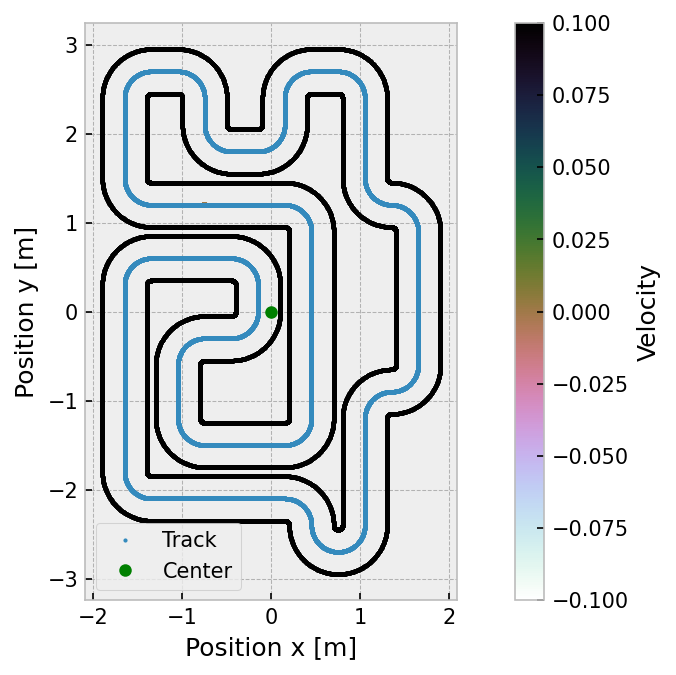

In [18]:
x_list = []
y_list = []

for i in range(x_simulated.shape[0]):
    xy = frenet_to_cartesian(x_simulated[i,0,:2], track_coord)
    x_list.append(xy[0].numpy())
    y_list.append(xy[1].numpy())

x_plot = np.array(x_list)
y_plot = np.array(y_list)

from matplotlib import cm


fig, ax = plt.subplots(1,1, figsize=(10,5), dpi=150)
gen.plotPoints(ax)
#gen.pointAtArcLength(0)
#gen.writePointsToYaml('../tracks/' + track_name + '.yaml', track_density)

custom_cmap = plt.get_cmap('cubehelix').reversed()
sct = ax.scatter(x_plot, y_plot, c=x_simulated[:,0,3].detach(), cmap=custom_cmap, s=4)

cbar = plt.colorbar(sct)
cbar.set_label('Velocity') 
#ax.plot(x_plot, y_plot)

#ax.scatter(x_plot[23:25], y_plot[23:25], color='red', s=4)

#ax.scatter(x_plot, y_plot, s=4, color='red')

print('x_init: ' + str(gen.xCoords[0]))
print('y_init: ' + str(gen.yCoords[0]))
print('yaw_init: ' + str(gen.tangentAngle[0]))
print('Total Arc Length: ' + str(gen.arcLength[-1]/2))
plt.show()

In [54]:
x_simulated.numpy()[:,0,3]

array([0.01      , 0.09      , 0.17      , 0.25      , 0.33      ,
       0.41000003, 0.49000004, 0.57000005, 0.65000004, 0.73      ,
       0.81      , 0.89      , 0.96999997, 1.05      , 1.13      ,
       1.21      , 1.2900001 , 1.3700001 , 1.4500002 , 1.5300002 ,
       1.6100003 , 1.6900003 , 1.7700003 , 1.8500004 , 1.9300004 ,
       2.0100005 , 2.0900004 , 2.1700003 , 2.2500002 , 2.3300002 ,
       2.375     , 2.375     , 2.375     , 2.375     , 2.375     ,
       2.375     , 2.375     , 2.375     , 2.375     , 2.375     ,
       2.375     , 2.375     , 2.375     , 2.375     , 2.375     ,
       2.375     , 2.375     , 2.375     , 2.375     , 2.375     ,
       2.375     , 2.375     , 2.375     , 2.375     , 2.375     ,
       2.375     , 2.375     , 2.375     , 2.375     , 2.375     ,
       2.375     , 2.375     , 2.375     , 2.375     , 2.375     ,
       2.375     , 2.3746514 , 2.375     , 2.375     , 2.375     ,
       2.375     , 2.375     , 2.375     , 2.375     , 2.375  

In [22]:
Q_test_batch.shape

torch.Size([25, 1, 11, 11])